# <stan style = "color : cyan "> Código  </stan>

In [1]:
import json
from enum import Enum
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import savemat
import numpy as np
from shapely import Polygon, Point


class InputError(Exception):
    pass


class LoadingError(Exception):
    pass


class OutOfBounds(Exception):
    pass


class MissingParameterError(Exception):
    pass


class ObjectCreationError(Exception):
    pass


class TipoElectrodo(Enum):
    punto = 'punto'
    circulo = 'circulo'
    poligono = 'poligono'


class FormaDePloteo(Enum):
    fibras_sin_diametro = 'fibras_sin_diametro'
    fibras_con_diametro = 'fibras_con_diametro'


class PoblacionNervio(Enum):
    uniforme_con_superposicion = 'uniforme_con_superposicion'
    uniforme_sin_superposicion = 'uniforme_sin_superposicion'
    manual = 'manual'
    desde_archivo = 'desde_archivo'


class VariacionNodos(Enum):
    uniforme = 'uniforme'
    normal = 'normal'


class TipoEstimulo(Enum):
    potencial_de_accion = 'potencial_de_accion'
    cuadrado = 'cuadrado'
    manual = 'manual'
    desde_archivo = 'desde_archivo'


class TipoFibra(Enum):
    puntual = 'puntual'
    no_puntual = 'no_puntual'


def distancia_entre_puntos(x1, y1, x2, y2):
    """Función que mide la distancia entre dos puntos.

    Args:
        x1 (float): Coordenada x del primer punto. 
        y1 (float): Coordenada y del primer punto.
        x2 (float): Coordenada x del segundo punto.
        y2 (float): Coordenada y del segundo punto.

    Returns:
        float: La función devuelve la distancia entre los dos puntos.
    """
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)


def distancia_entre_circulos(x1, y1, radio1, x2, y2, radio2):
    """Método que devuelve la distancia entre dos círculos.

    Args:
        x1 (float): Coordenada x del centro del primer círculo.
        y1 (float): Coordenada y del centro del primer círculo.
        radio1 (float): Radio del primer círculo.
        x2 (float): Coordenada x del centro del segundo círculo.
        y2 (float): Coordenada y del centro del segundo círculo.
        radio2 (float): Radio del segundo círculo.

    Returns:
        float: Devuelve el cálculo de la distancia entre los dos círculos.
    """
    return (distancia_entre_puntos(x1=x1, y1=y1, x2=x2, y2=y2)) - radio1 - radio2


def is_inside_circencirc(r1, x1, y1, r0, x0, y0):
    """Función con la que se evalúa si un primer círculo (x1,y1,r1) se encuentra dentro de un segundo círculo (x0,y0,r0).

    Args:
        r1 (float): Radio del primer círculo.
        x1 (float): Coordenada x del centro del primer círculo.
        y1 (float): Coordenada y del centro del primer círculo.
        r0 (float): Radio del círculo al que se le evalúa si contiene al primer círculo.
        x0 (float, optional): Coordenada x del centro del círculo al que se le evalúa si contiene al primer círculo. Por defecto es 0.
        y0 (float, optional): Coordenada y del centro del círculo al que se le evalúa si contiene al primer círculo. Por defecto es 0.

    Returns:
        bool: Devuelve True o False de acuerdo a si el primer círculo está contenido dentro del segundo o no.
    """
    return r0 >= r1 + distancia_entre_puntos(x1=x1, y1=y1, x2=x0, y2=y0)


def funcion_trapecio(x, z, d, a):
    """Función trapecio. Devuelve el valor de la función trapecio para un dado x.

    Args:
        x (float): Valor en el cual se evaluará la función trapecio.
        z (float): Centro simétrico del trapecio.
        d (float): La mitad del valor del largo inferior del trapecio.
        a (float): La mitad del largo superior del trapecio.

    Returns:
        float: Devuelve el valor de la función evaluado en un dado x.
    """
    if (x > z - d - a and x < z - a):
        return (x - z + d + a) / d
    if (x > z + a and x < z + a + d):
        return (z + a + d - x) / d
    if (x >= z - a and x <= z + a):
        return 1
    return 0


def funcion_gaussiana(x, z, d, a):
    """Función exponencial con caída como una función gaussiana. 

    Args:
        x (float): Valor en el cual se evaluará la función.
        z (float): mu, esperanza de la función gaussiana.
        d (float): Valor hasta el cual se quiere lograr la caída de la función.
        a (float): Valor hasta el cual se quiere mantener la función igual a 1.

    Returns:
        float: Devuelve el valor de la función evaluado en un dado x.
    """
    if (x > z - d - a and x < z - a):
        exponente = -(x - (z - a))**2 / (2 * (d / 3)**2)
        return np.exp(exponente)
    if (x > z + a and x < z + a + d):
        exponente = -(x - (z + a))**2 / (2 * (d / 3)**2)
        return np.exp(exponente)
    if (x >= z - a and x <= z + a):
        return 1
    return 0


def funcion_constante(x, z, d, a, v):
    """Función que devuelve un valor constante en un cierto rango.

    Args:
        x (float): Valor en el cual se evaluará la función.
        z (float): Centro del intervalo.
        d (float): Valor del ancho del intervalo, hacia izquierda o derecha.
        a (float): Extensión para el ancho del intervalo, hacia izquierda o derecha.
        valor (float): El valor de la función cuando no es cero.

    Returns:
        float: Devuelve el valor de la función evaluado en un dado x.
    """
    if x >= z - d - a and x <= z + d + a:
        return v

    return 0


def insertar_estimulo(estimulo, posicion, fm, tiempo_registro, velocidad, peso):
    """Función que desplaza un numpy array dada una posición de inicio.

    Args:
        estimulo (numpy.ndarray): Señal que es desplazada.
        posicion (float): Posición hasta la que se desplaza el inicio del estímulo. En micrometros.
        fm (float): Frecuencia de muestreo de la señal. En Hz.
        tiempo_registro (float): Tiempo total en el que se hará el registro. En segundos.
        velocidad (float): Velocidad a la cual se desplaza la señal. En m/s.
        peso (float): Factor por el cual se multiplica la señal.

    Returns:
        numpy.ndarray: Devuelve el estímulo desplazado, en el tiempo de registro.
    """
    total_muestras = int(tiempo_registro * fm)
    muestras_estimulo = len(estimulo)
    vector = np.zeros(total_muestras)
    inicio = int((posicion * fm) / (velocidad * 1000000))  #retardo

    if inicio < total_muestras and peso != 0:
        if muestras_estimulo > (total_muestras - inicio):
            muestras_estimulo = total_muestras - inicio
        vector[inicio:inicio + muestras_estimulo] = estimulo[0:muestras_estimulo] * peso
        return vector

    return None


def array_to_multiarray(array, estimulo, fm, tiempo_registro, velocidad, peso):
    """Función que, dado un array con posiciones, crea un array de arrays, con estímulos desplazados para cada posición.

    Args:
        array (numpy.ndarray): Array que contiene las posiciones con las cuales se hará el desplazamiento del estímulo.
        estimulo (numpy.ndarray): Señal que es desplazada.
        fm (float): Frecuencia de muestreo. En Hz.
        tiempo_registro (float): Tiempo total en el que se hará el registro. En segundos.
        velocidad (float): Velocidad a la cual se desplaza la señal. En m/s.
        peso (float): Factor por el cual se multiplica la señal. 

    Returns:
        numpy.ndarray: Devuelve el array de arrays con los estímulos desplazados.
    """
    total_muestras = int(tiempo_registro * fm)
    multiarray = np.zeros((len(array), total_muestras))
    for i, posicion in enumerate(array):
        vector = insertar_estimulo(estimulo=estimulo,
                                   posicion=posicion,
                                   fm=fm,
                                   tiempo_registro=tiempo_registro,
                                   velocidad=velocidad,
                                   peso=peso[i])
        if vector is not None:
            multiarray[i] = vector
    return multiarray


class Nervio:
    """Nervio.
    """

    def __init__(self, diametro, longitud, conductividad_transversal=None, porcentaje_cobertura=None):
        """Método constructor de la clase Nervio.

        Args:
            diametro (int): Diametro del nervio en micrómetros.
            longitud (int): Longitud del nervio en micrometros.
            conductividad_transversal (float, optional): Conductividad transversal del nervio. Por defecto None.
            porcentaje_cobertura (float, optional): Porcentaje del nervio al cual llega el electrodo. Por defecto None.

        Raises:
            InputError: Se levanta este error si no se ingresa un valor de conductividad_transversal o de pocentaje_cobertura, dado que uno de los dos es necesario para realizar cálculos posteriores.
        """
        self.radio = diametro / 2
        self.longitud_nervio = longitud
        self.conductividad_transversal = conductividad_transversal
        self.porcentaje_cobertura = porcentaje_cobertura
        self.fibras = []
        self.cantidad_fibras = 0
        self.limite_lateral_izquierdo = -self.radio
        self.limite_lateral_derecho = self.radio
        self.limite_superior = self.radio
        self.limite_inferior = -self.radio
        self.centro_nervio_x = 0
        self.centro_nervio_y = 0
        self.informacion_nodos = []
        self.metodo_poblacion = None
        self.distancia_nodos_promedio = None

        if self.conductividad_transversal is None and self.porcentaje_cobertura is None:
            raise InputError(
                "Se debe ingresar ya sea un valor de conductividad transversal o un porcentaje de cobertura.")

    def info_nervio(self):
        """Método que devuelve un diccionario con información del nervio.

        Returns:
            dict: Diccionario con información del nervio.
        """
        return {
            "diametro": 2 * self.radio,
            "cantidad_fibras": self.cantidad_fibras,
            "longitud": self.longitud_nervio,
            "posicion_centro_nervio": [self.centro_nervio_x, self.centro_nervio_y],
            "conductividad_transversal": self.conductividad_transversal,
            "porcentaje_de_cobertura": self.porcentaje_cobertura
        }

    def informacion_fibras(self):
        """Método para obtener una lista con la información de las fibras dentro del nervio.

        Returns:
            numpy.ndarray: Devuelve un array cuyas dos primeras columnas son las coordenadas x e y de cada fibra, y la tercera columna contiene información del diámetro de las fibras.
        """
        return np.array([fibra.obtener_info_fibra() for fibra in self.fibras])

    def poblar(self,
               num_fibras,
               diametro_fibra,
               var_diametro,
               metodo_poblacion='uniforme_con_superposicion',
               semilla=None,
               alfa=7.6,
               velocidad=None,
               **kwargs):
        """Método para poblar el nervio con las fibras nerviosas.

        Args:
            num_fibras (int): Número de fibras que contendrá el nervio.
            diametro_fibra (float): Diámetro de la fibra en micrones.
            var_diametro (int): La variación del diámetro se hace con la función normal, por lo que este es el sigma.
            metodo_poblacion (str, optional): Tipo de método de población de fibras en el nervio. Por defecto es 'uniforme'.
            semilla (int, optional): Número de la semilla. Por defecto es None.
            alfa (float, optional): Valor para calcular la velocidad de conducción de las fibras. Por defecto es 7.6. En [m/s/micrómetro]
            velocidad (float,optional): Velocidad de la fibra en [m/s].
        
        Keyword Args:
            array_fibras (numpy.ndarray): Numpy array con 4 columnas: posición x, posición y, diámetro y velocidad de cada fibra, en el método de población manual.
            ubicacion_archivo (str): String con la ubicación del archivo csv para el método de población desde_archivo. El archivo csv debe contener 4 columnas: posición x, posición y, diámetro y velocidad de cada fibra.

        Raises:
            InputError: Si el método de población ingresado no se encuentra entre las opciones disponibles.
        """
        self.metodo_poblacion = metodo_poblacion
        if metodo_poblacion == PoblacionNervio.uniforme_con_superposicion.name:
            if diametro_fibra is None:
                raise InputError('Se debe ingresar un diámetro de fibra.')
            self.uniforme_con_superposicion(num_fibras=num_fibras,
                                            diametro_fibra=diametro_fibra,
                                            var_diametro=var_diametro,
                                            semilla=semilla,
                                            alfa=alfa,
                                            velocidad=velocidad)
        elif metodo_poblacion == PoblacionNervio.uniforme_sin_superposicion.name:
            if diametro_fibra is None:
                raise InputError('Se debe ingresar un diámetro de fibra.')
            self.uniforme_sin_suporsicion(num_fibras=num_fibras,
                                          diametro_fibra=diametro_fibra,
                                          var_diametro=var_diametro,
                                          semilla=semilla,
                                          alfa=alfa,
                                          velocidad=velocidad)
        elif metodo_poblacion == PoblacionNervio.manual.name:
            self.manual(array_fibras=kwargs.get('array_fibras', None))
        elif metodo_poblacion == PoblacionNervio.desde_archivo.name:
            self.desde_archivo(ubicacion_archivo=kwargs.get('ubicacion_archivo', None))
        else:
            raise InputError('El método de población ingresado no es correcto.')

    def uniforme_con_superposicion(self, num_fibras, diametro_fibra, var_diametro, semilla, alfa, velocidad):
        """Función para poblar el nervio con distribución uniforme, con superposición de las fibras.

        Args:
            num_fibras (int): Número de fibras que contendrá el nervio.
            diametro_fibra (float): Diámetro de la fibra en micrones.
            var_diametro (int): La variación del diámetro se hace con la función normal, por lo que este es el sigma.
            semilla (int): Número de la semilla.
            alfa (float): Valor para calcular la velocidad de conducción de las fibras.
            velocidad (float): Velocidad de la fibra en [m/s].
        """
        #Tiene centro en (0,0), implementar el traslado
        np.random.seed(semilla)
        longitud = np.random.uniform(0, self.radio**2, size=num_fibras)
        angulo = np.pi * np.random.uniform(0, 2, size=num_fibras)
        diam = []
        while len(diam) < num_fibras:
            diametro = np.random.normal(diametro_fibra, var_diametro)
            if diametro > 0:
                diam.append(diametro)
        x = np.sqrt(longitud) * np.cos(angulo)
        y = np.sqrt(longitud) * np.sin(angulo)
        matriz = np.column_stack((x, y, np.array(diam)))
        self.fibras = [
            Fibra(x=x, y=y, diametro=diam, velocidad=alfa *
                  diam) if velocidad is None else Fibra(x=x, y=y, diametro=diam, velocidad=velocidad)
            for x, y, diam in matriz
        ]
        self.cantidad_fibras = num_fibras

    def uniforme_sin_suporsicion(self, num_fibras, diametro_fibra, var_diametro, semilla, alfa, velocidad):
        """Función para poblar el nervio con distribución uniforme, sin superposición de las fibras.

        Args:
            num_fibras (int): Número de fibras que contendrá el nervio.
            diametro_fibra (float): Diámetro de la fibra en micrones.
            var_diametro (int): La variación del diámetro se hace con la función normal, por lo que este es el sigma.
            semilla (int): Número de la semilla.
            alfa (float): Valor para calcular la velocidad de conducción de las fibras.
            velocidad (float): Velocidad de la fibra en [m/s].
        """
        np.random.seed(semilla)
        lista = []

        while len(lista) < num_fibras:
            choque = False
            length = np.random.uniform(0, self.radio**2)
            angle = np.pi * np.random.uniform(0, 2)
            diam = np.random.normal(diametro_fibra, var_diametro)
            while diam <= 0:
                diam = np.random.normal(diametro_fibra, var_diametro)
            x = np.sqrt(length) * np.cos(angle)
            y = np.sqrt(length) * np.sin(angle)

            for a, b, c in lista:
                if distancia_entre_circulos(x, y, diam / 2, a, b, c / 2) < 0:
                    choque = True
            if choque is False and is_inside_circencirc(diam / 2, x, y, self.radio, self.centro_nervio_x,
                                                        self.centro_nervio_y):
                lista.append([x, y, diam])

        self.fibras = [
            Fibra(x=x, y=y, diametro=diam, velocidad=alfa *
                  diam) if velocidad is None else Fibra(x=x, y=y, diametro=diam, velocidad=velocidad)
            for x, y, diam in lista
        ]
        self.cantidad_fibras = num_fibras

    def manual(self, array_fibras):
        """Función para poblar el nervio de forma manual, a partir de un array con la posición de las fibras, y sus diámetros.

        Args:
            array_fibras (numpy.ndarray): Array con la posición y diámetros de las fibras, si lo tuviera.
            
        Raises:
            ValueError: Valor que se levanta cuando se encuentra que en el array ingresado no se encuentran todos los parámetros necesarios.
            OutOfBounds: Error que se levanta si se encuentra que alguna de las fibras ingresadas supera los límites del nervio.
        """
        try:
            f = [
                Fibra(x, y, d, v)
                for x, y, d, v in array_fibras
                if is_inside_circencirc(d / 2, x, y, self.radio, self.centro_nervio_x, self.centro_nervio_y)
            ]
        except ValueError as exc:
            raise ValueError(
                'Se necesitan los datos de ubicación de fibras en eje x e y, diámetros y velocidades para este método.'
            ) from exc

        if len(f) != len(array_fibras):
            raise OutOfBounds("Se encontró por lo menos una fibra fuera de los límites del nervio.")

        self.fibras = f
        self.cantidad_fibras = len(array_fibras)

    def desde_archivo(self, ubicacion_archivo):
        """Función para poblar un nervio, a partir de un archivo csv.

        Args:
            ubicacion_archivo (str): String con la ubicación del archivo csv.
            
        Raises:
            LoadingError: Error que se levanta cuando no se puede cargar el archivo.
            ValueError: Error que se levanta cuando se detecta que algún caracter ingresado en el archivo no es numérico.
        """
        try:
            fibras = np.genfromtxt(ubicacion_archivo, delimiter=',')
        except Exception as e:
            raise LoadingError('Fallo en carga de archivo.') from e

        if not np.isnan(sum(fibras)).any() and np.issubdtype(fibras.dtype, np.number):
            self.manual(array_fibras=fibras)
        else:
            raise ValueError("La lista contiene caracteres que no son números.")

    def ploteo_fibras_puntos(self, borde_nervio='blue', relleno_nervio='None', color_fibras='red'):
        """Método para graficar una vista transversal del nervio. Las fibras se muestran como puntos (sin diámetro real).

        Args:
            borde_nervio (str, optional): Color del borde del nervio. Por defecto es azul ('blue').
            relleno_nervio (str, optional): Color del relleno del nervio. Por defecto no tiene color ('None').
            color_fibras (str, optional): Color de las fibras, graficadas como puntos. Escribirlo según formato aceptable por Matplotlib. Por defecto es rojo ('r').
        """

        #Ploteo de las fibras
        matriz = self.informacion_fibras()
        plt.plot(matriz[:, 0], matriz[:, 1], label='Fibras', color=color_fibras, marker='.', linestyle='None')

        #Ploteo del nervio
        plt.gca().add_patch(
            plt.Circle((0, 0), self.radio, edgecolor=borde_nervio, facecolor=relleno_nervio, label='Nervio'))

    def ploteo_fibras_circulos(self,
                               borde_nervio='blue',
                               relleno_nervio='None',
                               borde_fibras='red',
                               relleno_fibras='None'):
        """Método para graficar una vista transversal del nervio. Las fibras se muestran como círculos, con su respectivo diámetro.

        Args:
            borde_nervio (str, optional): Color del borde del nervio. Por defecto es azul ('blue').
            relleno_nervio (str, optional): Color del relleno del nervio. Por defecto no tiene color ('None').
            borde_fibras (str, optional): Color del borde de las fibras. Por defecto es rojo ('red').
            relleno_fibras (str, optional): Color del relleno de las fibras. Por defecto no tiene color ('None').

        Raises:
            InputError: Cuando se encuentra por lo menos una fibra con diámetro igual a 0.
        """
        matriz = self.informacion_fibras()
        if matriz[:, 2].any() == 0:
            raise InputError("Por lo menos una fibra tiene diámetro igual a 0.")

        #Ploteo de las fibras
        for i in range(len(matriz)):
            circle = plt.Circle((matriz[i, 0], matriz[i, 1]),
                                matriz[i, 2],
                                edgecolor=borde_fibras,
                                facecolor=relleno_fibras,
                                label="Fibras" if i == 0 else "")
            plt.gca().add_patch(circle)

        #Ploteo del nervio
        plt.gca().add_patch(
            plt.Circle((0, 0), self.radio, edgecolor=borde_nervio, facecolor=relleno_nervio, label='Nervio'))

    def agregar_nodos(self, distancia_nodos, variacion_nodos, desplazamiento, distribucion_variacion='uniforme'):
        """Método que permite agregar nodos a las fibras. 

        Args:
            distancia_nodos (float): Distancia entre nodos en las fibras en micrómetros.
            variacion (float): Variación de la distancia entre nodos en micrómetros.
            desplazamiento (float): Desplazamiento de los nodos en micrómetros. 
            distribucion_variacion (str, optional): Distribución de la variación de la distancia entre nodos. Se espera un valor correspondiente a alguna de las opciones de VariacionNodos. Por defecto es 'uniforme'.
        """
        self.distancia_nodos_promedio = distancia_nodos
        self.informacion_nodos = [
            f.ubicar_nodos(distancia_nodos=distancia_nodos,
                           variacion=variacion_nodos,
                           desplazamiento=np.random.uniform(-desplazamiento, desplazamiento),
                           distribucion_variacion=distribucion_variacion,
                           longitud_fibra=self.longitud_nervio) for f in self.fibras
        ]


class Fibra:
    """Fibra.
    """

    def __init__(self, x, y, diametro, velocidad):
        """Método constructor de la clase Fibra.

        Args:
            x (float): Posición x del centro de la fibra. En micrómetros.
            y (float): Posición y del centro de la fibra. En micrómetros.
            diametro (float): Diámetro de la fibra. En micrómetros.
            velocidad (float): Velocidad de la fibra en [m/s].
        """
        self.x = x
        self.y = y
        self.radio = diametro / 2
        self.ubicacion_nodos = []
        self.velocidad = velocidad

    def info_fibra(self, numero, pesos, electrodo):
        """Método que proporciona un diccionario con información sobre la fibra.

        Args:
            numero (int): Número de fibra.
            pesos (np.ndarray): Array con los pesos de los nodos de las fibras.
            electrodo (Electrodo): Objeto de la clase Electrodo.

        Returns:
            dict: Diccionario con información de la fibra y sus nodos.
        """
        datos_fibras = {
            "fibra": numero,
            "posicion_transversal_fibra": [self.x, self.y],
            "diametro": 2 * self.radio,
            "velocidad": self.velocidad,
            "nodos": [{
                "ubicacion": ubicacion,
                "peso": pesos[i]
            } for i, ubicacion in enumerate(self.ubicacion_nodos)],
            "SFAP": electrodo.sfap[numero].tolist()
        }
        return datos_fibras

    def obtener_info_fibra(self):
        """Método que permite obtener información sobre la fibra, en forma de lista.

        Returns:
            list: Información sobre la fibra (posición en eje x, posición en eje y, radio de la fibra, velocidad de conducción de la fibra).
        """
        return [self.x, self.y, self.radio, self.velocidad]

    def ubicar_nodos(self, longitud_fibra, distancia_nodos, variacion, desplazamiento, distribucion_variacion):
        """Método para agregar nodos a una fibra.
        Args:
            longitud_fibra (float): Longitud de la fibra en micrómetros.
            distancia_nodos (float): Distancia entre nodos en las fibras en micrómetros.
            variacion (float): Variación de la distancia entre nodos en micrómetros.
            desplazamiento (float): Desplazamiento de los nodos en micrómetros. 
            distribucion_variacion (str): Distribución de la variación de la distancia entre nodos. Se espera un valor correspondiente a alguna de las opciones de VariacionNodos.

        Returns:
            numpy.ndarray: Devuelve un array con la ubicación de los nodos de la fibra.
        """
        #arr = np.arange(-longitud_fibra/2,longitud_fibra*1.5 +1,distancia_nodos)
        arr = np.arange(-longitud_fibra / 2, longitud_fibra * 1.5, distancia_nodos)
        if distribucion_variacion == VariacionNodos.uniforme.name:
            var = np.random.uniform(-variacion / 2, variacion / 2, len(arr)) + desplazamiento
        elif distribucion_variacion == VariacionNodos.normal.name:
            var = np.random.normal(0, variacion, len(arr)) + desplazamiento

        ubicacion = arr + var
        ubicacion = ubicacion[(ubicacion > 0) & (ubicacion < longitud_fibra)]
        self.ubicacion_nodos = ubicacion
        return ubicacion


class Electrodo:
    """Electrodo.
    """

    def __init__(self, tipo, zona_influencia, grosor=0, **kwargs):
        """Método constructor de la clase Electrodo.

        Args:
            tipo (str): Tipo de electrodo. Puede ser los enumerados en el Enum TipoElectrodo.
            zona_influencia (float): Es la zona a cualquiera de los lados a la cual tiene alcance el electrodo. En micrometros.
            grosor (int, optional): Grosor del electrodo en micrometros. Por defecto es 0 micrometros. 
            **kwargs: Argumentos adicionales con nombre.
        
        Keyword Args:
            pos_x (float): Posición del electrodo en el eje x. En micrómetros.
            pos_y (float): Posición del electrodo en el eje y. En micrómetros.
            pos_z (float): Posición del electrodo en el eje z. En micrómetros.
            radio (float): Radio del electrodo tipo Circulo. En micrómetros.
            lista_coordenadas (list): Coordenadas en micrometros del electrodo tipo Poligono.

        Raises:
            InputError: Si el tipo de electrodo ingresado no es correcto.
            MissingParameterError: Si no se ingresan los parámetros necesarios para cada tipo de electrodo.
        """

        self.tipo = tipo
        self.dist_al_electrodo = []
        self.wmax = []
        self.wlong = []
        self.pesos = []
        self.grosor = grosor
        self.zona_influencia = zona_influencia  #es la zona a izquierda o derecha que abarca el electrodo, no la zona completa
        self.valor = kwargs.get('valor', None)
        self.sfap = None
        self.cap = None

        if self.tipo == TipoElectrodo.punto.name:
            self.x = kwargs.get('pos_x')
            self.y = kwargs.get('pos_y')
            self.z = kwargs.get('pos_z')
            self.shape = Point(self.x, self.y)
            if self.x is None or self.y is None or self.z is None:
                raise MissingParameterError(
                    'Los parámetros pos_x, pos_y, pos_z son necesarios para electrodo tipo Punto.')
        elif self.tipo == TipoElectrodo.circulo.name:
            self.x = kwargs.get('pos_x')
            self.y = kwargs.get('pos_y')
            self.z = kwargs.get('pos_z')
            self.radio = kwargs.get('radio')
            self.shape = Point(self.x, self.y).buffer(self.radio)
            if self.x is None or self.y is None or self.radio is None or self.z is None:
                raise MissingParameterError(
                    'Los parámetros pos_x, pos_y, pos_z, radio son necesarios para el electrodo tipo Círculo.')
        elif self.tipo == TipoElectrodo.poligono.name:
            self.z = kwargs.get('pos_z')
            self.coordenadas = kwargs.get('lista_coordenadas')
            self.shape = Polygon(self.coordenadas)
            if self.z is None or self.coordenadas is None:
                raise MissingParameterError(
                    "Los parámetros pos_z y lista_coordenadas son necesarios para el electrodo tipo Polígono.")
        else:
            raise InputError('El tipo de electrodo ingresado no es correcto.')

    def info_electrodo(self, idx):
        """Método que genera un diccionario con información del electrodo.

        Args:
            idx (int): Ubicación del electrodo en la lista de electrodos de la clase Entorno.

        Returns:
            dict: Devuelve un diccionario con información del electrodo.
        """
        return {
            "electrodo_numero": idx,
            "tipo": self.tipo,
            "posicion_transversal_electrodo": [self.x, self.y],
            "posicion_longitudinal_electrodo": self.z,
            "espesor": self.grosor,
            "zona_de_influencia": self.zona_influencia,
        }

    def ploteo_electrodo(self, idx):
        """Método que dibuja al electrodo en el espacio.

        Args:
            idx (int): Ubicación del electrodo en la lista de electrodos de la clase Entorno.
        """
        if self.tipo == TipoElectrodo.punto.name:
            x, y = self.shape.x, self.shape.y
            plt.plot(x, y, 'o', label=f"Electrodo {idx}")
        elif self.tipo in (TipoElectrodo.circulo.name, TipoElectrodo.poligono.name):
            x, y = self.shape.exterior.xy
            plt.plot(x, y, label=f"Electrodo {idx}")

    def calcular_distancias(self, lista_fibras, tipo_fibra):
        """Método para calcular distancias desde el electrodo a las fibras.

        Args:
            lista_fibras (list): Lista de objetos Fibra.
            tipo_fibra (str): Consideracion de la fibra para calcular distancias. Puede ser 'puntual' o 'no_puntual'.
        """
        if tipo_fibra == TipoFibra.puntual.name:
            self.dist_al_electrodo = np.array([self.shape.distance(Point(f.x, f.y)) for f in lista_fibras])
        elif tipo_fibra == TipoFibra.no_puntual.name:
            self.dist_al_electrodo = np.array(
                [self.shape.distance(Point(f.x, f.y).buffer(f.radio)) for f in lista_fibras])
        else:
            raise TypeError("El tipo de fibra ingresado no es correcto.")

    def calcular_wmax(self, nervio):
        """Método para calcular los pesos transversales (Wmax) para cada fibra del nervio.

        Args:
            nervio (Nervio): El nervio que contiene las fibras a las cuales se les calculará el Wmax.
        """
        if nervio.conductividad_transversal is not None:
            cond_transversal = nervio.conductividad_transversal * max(self.dist_al_electrodo)
        else:
            cond_transversal = nervio.porcentaje_cobertura / 100 * max(self.dist_al_electrodo)

        self.wmax = np.array(
            [1 - (x / cond_transversal) if (x >= 0 and x < cond_transversal) else 0 for x in self.dist_al_electrodo])

    def calcular_wlong(self, funcion, matriz_nodos):
        """Método para calcular los pesos longitudinales para cada nodo de cada fibra.

        Args:
            funcion (Callable): Función con la cual se calcularán los pesos longitudinales (Wlong).
            matriz_nodos (list): Lista con la información de la ubicación de nodos de cada fibra.
        """
        a = self.grosor / 2
        d = self.zona_influencia
        v = self.valor
        if funcion == funcion_constante:
            wlong = np.array(
                [np.array([funcion_constante(x=x, z=self.z, a=a, d=d, v=v) for x in lista]) for lista in matriz_nodos])
        else:
            wlong = np.array([np.array([funcion(x=x, z=self.z, a=a, d=d) for x in lista]) for lista in matriz_nodos],
                             dtype=object)
        self.wlong = wlong
        
    def calcular_pesos(self, nervio, funcion, matriz_nodos):
        """Método que calcula los pesos en cada nodo para cada fibra del nervio.

        Args:
            nervio (Nervio): Objeto de la clase Nervio. Nervio que contiene las fibras.
            funcion (Callable): Función con la cual se calcularán los pesos longitudinales (Wlong).
            matriz_nodos (list): Lista con la ubicación de los nodos de cada fibra.
        """
        self.calcular_wmax(nervio)
        self.calcular_wlong(funcion, matriz_nodos)
        
        self.pesos = np.array([np.array([wlong - (1-wmax) if (wlong - (1-wmax)) >= 0 else 0 for wlong in lista_wlong]) for wmax, lista_wlong in zip(self.wmax, self.wlong)],dtype=object)
        

    def sfap_funcion(self, frec_muestreo, velocidad_fibras, tiempo_registro, estimulo, ubicacion_nodos, num_fibras):
        """Método que calcula los Potenciales de Acción de Fibra Unica para cada fibra que se encuentra en el Nervio.

        Args:
            frec_muestreo (float): Frecuencia de muestreo. En Hz.
            velocidad_fibras (float): Velocidad de conducción de una fibra. En m/s.
            tiempo_registro (float): Tiempo en el que se realiza el registro. En segundos.
            estimulo (numpy.ndarray): Array con los estímulos por fibra. 
            ubicacion_nodos (numpy.ndarray): Array con la ubicación de los nodos en todas las fibras.
            num_fibras (int): Cantidad de fibras en el nervio.
        """
        total_muestras = int(tiempo_registro * frec_muestreo)
        sfap_matriz = np.zeros((len(ubicacion_nodos), total_muestras))
        for i, posiciones in enumerate(ubicacion_nodos):
            estimulo_por_nodo = array_to_multiarray(array=posiciones,
                                                    estimulo=estimulo[i],
                                                    fm=frec_muestreo,
                                                    tiempo_registro=tiempo_registro,
                                                    velocidad=velocidad_fibras[i],
                                                    peso=self.pesos[i])
            sfap = np.sum(estimulo_por_nodo, axis=0)
            sfap_matriz[i] = sfap
        self.sfap = sfap_matriz / num_fibras

    def cap_funcion(self):
        """Función que calcula el Potencial de Acción Compuesto captado por el electrodo.
        """
        self.cap = np.sum(self.sfap, axis=0)


class Estimulador:
    """Encargado de generar el impulso de entrada al Nervio.
    """

    def __init__(self, frec_muestreo, tiempo_estimulo, num_fibras):
        """Método constructor de la clase Estimulador.

        Args:
            frec_muestreo (float): Frecuencia de muestreo. En Hz.
            tiempo_estimulo (float): Tiempo total que durará el registro. En segundos.
            num_fibras (int): Número de fibras del nervio.
        """
        self.cant_muestras = int(frec_muestreo * tiempo_estimulo)
        self.frec = frec_muestreo
        self.tiempo_estimulo = tiempo_estimulo
        self.num_fibras = num_fibras
        self.estimulo = None
        self.vector_tiempo = np.arange(1 / self.frec, self.tiempo_estimulo + 1 / self.frec, 1 / self.frec)
        self.tipo_estimulo = None

    def crear_estimulo(self, tipo_estimulo, **kwargs):
        """Método para crear el estímulo que se usará con las fibras del nervio.

        Args:
            tipo_estimulo (str): Tipo de estímulo que se creará. Se detallan en el enum TipoEstimulo.
            
        Keyword Args:
            duracion(float): Tiempo en segundos que durará la señal cuadrada.
            tiempo_inicio (float): Momento en el que inicia el estímulo. En segundos.
            lista_tiempo_inicio(list): Lista con los tiempos en segundos en los cuales se quiere tener un potencial de acción.
            frec_corte(float): Frecuencia de corte del filtro Butterworth. En Hz.
            orden_filtro(int): Orden del filtro pasa bajos.
            ubicacion_archivo(str): Ubicación del archivo csv con la señal de estimulación.
            array_estimulo(numpy.ndarray): Numpy array con la señal de estimulación.

        Raises:
            InputError: Se levanta cuando se ingresa un tipo de estímulo no válido.
        """
        self.tipo_estimulo = tipo_estimulo
        if tipo_estimulo == TipoEstimulo.cuadrado.name:
            self.estimulo_cuadrado(tiempo_inicio=kwargs.get("tiempo_inicio", 0), duracion=kwargs.get('duracion', 0.0),voltaje = kwargs.get('voltaje',1))
        elif tipo_estimulo == TipoEstimulo.potencial_de_accion.name:
            self.potencial_de_accion(tiempo_inicio=kwargs.get("tiempo_inicio", 0),
                                     frec_corte=kwargs.get('frec_corte', 1000),
                                     orden_filtro=kwargs.get('orden_filtro', 2),
                                     lista_inicio=kwargs.get("lista_inicio", None))
        elif tipo_estimulo == TipoEstimulo.manual.name:
            self.estimulo_manual(array_estimulo=kwargs.get('array_estimulo', None),
                                 tiempo_inicio=kwargs.get("tiempo_inicio", 0))
        elif tipo_estimulo == TipoEstimulo.desde_archivo.name:
            self.estimulo_desde_archivo(tiempo_inicio=kwargs.get("tiempo_inicio", 0),
                                        ubicacion_archivo=kwargs.get('ubicacion_archivo', None))
        else:
            raise InputError("El tipo de impulso ingresado no es correcto.")

    def estimulo_cuadrado(self, tiempo_inicio, duracion,voltaje):
        """Método para crear un estímulo cuadrado o spike.

        Args:
            tiempo_inicio (float): Tiempo en el que se desea iniciar el estímulo. En segundos.
            duracion (float): Tiempo que durará el estímulo. Si es cero, se tendrá una spike. En segundos.
        """
        inicio = int(tiempo_inicio * self.frec)
        duracion = duracion * self.frec
        self.estimulo = np.array([
            np.array([voltaje if (j >= inicio and j <= (inicio + duracion)) else 0
                      for j in range(self.cant_muestras)])
            for i in range(self.num_fibras)
        ])

    def potencial_de_accion(self, tiempo_inicio, lista_inicio, frec_corte, orden_filtro):
        """Método para crear un potencial de acción.

        Args:
            tiempo_inicio (float): Tiempo en el que se desea iniciar el estímulo. En segundos.
            lista_tiempo_inicio (list): Lista con los tiempos (en segundos) en donde comenzará la señal.
            frec_corte (float): Frecuencia de corte del filtro pasabajos Butterworth. En Hz.
            orden_filtro (int): Orden del filtro Butterworth.
        """

        if lista_inicio is not None:
            inicio = [int(i * self.frec) for i in lista_inicio]
        else:
            inicio = int(tiempo_inicio * self.frec)

        #Señal de entrada
        x = np.zeros_like(self.vector_tiempo)
        x[inicio] = 1

        #Filtro Butter
        b, a = signal.butter(orden_filtro, frec_corte / (self.frec / 2))
        Vm = signal.lfilter(b, a, x)
        Vm = Vm / np.max(Vm)  #Vm normalizado

        self.estimulo = np.repeat([Vm], self.num_fibras, axis=0)

    def estimulo_manual(self, array_estimulo, tiempo_inicio):
        """Método para crear un estímulo de forma manual, a partir de un array con la señal.

        Args:
            array_estimulo (numpy.ndarray): Señal con la cual se estimularán las fibras del nervio.
            tiempo_inicio (float): Tiempo en el que inicia el estímulo. En segundos.
        """
        if len(array_estimulo) != self.num_fibras:
            raise InputError(
                "EL array con la señal del estímulo debe tener tantas filas como fibras haya en el nervio.")
        estim = np.zeros((len(array_estimulo), self.cant_muestras))
        inicio = int(tiempo_inicio * self.frec)
        flag = False

        if not np.isnan(sum(array_estimulo)).any() and np.issubdtype(array_estimulo.dtype, np.number):
            for i, est in enumerate(array_estimulo):
                muestras_estimulo = len(est)
                if muestras_estimulo > self.cant_muestras - inicio:
                    muestras_estimulo = self.cant_muestras - inicio
                    flag = True
                estim[i][inicio:inicio + muestras_estimulo] = array_estimulo[i][:muestras_estimulo]
        if flag is True:
            print("Se recortó por lo menos una señal de estímulo debido a su tamaño.")

        estim_normalizado = estim / np.amax(estim, axis=1, keepdims=True)
        self.estimulo = estim_normalizado

    def estimulo_desde_archivo(self, ubicacion_archivo, tiempo_inicio):
        """Método para cargar un estímulo desde un archivo csv.

        Args:
            ubicacion_archivo (str): Ubicación del archivo csv.
            tiempo_inicio (float): Tiempo en el que se iniciará el estímulo. En segundos.

        Raises:
            LoadingError: Error que se levanta cuando no se puede leer el archivo.
        """
        try:
            estimulo = np.genfromtxt(ubicacion_archivo, delimiter=',')
        except Exception as e:
            raise LoadingError('Fallo en la carga del archivo.') from e

        self.estimulo_manual(array_estimulo=estimulo, tiempo_inicio=tiempo_inicio)


class Entorno:
    """Entorno.
    """

    def __init__(self, nombre=None, tiempo_registro=None):
        """Metodo constructor de la clase Entorno.

        Args:
            nombre (str, optional): Nombre del experimento. Por defecto es None.
            tiempo_registro (float, optional): Tiempo en el cual se realiza el registro de la señal en segundos. Por defecto es None.
        """
        self.nombre_experimento = nombre
        self.tiempo_registro = tiempo_registro
        self.nervio = None
        self.electrodos = []
        self.estimulador = None
        self.estimulo = None
        self.frec_muestreo = None
        self.cap_dif = None
        self.capdif_pos1 = None
        self.capdif_pos2 = None

    def crear_nervio(self,
                     diametro,
                     longitud,
                     num_fibras,
                     distancia_nodos,
                     diametro_fibra=None,
                     var_diametro=0,
                     conductividad_transversal=None,
                     porcentaje_cobertura=None,
                     metodo_poblacion='uniforme_con_superposicion',
                     semilla=None,
                     alfa=7.6,
                     velocidad=None,
                     variacion_nodos=0,
                     distribucion_variacion='uniforme',
                     desplazamiento=0,
                     **kwargs):
        """Método para crear un nervio, poblarlo con fibras y agregar nodos a esas fibras.

        Args:
            diametro (float): Diámetro del Nervio. En micrometros.
            longitud (float): Longitud del nervio. En micrometros.
            num_fibras (int): Número de fibras con la que se quiere poblar el nervio. Por defecto es 200.
            distancia_nodos (float): Distancia promedio entre nodos en las fibras. En micrometros.
            diametro_fibra (float): Diámetro de las fibras. En micrometros. Por defecto es None.
            var_diametro (float): Variación en micrometros del diámetro de las fibras con la distribución normal (Sigma). Por defecto es 0.
            conductividad_transversal (float, optional): Conductividad transversal del nervio. Por defecto es None.
            porcentaje_cobertura (float, optional): Porcentaje de alcance del electrodo en el nervio. Por defecto es None.
            metodo_poblacion (str, optional): Método con el cual se quiere poblar el nervio. Pueden ser los del enum PoblacionNervio. Por defecto es 'uniforme'.
            semilla (int, optional): Número de la semilla para replicar la distribución. Por defecto es None.
            alfa (float, optional): Valor necesario para el cálculo de la velocidad de conducción de las fibras. En  Por defecto es 7.6. En [m/s/micrometro].
            velocidad (float,optional): Valor de la velocidad de conducción de las fibras. Se asigna a todas las fibras el mismo valor. En m/s.
            variacion (float, optional): Variación de la distancia entre nodos. En micrometros. Por defecto es 0.
            distribucion_variacion (str, optional): Forma de distribución de la variación de los nodos. Puede ser 'uniforme' o 'normal'. Por defecto es 'uniforme'.
            desplazamiento (float, optional): Desplazamiento de todos los nodos en las fibras. En micrometros. Por defecto es 0. 
            
        Keyword Args:
            array_fibras (numpy.ndarray): Numpy array con 4 columnas: posición x, posición y, diámetro y velocidad de cada fibra, en el método de población manual.
            ubicacion_archivo (str): String con la ubicación del archivo csv para el método de población desde_archivo. El archivo csv debe contener 4 columnas: posición x, posición y, diámetro y velocidad de cada fibra.

        """
        self.nervio = Nervio(
            diametro=diametro,
            longitud=longitud,
            conductividad_transversal=conductividad_transversal,
            porcentaje_cobertura=porcentaje_cobertura,
        )
        self.nervio.poblar(num_fibras=num_fibras,
                           metodo_poblacion=metodo_poblacion,
                           diametro_fibra=diametro_fibra,
                           var_diametro=var_diametro,
                           alfa=alfa,
                           velocidad=velocidad,
                           semilla=semilla,
                           **kwargs)
        self.nervio.agregar_nodos(distancia_nodos=distancia_nodos,
                                  variacion_nodos=variacion_nodos,
                                  distribucion_variacion=distribucion_variacion,
                                  desplazamiento=desplazamiento)

    def crear_electrodo(self, tipo, zona_influencia, grosor=0, funcion=funcion_trapecio, **kwargs):
        """Método para crear un electrodo en el entorno de medición.

        Args:
            tipo (str): Tipo de electrodo. Puede ser los enumerados en el Enum TipoElectrodo.
            zona_influencia (float): Es la zona a cualquiera de los lados a la cual tiene alcance el electrodo. En micrometros.
            grosor (int, optional): Grosor del electrodo en micrometros. Por defecto es 0.
            funcion (Callable, optional): Función con la cual se calcularán los pesos para cada nodo. Por defecto se usa la 'funcion_trapecio'.
        
        Keyword Args:
            pos_x (float): Posición del electrodo en el eje x. En micrómetros.
            pos_y (float): Posición del electrodo en el eje y. En micrómetros.
            pos_z (float): Posición del electrodo en el eje z. En micrómetros.
            radio (float): Radio del electrodo tipo Circulo. En micrómetros.
            lista_coordenadas (list): Coordenadas en micrometros del electrodo tipo Poligono.

        Raises:
            ObjectCreationError: Se levanta el error cuando se quiere crear un Electrodo antes de crear un Nervio.
        """
        if self.nervio is None:
            raise ObjectCreationError("Se debe crear un nervio antes de crear un electrodo.")
        nuevo_electrodo = Electrodo(tipo=tipo, zona_influencia=zona_influencia, grosor=grosor, **kwargs)
        nuevo_electrodo.calcular_distancias(lista_fibras=self.nervio.fibras,
                                            tipo_fibra=kwargs.get('tipo_fibra', 'puntual'))
        nuevo_electrodo.calcular_pesos(nervio=self.nervio, funcion=funcion, matriz_nodos=self.nervio.informacion_nodos)
        self.electrodos.append(nuevo_electrodo)

    def crear_estimulo(self, tipo_estimulo, frec_muestreo, tiempo_estimulo, **kwargs):
        """Método que permite crear el estímulo con el que se excitará el nervio.

        Args:
            tipo_estimulo (str): Tipo de estímulo que se creará. Se detallan en el enum TipoEstimulo. En segundos.
            frec_muestreo (float): Frecuencia de muestreo de la señal. En Hz.
            tiempo_estimulo (float): Tiempo total en el que se realizará la medición. En segundos.
        
        Keyword Args:
            duracion(float): Tiempo en segundos que durará la señal cuadrada. En segundos.
            frec_corte(float): Frecuencia de corte del filtro Butterworth. En Hz.
            orden_filtro(int): Orden del filtro pasa bajos.
            ubicacion_archivo(str): Ubicación del archivo csv con la señal de estimulación.
            array_estimulo(numpy.ndarray): Numpy array con la señal de estimulación para cada fibra.
            tiempo_inicio (float): Momento en el que inicia el estímulo. En segundos.
            lista_inicio (list): Lista con los tiempos de inicio para el tren de señales. En segundos.
            voltaje (float): Voltaje del estímulo. En voltios. Por defecto es 1 V.
        """
        self.estimulador = Estimulador(frec_muestreo=frec_muestreo,
                                       tiempo_estimulo=tiempo_estimulo,
                                       num_fibras=self.nervio.cantidad_fibras)
        self.estimulador.crear_estimulo(tipo_estimulo=tipo_estimulo, **kwargs)
        self.estimulo = self.estimulador.estimulo
        self.frec_muestreo = frec_muestreo

        if self.tiempo_registro is None:
            self.tiempo_registro = tiempo_estimulo * 1.5

    def cap(self):
        """Método con el cual se obtiene los Potenciales de Acción Compuestos por cada electrodo que se encuentra en el entorno.
        """
        for electrodo in self.electrodos:
            electrodo.sfap_funcion(frec_muestreo=self.frec_muestreo,
                                   velocidad_fibras=self.nervio.informacion_fibras()[:, 3],
                                   tiempo_registro=self.tiempo_registro,
                                   estimulo=self.estimulo,
                                   ubicacion_nodos=self.nervio.informacion_nodos,
                                   num_fibras=self.nervio.cantidad_fibras)
            electrodo.cap_funcion()

    def cap_diferencial(self, posicion_1=0, posicion_2=1):
        """Método que calcula el Potencial de Accion Diferencial entre dos electrodos.

        Args:
            posicion_1 (int): Posicion del primer electrodo.
            posicion_2 (int): Posicion del segundo electrodo.
        """
        self.cap_dif = self.electrodos[posicion_1].cap - self.electrodos[posicion_2].cap
        self.capdif_pos1 = posicion_1
        self.capdif_pos2 = posicion_2

    def informacion_json(self):
        """Método que devuelve un archivo JSON con información sobre el nervio, las fibras y los electrodos.
        """
        data = {}
        for idx, electrodo in enumerate(self.electrodos):
            data[idx] = {
                "Electrodo": electrodo.info_electrodo(idx=idx),
                "Nervio": self.nervio.info_nervio(),
                "Fibras": [
                    fibra.info_fibra(numero=x, pesos=electrodo.pesos[x], electrodo=electrodo)
                    for x, fibra in enumerate(self.nervio.fibras)
                ],
                "CAP": electrodo.cap.tolist()
            }
        with open('data.json', 'w') as file:
            json.dump(data, file, indent=3)

        del data

    def informe_experimento(self, guardar=False, nombre_archivo="informe.txt"):
        """Método que brinda un informe rápido sobre variables del nervio, electrodos y estimulador. Brinda la posibilidad de guardar la información en un archivo txt.

        Args:
            guardar (bool, optional): Variable que indica si se quiere guardar la información en un archivo txt. Por defecto es False.
        """
        ubicaciones_electrodos = [[e.x, e.y, e.z] for e in self.electrodos]
        tipos_electrodos = [e.tipo for e in self.electrodos]
        grosor = [e.grosor for e in self.electrodos]
        zonas = [e.zona_influencia for e in self.electrodos]
        texto = f'''
NOMBRE DEL EXPERIMENTO: {self.nombre_experimento}

Datos del nervio:
        * Diametro: {2*self.nervio.radio} micrometros
        * Longitud: {self.nervio.longitud_nervio} micrometros
        * Cantidad de fibras: {self.nervio.cantidad_fibras}
        * Posicion del centro del nervio: [{self.nervio.centro_nervio_x},{self.nervio.centro_nervio_y}]
        * Conductividad transversal: {self.nervio.conductividad_transversal}
        * Porcentaje de cobertura del electrodo: {self.nervio.porcentaje_cobertura}
        * Metodo de poblacion: {self.nervio.metodo_poblacion}
        * Distancia entre nodos promedio: {self.nervio.distancia_nodos_promedio}
        
Datos de los electrodos:
        * Cantidad de electrodos: {len(self.electrodos)}
        * Ubicacion de electrodos: {ubicaciones_electrodos}
        * Tipos de electrodos: {tipos_electrodos}
        * Grosor electrodos: {grosor}
        * Zonas de influencia: {zonas}
        
Datos del estimulador:
        * Tipo de estimulo: {self.estimulador.tipo_estimulo}
        * Frecuencia de muestreo: {self.frec_muestreo} Hz
        * Tiempo de estimulo: {self.estimulador.tiempo_estimulo} segundos
        * Tiempo de registro : {self.tiempo_registro} segundos
        '''
        print(texto)
        if guardar is True:
            with open(nombre_archivo, "w") as file:
                file.write(texto)

    def archivo_matlab(self, nombre="info_matlab.mat"):
        """Devuelve un archivo .mat para ser usado en Matlab. Incluye información sobre el CAP diferencial, los CAPs con los cuales se calculó el CAP diferencial, el estímulo, y los vectores de tiempo del estímulo y CAPs.

        Args:
            nombre (str): Nombre del archivo .mat
        """

        info = {
            'CAPdif':
                self.cap_dif,
            'CAP1':
                self.electrodos[self.capdif_pos1].cap,
            'CAP2':
                self.electrodos[self.capdif_pos2].cap,
            'Vm':
                self.estimulador.estimulo[0],
            't_vm':
                self.estimulador.vector_tiempo,
            't_cap':
                np.arange(1 / self.frec_muestreo, 1 / self.frec_muestreo + self.tiempo_registro, 1 / self.frec_muestreo)
        }
        savemat(nombre, info)
        del info

    def quitar_electrodo(self, posicion):
        """Método para quitar un electrodo.

        Args:
            posicion (int): Posición del electrodo que se quiere quitar.
        """
        del self.electrodos[posicion]

    def dibujar_entorno(self,
                        forma_ploteo='fibras_sin_diametro',
                        titulo='Entorno',
                        xlabel='x (μm)',
                        ylabel='y (μm)',
                        borde_nervio='blue',
                        relleno_nervio='None',
                        guardar=False,
                        nombre_figura="figura.png",
                        **kwargs):
        """Método para dibujar el entorno de trabajo (nervio, fibras y electrodos).
        Args:
            forma_ploteo (str, optional): Se puede dibujar las fibras con diámetro (fibras_con_diametro) o como fibras puntuales (fibras_sin_diametro). Por defecto es 'fibras_sin_diametro'.
            titulo (str, optional): Título de la imagen. Por defecto es 'Entorno'.
            xlabel (str, optional): Etiqueta en eje x. Por defecto es 'x (μm)'.
            ylabel (str, optional): Etiqueta en eje y. Por defecto es 'y (μm)'.
            borde_nervio (str, optional): Color del borde del nervio. Por defecto es 'blue'.
            relleno_nervio (str, optional): Color del relleno del nervio. Por defecto es 'None'.
            guardar (bool): Parámetro que indica si la imagen se guardará (True) o no (False). Por defecto es False.
            nombre_figura (str): Nombre que se le dará a la figura que se desea guardar. Por defecto es "figura.png".
        
        Kwargs:
            borde_fibras (str): Color del borde de las fibras. Se aplica cuando FormaDePloteo es 'fibras_con_diametro'. Por defecto es 'blue'.
            relleno_fibras (str): Color del relleno de las fibras. Se aplica cuando FormaDePloteo es 'fibras_con_diametro'. Por defecto es 'None'.
            color_fibras (str): Color de las fibras. Se aplica cuando FormaDePloteo es 'fibras_sin_diametro'. Por defecto es 'red'.

        Raises:
            InputError: Error al introducir una forma de ploteo incorrecta.
        """

        fig = plt.figure()

        #Ploteo nervio y fibras
        if forma_ploteo == FormaDePloteo.fibras_sin_diametro.name:
            self.nervio.ploteo_fibras_puntos(borde_nervio=borde_nervio,
                                             relleno_nervio=relleno_nervio,
                                             color_fibras=kwargs.get('color_fibras', 'red'))
        elif forma_ploteo == FormaDePloteo.fibras_con_diametro.name:
            self.nervio.ploteo_fibras_circulos(borde_nervio=borde_nervio,
                                               relleno_nervio=relleno_nervio,
                                               borde_fibras=kwargs.get('borde_fibras', 'red'),
                                               relleno_fibras=kwargs.get('relleno_fibras', 'None'))
        else:
            raise InputError(
                'Ingrese una forma de ploteo correcta. Puede ser \'fibras_con_diametro\' o \'fibras_sin_diametro\' ')

        #Ploteo electrodos
        for idx, electrodo in enumerate(self.electrodos):
            electrodo.ploteo_electrodo(idx=idx)

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(titulo)
        plt.legend(fontsize='xx-small')
        plt.axis('equal')
        plt.show()

        if guardar is True:
            fig.savefig(nombre_figura, dpi=300, format="png")

    def graficas(self, titulo=None, guardar=False, nombre_figura="figura.png"):
        """Método que permite graficar el estímulo, CAP de cada electrodo que se tenga agregado y CAP diferencial de 2 de los electrodos con los cuales se lo obtuvo.

        Args:
            titulo (str, optional): Título del gráfico. Por defecto no hay.
            guardar (bool, optional): Variable que indica si se quiere guardar el dibujo como imagen tipo PNG. Por defecto es False.
            nombre_figura (str, optional): Nombre con el cual se quiere guardar la imagen. Por defecto es "figura.png".
        """
        fig = plt.figure()

        #Vector tiempo
        vector_tiempo = np.arange(1 / self.frec_muestreo, 1 / self.frec_muestreo + self.tiempo_registro,
                                  1 / self.frec_muestreo)

        #CAP
        for idx, electrodo in enumerate(self.electrodos):
            plt.plot(vector_tiempo*1000, electrodo.cap, label=f"CAP Electrodo n°{idx}")

        #CAP diferencial
        plt.plot(vector_tiempo*1000, self.cap_dif, label=f"CAP diferencial electrodos {self.capdif_pos1}-{self.capdif_pos2}")

        #Vm
        plt.plot(self.estimulador.vector_tiempo*1000, self.estimulador.estimulo[0], label="Vm", color='gray', linewidth=0.7)

        plt.title(titulo)
        plt.xlabel('Tiempo (ms)')
        plt.ylabel('Amplitud relativa')
        plt.legend(fontsize='small')
        plt.show()

        if guardar is True:
            fig.savefig(nombre_figura, dpi=300, format="png")

# <stan style = "color : cyan "> Capítulo 4: Nueva implementación </stan>

## <stan style = "color : orange "> 1. Nervio básico </stan>

In [ ]:
# 1. Creación de nervio ciático sapo

a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.cap()
a.cap_diferencial()
a.dibujar_entorno()
a.graficas(guardar=False,nombre_figura="1_01_nerviobasico1.png",titulo = "CAPs, CAP diferencial y Vm")

In [ ]:
# 2. Creación de nervio infraorbital rata 
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1265,num_fibras=5207,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -632.5,pos_z = 10000,zona_influencia=3000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -632.5,pos_z = 20000,zona_influencia=3000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.cap()
a.cap_diferencial()
#a.dibujar_entorno()
a.graficas(guardar=False,nombre_figura="1_02_nerviobasico2.png",titulo = "CAPs, CAP diferencial y Vm")

In [ ]:
#3. VARIACIONES DE F DE CORTE ESTIMULADOR

f_cortes = [1000,2000,5000,10000]
for f in f_cortes:
    a = Entorno(nombre='Experimento_01')
    a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
    a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
    a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
    a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = f,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
    a.cap()
    a.cap_diferencial()
    a.graficas(titulo=f"Frecuencia de corte = {f}Hz")

In [ ]:
# 4. Guardar solo el dibujo del nervio (círculo grande, sin fibras)
fig = plt.figure() 
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]

plt.gca().add_patch(plt.Circle((0,0),a.nervio.radio, edgecolor = '#285FE2', facecolor = 'none',label = 'Nervio'))
plt.axis('equal')
plt.legend()
plt.title("Nervio")
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
fig.savefig('1_04_nervio_solo.png',dpi=300, format="png")



In [ ]:
# 5. Nervio con fibras - 400 fibras
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=400,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.cap()
a.cap_diferencial()
a.dibujar_entorno(guardar=False,nombre_figura="1_05_nervio_400fibras.png")

In [ ]:
# 6. Nervio con fibras - 4000 fibras
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.cap()
a.cap_diferencial()
a.dibujar_entorno(guardar=False,nombre_figura="1_06_nervio_4000fibras.png")

In [ ]:
# 7. Histograma de diámetros de fibras

a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]

fig = plt.figure() 
plt.hist(a.nervio.informacion_fibras()[:,2],bins = 15, alpha=0.9, color='#FFCF70',edgecolor = 'black')
plt.xlabel('Diámetro de fibras (μm)')
plt.ylabel('Cantidad de fibras')
plt.title(f'Diámetros de fibras')
fig.savefig('1_07_histograma_diametros.png',dpi=300, format="png")

In [ ]:
# 8. Variación de porcentajes de cobertura

porcentajes = [25,50,75,100]
for porcentaje in porcentajes:
    a = Entorno(nombre='Experimento_01')
    a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=porcentaje,var_diametro=1.5,variacion_nodos = 0,semilla = 45)
    a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
    c=False
    e=False
    fig = plt.figure() 
    for idx,fibra in enumerate(a.nervio.informacion_fibras()):
        if a.electrodos[0].wmax[idx] != 0:
            plt.plot(fibra[0],fibra[1],'.',color = '#FF1F40',label="Fibras con peso" if c == False else "")
            c=True
        else:
            plt.plot(fibra[0],fibra[1],'.',color = '#92DBDD',label="Fibras peso = 0" if e == False else "")
            e=True
    #Ploteo del nervio
    plt.gca().add_patch(plt.Circle((0,0),a.nervio.radio,edgecolor = '#42458A', facecolor = 'none',label = 'Nervio'))
    
    x,y = a.electrodos[0].shape.x,a.electrodos[0].shape.y
    plt.plot(x,y,'o',label = f"Electrodo",color = 'orange')

    plt.xlabel('x (μm)')
    plt.ylabel('y (μm)')
    plt.title(f'Porcentaje de cobertura {porcentaje}%')
    plt.legend(fontsize = 'small')
    plt.axis('equal')
    plt.show()
    fig.savefig(f'1_08_{porcentaje}porcentaje.png',dpi=300, format="png")

In [7]:
lista = np.array([0,505,60,7,8,0,0])
lista_filtrada = filter(lambda x: x != 0, lista)
cantidad = len(list(lista_filtrada))
print(cantidad)

4


In [ ]:
# 9. Electrodos - solo borde del nervio y un electrodo

a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
#a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 1000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
#a.dibujar_entorno(color_fibras = '#FF1F40', borde_nervio='#42458A', titulo='Electrodos',guardar=True,nombre_figura='06.electrodos.png')
#Ploteo del nervio
fig = plt.figure() 
plt.gca().add_patch(plt.Circle((0,0),a.nervio.radio,edgecolor = '#42458A', facecolor = 'none',label = 'Nervio'))
x,y = a.electrodos[0].shape.x,a.electrodos[0].shape.y
plt.plot(x,y,'o',label = f"Electrodo",color = '#CC8800')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.title(f'Nervio y electrodo')
plt.legend(fontsize = 'xx-small')
plt.axis('equal')
plt.show()
fig.savefig(f'1_09_electrodo.png',dpi=300, format="png")

In [ ]:
# 10. Ubicación de Electrodos respecto a los Nodos

a = Entorno(nombre='Experimento_01')
a.crear_nervio(semilla= 34,diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 30000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]

fig = plt.figure() 

pos = a.nervio.informacion_fibras()[:,1]
#plt.plot(a.nervio.informacion_nodos[0],'r.')
for x,p in enumerate(pos):
    n = len(a.nervio.informacion_nodos[x])
    valor = p
    posy = np.full((n,), valor)
    plt.plot(a.nervio.informacion_nodos[x],posy,'.',linestyle='-',label = f'Fibra {x}')

for i,e in enumerate(a.electrodos):
    x,z = e.x,e.z
    plt.plot(z,y,'o',label = f"Electrodo {i}")

#Límites del nervio
plt.plot(a.nervio.informacion_nodos[0],np.full((len(a.nervio.informacion_nodos[0]),),a.nervio.limite_superior),color = '#42458A',label = 'Nervio')
plt.plot(a.nervio.informacion_nodos[0],np.full((len(a.nervio.informacion_nodos[0]),),a.nervio.limite_inferior),color = '#42458A')

plt.legend(fontsize = 'xx-small')
plt.title('Posición de electrodos en el eje z')
plt.xlabel('z (μm)')
plt.ylabel('y (μm)')
plt.show()
fig.savefig('1_10_electrodos_nodos.png',dpi=300, format="png")


In [ ]:
# 11. Nodos uniformes y la vista de las fibras

a = Entorno(nombre='Experimento_01')
a.crear_nervio(semilla=34,diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
#a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
#a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 1000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.dibujar_entorno(color_fibras = '#FF1F40', borde_nervio='#42458A', titulo='Nervio y fibras',guardar=True,nombre_figura='08.nervio_nodos.png')
fig = plt.figure() 
pos = a.nervio.informacion_fibras()[:,1]
#plt.plot(a.nervio.informacion_nodos[0],'r.')
for x,p in enumerate(pos):
    n = len(a.nervio.informacion_nodos[x])
    valor = p
    posy = np.full((n,), valor)
    plt.plot(a.nervio.informacion_nodos[x],posy,'.',linestyle='-',label = f'Fibra {x}')

#Límites del nervio
plt.plot(a.nervio.informacion_nodos[0],np.full((len(a.nervio.informacion_nodos[0]),),a.nervio.limite_superior),color = '#42458A',label = 'Nervio')
plt.plot(a.nervio.informacion_nodos[0],np.full((len(a.nervio.informacion_nodos[0]),),a.nervio.limite_inferior),color = '#42458A')

plt.legend(fontsize = 'xx-small')
plt.title('Posición de nodos')
plt.xlabel('z (μm)')
plt.ylabel('y (μm)')
plt.show()
fig.savefig('1_11_nodosuniformes.png',dpi=300, format="png")


In [ ]:
# 12. Zona de influencia del electrodo
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=200,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=5000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=5000,grosor=0,funcion = funcion_trapecio)
#z = np.zeros_like(a.nervio.informacion_nodos[0])
#plt.plot(a.nervio.informacion_nodos[0],z,'c .')
fig = plt.figure() 
plt.plot(a.nervio.informacion_nodos[0],a.electrodos[0].pesos[0],'.',color = '#FFC247',label = 'Peso por nodo en fibra')
plt.plot(a.nervio.informacion_nodos[0],a.electrodos[1].pesos[0],'.',color = '#73D0D3',label = 'Peso por nodo en fibra')
for i,e in enumerate(a.electrodos):
    x,z = e.x,e.z
    plt.plot(z,0,'o',label = f"Electrodo {i}")
plt.legend(fontsize = 'small')
plt.title('Peso de nodos y zona de influencia del electrodo')
plt.xlabel('z (μm)')
plt.ylabel('Pesos')
plt.show()
fig.savefig('1_12_pesos_zonainfluencia.png',dpi=300, format="png")

In [ ]:
# 13. Estimulo, solo dibuja el primero porque asumimos que todos son iguales

a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 1000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
#a.dibujar_entorno(color_fibras = '#FF1F40', borde_nervio='#42458A', titulo='Electrodos',guardar=True,nombre_figura='06.electrodos.png')
fig = plt.figure() 
plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0],color = '#31989B', label = 'Estimulo')
plt.ylabel('Amplitud normalizada')
plt.xlabel('Tiempo (ms)')
plt.title(f'Estímulo')
plt.legend(fontsize = 'small')
plt.show()
fig.savefig(f'1_13_estimulo.png',dpi=300, format="png")

In [ ]:
# 14. Entorno y gráficas
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 1000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.cap()
a.cap_diferencial()
a.dibujar_entorno(borde_nervio='#42458A', color_fibras = '#F50025',guardar=True,nombre_figura='1_14a_entorno.png')
a.graficas(guardar=True,nombre_figura="1_14b_graficas.png",titulo="CAPs, CAP diferencial y Vm")

## <stan style = "color : orange "> 2. Nuevas implementaciones </stan>

In [ ]:
# 15. Grafica con variacion de diametros y sin superposicion

a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=300,metodo_poblacion = 'uniforme_sin_superposicion',diametro_fibra=40,distancia_nodos=500,longitud=50000,porcentaje_cobertura=100,var_diametro=10.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=4000,grosor=1000,funcion = funcion_gaussiana)
#a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-100,-750),(100,-750),(100,-800),(-100,-800)],pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_constante,valor = 1)
#a.crear_electrodo(tipo='circulo',pos_x = 100,pos_y = -800,pos_z = 20000,radio = 50,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.dibujar_entorno(forma_ploteo='fibras_con_diametro',borde_nervio='#42458A',borde_fibras = '#F50025',guardar=True,nombre_figura='1_15a_nervio_nuevo.png')
a.dibujar_entorno(borde_nervio='#42458A',color_fibras = '#F50025',guardar=True,nombre_figura='1_15b_nervio_nuevo.png')

In [ ]:
# 16. Nodos no uniformes - variacion en desplazamiento y distancia

a = Entorno(nombre='Experimento_01')
a.crear_nervio(semilla=2382,diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_sin_superposicion',diametro_fibra=4.5,distancia_nodos=4000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 1000,desplazamiento= 500)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
#a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 1000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.dibujar_entorno(color_fibras = '#FF1F40', borde_nervio='#42458A', titulo='Nervio y fibras',guardar=True,nombre_figura='08.nervio_nodos.png')
fig = plt.figure() 
pos = a.nervio.informacion_fibras()[:,1]
#plt.plot(a.nervio.informacion_nodos[0],'r.')
for x,p in enumerate(pos):
    n = len(a.nervio.informacion_nodos[x])
    valor = p
    posy = np.full((n,), valor)
    plt.plot(a.nervio.informacion_nodos[x],posy,'.',linestyle='-',label = f'Fibra {x}')

#Límites del nervio
plt.plot(a.nervio.informacion_nodos[0],np.full((len(a.nervio.informacion_nodos[0]),),a.nervio.limite_superior),color = '#42458A',label = 'Nervio')
plt.plot(a.nervio.informacion_nodos[0],np.full((len(a.nervio.informacion_nodos[0]),),a.nervio.limite_inferior),color = '#42458A')

plt.legend(fontsize = 'xx-small')
plt.title('Posición de nodos')
plt.xlabel('z (μm)')
plt.ylabel('y (μm)')
plt.show()
fig.savefig('1_16_nodos_variaciondes_nodos.png',dpi=300, format="png")

In [ ]:
# 17. Electrodo en distintas posiciones tocando el nervio - más de dos electrodos para manejar
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_sin_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 100,desplazamiento=100)
a.crear_electrodo(tipo='punto',pos_x = -750,pos_y = 0,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_gaussiana)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = 750,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_gaussiana)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_gaussiana)
a.crear_electrodo(tipo='punto',pos_x = 750,pos_y = 0,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_gaussiana)
#a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-100,-750),(100,-750),(100,-800),(-100,-800)],pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_gaussiana)
#a.crear_electrodo(tipo='circulo',pos_x = 0,pos_y = -850,pos_z = 10000,zona_influencia=4000,grosor=0,radio = 50,funcion = funcion_gaussiana)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 1000,orden_filtro = 2)
a.dibujar_entorno(forma_ploteo = 'fibras_sin_diametro',borde_nervio='#42458A',color_fibras = 'none',guardar=True,nombre_figura='1_17_electrodos_posicion.png')

In [ ]:
# 18. Electrodo en distintas posiciones SIN tocar el nervio - más de dos electrodos para manejar
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_sin_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 100,desplazamiento=100)
a.crear_electrodo(tipo='punto',pos_x = -750,pos_y = -700,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_gaussiana)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -900,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_gaussiana)
a.crear_electrodo(tipo='punto',pos_x = 500,pos_y = 900,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_gaussiana)
#a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-100,-750),(100,-750),(100,-800),(-100,-800)],pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_gaussiana)
#a.crear_electrodo(tipo='circulo',pos_x = 0,pos_y = -850,pos_z = 10000,zona_influencia=4000,grosor=0,radio = 50,funcion = funcion_gaussiana)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 1000,orden_filtro = 2)
a.dibujar_entorno(forma_ploteo = 'fibras_sin_diametro',borde_nervio='#42458A',color_fibras = 'none',guardar=True,nombre_figura='1_18_electrodos_posicion.png')

In [ ]:
# 19. Tipos de electrodos (punto, poligono y circulo)
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_sin_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 100,desplazamiento=100)
a.crear_electrodo(tipo='punto',pos_x = -850,pos_y = 0,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_gaussiana)
a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-100,-750),(100,-750),(100,-800),(-100,-800)],pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_gaussiana)
a.crear_electrodo(tipo='circulo',pos_x = 1000,pos_y = 300,pos_z = 10000,zona_influencia=4000,grosor=0,radio = 50,funcion = funcion_gaussiana)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 1000,orden_filtro = 2)
a.dibujar_entorno(forma_ploteo = 'fibras_sin_diametro',borde_nervio='#42458A',color_fibras = 'none',guardar=True,nombre_figura='1_19_electrodos_tipos.png')

In [ ]:
# 20. Porcentajes de cobertura - Electrodo 'punto' a la izquierda

porcentajes = [25,50,75,100]
for porcentaje in porcentajes:
    a = Entorno(nombre='Experimento_01')
    a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=porcentaje,var_diametro=1.5,variacion_nodos = 0)
    a.crear_electrodo(tipo='punto',pos_x = -750,pos_y = 0,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
    c=False
    e=False
    fig = plt.figure() 
    for idx,fibra in enumerate(a.nervio.informacion_fibras()):
        if a.electrodos[0].wmax[idx] != 0:
            plt.plot(fibra[0],fibra[1],'.',color = '#FF1F40',label="Fibras con peso" if c == False else "")
            c=True
        else:
            plt.plot(fibra[0],fibra[1],'.',color = '#92DBDD',label="Fibras peso = 0" if e == False else "")
            e=True
    #Ploteo del nervio
    plt.gca().add_patch(plt.Circle((0,0),a.nervio.radio,edgecolor = '#42458A', facecolor = 'none',label = 'Nervio'))
    
    x,y = a.electrodos[0].shape.x,a.electrodos[0].shape.y
    plt.plot(x,y,'o',label = f"Electrodo",color = '#CC8800')

    plt.xlabel('x (μm)')
    plt.ylabel('y (μm)')
    plt.title(f'Porcentaje de cobertura {porcentaje}%')
    plt.legend(fontsize = 'xx-small')
    plt.axis('equal')
    plt.show()
    fig.savefig(f'1_20_izq_{porcentaje}porcentaje.png',dpi=300, format="png")

In [ ]:
# 21. Porcentajes de cobertura - Electrodo 'punto' abajo

porcentajes = [25,50,75,100]

for porcentaje in porcentajes:
    a = Entorno(nombre='Experimento_01')
    a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=porcentaje,var_diametro=1.5,variacion_nodos = 0)
    a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
    c=False
    e=False
    fig = plt.figure() 
    for idx,fibra in enumerate(a.nervio.informacion_fibras()):
        if a.electrodos[0].wmax[idx] != 0:
            plt.plot(fibra[0],fibra[1],'.',color = '#FF1F40',label="Fibras con peso" if c == False else "")
            c=True
        else:
            plt.plot(fibra[0],fibra[1],'.',color = '#92DBDD',label="Fibras peso = 0" if e == False else "")
            e=True
    #Ploteo del nervio
    plt.gca().add_patch(plt.Circle((0,0),a.nervio.radio,edgecolor = '#42458A', facecolor = 'none',label = 'Nervio'))
    
    x,y = a.electrodos[0].shape.x,a.electrodos[0].shape.y
    plt.plot(x,y,'o',label = f"Electrodo",color = '#CC8800')

    plt.xlabel('x (μm)')
    plt.ylabel('y (μm)')
    plt.title(f'Porcentaje de cobertura {porcentaje}%')
    plt.legend(fontsize = 'xx-small')
    plt.axis('equal')
    plt.show()
    fig.savefig(f'1_21_abajo_{porcentaje}porcentaje.png',dpi=300, format="png")

In [ ]:
# 22. Porcentajes de cobertura - Electrodo 'poligono' abajo

porcentajes = [25,50,75,100]

for porcentaje in porcentajes:
    a = Entorno(nombre='Experimento_01')
    a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=porcentaje,var_diametro=1.5,variacion_nodos = 0)
    a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-100,-750),(100,-750),(100,-800),(-100,-800)],pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
    c=False
    e=False
    fig = plt.figure() 
    for idx,fibra in enumerate(a.nervio.informacion_fibras()):
        if a.electrodos[0].wmax[idx] != 0:
            plt.plot(fibra[0],fibra[1],'.',color = '#FF1F40',label="Fibras con peso" if c == False else "")
            c=True
        else:
            plt.plot(fibra[0],fibra[1],'.',color = '#92DBDD',label="Fibras peso = 0" if e == False else "")
            e=True
    #Ploteo del nervio
    plt.gca().add_patch(plt.Circle((0,0),a.nervio.radio,edgecolor = '#42458A', facecolor = 'none',label = 'Nervio'))
    
    x,y = a.electrodos[0].shape.exterior.xy
    plt.plot(x,y,color = '#CC8800',label = "Electrodo")
    
    # x,y = a.electrodos[0].shape.x,a.electrodos[0].shape.y
    # plt.plot(x,y,'o',label = f"Electrodo",color = '#CC8800')

    plt.xlabel('x (μm)')
    plt.ylabel('y (μm)')
    plt.title(f'Porcentaje de cobertura {porcentaje}%')
    plt.legend(fontsize = 'xx-small')
    plt.axis('equal')
    plt.show()
    fig.savefig(f'1_22_polig_{porcentaje}porcentaje.png',dpi=300, format="png")

In [ ]:
# 23. Porcentajes de cobertura - Electrodo 'circulo' abajo

porcentajes = [25,50,75,100]

for porcentaje in porcentajes:
    a = Entorno(nombre='Experimento_01')
    a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=porcentaje,var_diametro=1.5,variacion_nodos = 0)
    a.crear_electrodo(tipo='circulo',pos_x = 0,pos_y = -850,radio = 75,pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
    c=False
    e=False
    fig = plt.figure() 
    for idx,fibra in enumerate(a.nervio.informacion_fibras()):
        if a.electrodos[0].wmax[idx] != 0:
            plt.plot(fibra[0],fibra[1],'.',color = '#FF1F40',label="Fibras con peso" if c == False else "")
            c=True
        else:
            plt.plot(fibra[0],fibra[1],'.',color = '#92DBDD',label="Fibras peso = 0" if e == False else "")
            e=True
    #Ploteo del nervio
    plt.gca().add_patch(plt.Circle((0,0),a.nervio.radio,edgecolor = '#42458A', facecolor = 'none',label = 'Nervio'))
    
    x,y = a.electrodos[0].shape.exterior.xy
    plt.plot(x,y,color = '#CC8800',label = "Electrodo")

    plt.xlabel('x (μm)')
    plt.ylabel('y (μm)')
    plt.title(f'Porcentaje de cobertura {porcentaje}%')
    plt.legend(fontsize = 'xx-small')
    plt.axis('equal')
    plt.show()
    fig.savefig(f'1_23_circulo_{porcentaje}porcentaje.png',dpi=300, format="png")


In [ ]:
# 24. Zonas de influencia - Distintas funciones para los pesos

a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=200,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=5000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=5000,grosor=0,funcion = funcion_gaussiana)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 35000,zona_influencia=5000,grosor=0,funcion = funcion_constante,valor = 0.7)
#z = np.zeros_like(a.nervio.informacion_nodos[0])
#plt.plot(a.nervio.informacion_nodos[0],z,'c .')
fig = plt.figure() 
plt.plot(a.nervio.informacion_nodos[0],a.electrodos[0].pesos[0],'.',color = '#FFC247',label = 'Peso por nodo en fibra',linestyle = '-')
plt.plot(a.nervio.informacion_nodos[0],a.electrodos[1].pesos[0],'.',color = '#73D0D3',label = 'Peso por nodo en fibra',linestyle = '-')
plt.plot(a.nervio.informacion_nodos[0],a.electrodos[2].pesos[0],'.',color = '#FF7086',label = 'Peso por nodo en fibra',linestyle = '-')
for i,e in enumerate(a.electrodos):
    x,z = e.x,e.z
    plt.plot(z,0,'o',label = f"Electrodo {i}")
plt.legend(fontsize = 'x-small')
plt.title('Peso de nodos y zona de influencia del electrodo')
plt.xlabel('z (μm)')
plt.ylabel('Pesos')
plt.show()
fig.savefig('1_24_zonas_influencia_funciones.png',dpi=300, format="png")

In [ ]:
# 25. Zonas de influencia - CON grosor
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=200,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=5000,grosor=3000,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=8000,grosor=3000,funcion = funcion_gaussiana)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 35000,zona_influencia=5000,grosor=0,funcion = funcion_constante,valor = 0.7)
#z = np.zeros_like(a.nervio.informacion_nodos[0])
#plt.plot(a.nervio.informacion_nodos[0],z,'c .')
fig = plt.figure() 
plt.plot(a.nervio.informacion_nodos[0],a.electrodos[0].pesos[0],'.',color = '#FFC247',label = 'Peso por nodo en fibra')
plt.plot(a.nervio.informacion_nodos[0],a.electrodos[1].pesos[0],'.',color = '#73D0D3',label = 'Peso por nodo en fibra')
plt.plot(a.nervio.informacion_nodos[0],a.electrodos[2].pesos[0],'.',color = '#FF7086',label = 'Peso por nodo en fibra',linestyle = '-')
for i,e in enumerate(a.electrodos):
    x,z = e.x,e.z
    plt.plot(z,0,'o',label = f"Electrodo {i}")
plt.legend(fontsize = 'x-small')
plt.title('Peso de nodos y zona de influencia del electrodo')
plt.xlabel('z (μm)')
plt.ylabel('Pesos')
plt.show()
fig.savefig('1_30_electrodos_grosor.png',dpi=300, format="png")

In [ ]:
# 26.1 Estimulos nuevos - Potencial de Acción
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 1000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
#a.dibujar_entorno(color_fibras = '#FF1F40', borde_nervio='#42458A', titulo='Electrodos',guardar=True,nombre_figura='06.electrodos.png')
fig = plt.figure() 
plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0],color = '#31989B', label = 'Estimulo')
plt.ylabel('Amplitud normalizada')
plt.xlabel('Tiempo (ms)')
plt.title(f'Estímulo')
plt.legend(fontsize = 'small')
plt.show()
fig.savefig(f'1_26_1_estimulo.png',dpi=300, format="png")
for x,peso in enumerate(a.electrodos[0].pesos[0]):
    if peso != 0:
        print(peso)

In [ ]:
# 26.2 Estimulos nuevos - Tren de potenciales de acción
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.006,lista_inicio = [0,0.002,0.004],frec_corte = 1000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
#a.dibujar_entorno(color_fibras = '#FF1F40', borde_nervio='#42458A', titulo='Electrodos',guardar=True,nombre_figura='06.electrodos.png')
fig = plt.figure() 
plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0],color = '#31989B', label = 'Estimulo')
plt.ylabel('Amplitud normalizada')
plt.xlabel('Tiempo (ms)')
plt.title(f'Estímulo')
plt.legend(fontsize = 'small')
plt.show()
fig.savefig(f'1_26_2_estimulo.png',dpi=300, format="png")

In [ ]:
# 26.3 Estimulos nuevos - Delta dirac
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='cuadrado',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001)
#a.dibujar_entorno(color_fibras = '#FF1F40', borde_nervio='#42458A', titulo='Electrodos',guardar=True,nombre_figura='06.electrodos.png')
fig = plt.figure() 
plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0],color = '#31989B', label = 'Estimulo')
plt.ylabel('Amplitud normalizada')
plt.xlabel('Tiempo (ms)')
plt.title(f'Estímulo')
plt.legend(fontsize = 'small')
plt.show()
fig.savefig(f'1_26_3_estimulo.png',dpi=300, format="png")

In [ ]:
# 26.4 Estimulos nuevos - Cuadrada
a = Entorno(nombre='Experimento_01')
a.crear_nervio(diametro = 1500,num_fibras=10,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=4.5,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,var_diametro=1.5,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 10000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -750,pos_z = 20000,zona_influencia=4000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='cuadrado',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,duracion = 0.001) #lista_inicio = [0,0.001,0.002]
#a.dibujar_entorno(color_fibras = '#FF1F40', borde_nervio='#42458A', titulo='Electrodos',guardar=True,nombre_figura='06.electrodos.png')
fig = plt.figure() 
plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0],color = '#31989B', label = 'Estimulo')
plt.ylabel('Amplitud normalizada')
plt.xlabel('Tiempo (ms)')
plt.title(f'Estímulo')
plt.legend(fontsize = 'small')
plt.show()
fig.savefig(f'1_26_4_estimulo.png',dpi=300, format="png")

# <stan style = "color : cyan "> Capítulo 5: Analisis </stan>

## <stan style = "color : orange "> Tercera parte: nuevos parametros </stan>

### <stan style = "color : magenta ">Nervio  </stan>

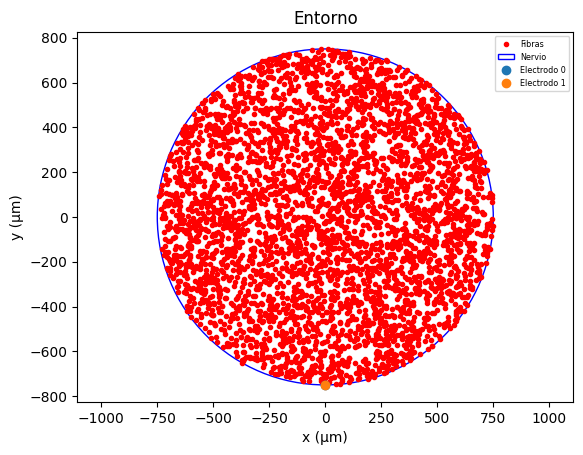

In [12]:
a = Entorno(nombre='Experimento_01',tiempo_registro=0.003)
a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',distancia_nodos=2000,longitud=70000,porcentaje_cobertura=10,variacion_nodos = 500,diametro_fibra=4.5,var_diametro=1.5)
#a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-100,-750),(-100,-800),(100,-800),(100,-750)],pos_z = 10000,zona_influencia=z,grosor=500,funcion = funcion_trapecio)
#a.crear_electrodo(tipo='circulo',pos_x = 0,pos_y = -800,pos_z = 20000,radio = 50,zona_influencia=z,grosor=500,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0, pos_y = -750, pos_z = 20000, zona_inflPuencia=10000,grosor = 0,funcion = funcion_trapecio) 
a.crear_electrodo(tipo='punto',pos_x = 0, pos_y = -750, pos_z = 30000, zona_influencia=10000,grosor = 0,funcion = funcion_trapecio) 
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.cap()
a.cap_diferencial()
a.dibujar_entorno()

In [14]:
lista = a.electrodos[idx].wmax
lista_filtrada = filter(lambda x: x != 0, lista)
cantidad = len(list(lista_filtrada))
print(cantidad)

84


### <stan style = "color : magenta ">1. Con super / Sin super </stan>

In [16]:
# Con superposicion vs sin superposición

# 1. Con superposicion (Básico)

from scipy.interpolate import interp1d

arch = np.zeros((10,3))
desviacion = np.zeros((10,3))

#zonas = [3000,4000,5000,6000,7000,8000,9000,10000,11000,12000]
porcentajes = [10,20,30,40,50,60,70,80,90,100]
for id,p in enumerate(porcentajes):
    info = np.zeros((10,3))
    for i in range(10):
        a = Entorno(nombre='Experimento_01',tiempo_registro=0.003)
        a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',distancia_nodos=2000,longitud=70000,porcentaje_cobertura=p,variacion_nodos = 0,diametro_fibra=4.5,var_diametro=1.5)
        # a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-100,-750),(-100,-800),(100,-800),(100,-750)],pos_z = 10000,zona_influencia=z,grosor=0,funcion = funcion_trapecio)
        # a.crear_electrodo(tipo='circulo',pos_x = 0,pos_y = -800,pos_z = 20000,radio = 50,zona_influencia=z,grosor=500,funcion = funcion_trapecio)
        a.crear_electrodo(tipo='punto',pos_x = 0, pos_y = -750, pos_z = 20000, zona_influencia=10000,grosor = 0,funcion = funcion_trapecio) 
        a.crear_electrodo(tipo='punto',pos_x = 0, pos_y = -750, pos_z = 30000, zona_influencia=10000,grosor = 0,funcion = funcion_trapecio) 
        a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
        a.cap()
        a.cap_diferencial()
        
        # Electrodo 0 -------------------
        limite = 63
        idx = 0

        # Alturas máxima, 90%, 10% y 50%
        e = a.electrodos[idx]
        alt_max = max(e.cap)
        alt_50 = max(e.cap)*0.5

        # Tiempos al 50% de altura
        vector_tiempo = np.arange(1 / a.frec_muestreo, 1 / a.frec_muestreo + a.tiempo_registro,1 / a.frec_muestreo)
        x = vector_tiempo[:limite]
        y = a.electrodos[idx].cap[:limite]
        func = interp1d(y,x)
        t1_50 = func(alt_50)*1000

        x = vector_tiempo[limite:]
        y = a.electrodos[idx].cap[limite:]
        func = interp1d(y,x)
        t2_50 = func(alt_50)*1000

        #Cantidad de fibras
        lista = a.electrodos[idx].wmax
        lista_filtrada = filter(lambda x: x != 0, lista)
        cantidad = len(list(lista_filtrada))
        
        info[i] = [alt_max,cantidad,t2_50-t1_50]
    # info es dimension 10,10
    promedio = sum(info)/10 # dimension 1,10
    desv = [np.std([sub[i] for sub in info]) for i in range(3)] 
    
    arch[id] = promedio
    desviacion[id] = desv
print(list(arch))
print(list(desviacion))
#np.savetxt("info1.csv", arch, delimiter=",")

[array([5.84936821e-03, 7.85000000e+01, 4.11544418e-01]), array([2.12694520e-02, 2.91700000e+02, 4.18217566e-01]), array([4.87105299e-02, 6.28800000e+02, 4.16126381e-01]), array([8.40032879e-02, 1.04910000e+03, 4.09762679e-01]), array([1.27328672e-01, 1.54860000e+03, 4.10806673e-01]), array([1.79801834e-01, 2.10620000e+03, 4.07573215e-01]), array([2.35653441e-01, 2.68430000e+03, 4.09947563e-01]), array([2.95170660e-01, 3.22540000e+03, 4.11339357e-01]), array([3.64358004e-01, 3.70950000e+03, 4.11188379e-01]), array([4.28391747e-01, 3.99900000e+03, 4.07946270e-01])]
[array([1.06140680e-03, 6.11964051e+00, 5.59437022e-02]), array([2.35358489e-03, 1.67573864e+01, 2.31929720e-02]), array([2.84633534e-03, 1.58669468e+01, 2.06098275e-02]), array([2.79537570e-03, 3.06380482e+01, 1.79334962e-02]), array([4.56025415e-03, 1.90063147e+01, 1.04741309e-02]), array([3.89499287e-03, 2.67536913e+01, 7.55830089e-03]), array([5.47208813e-03, 2.16704868e+01, 1.01825956e-02]), array([9.45305123e-03, 2.1345

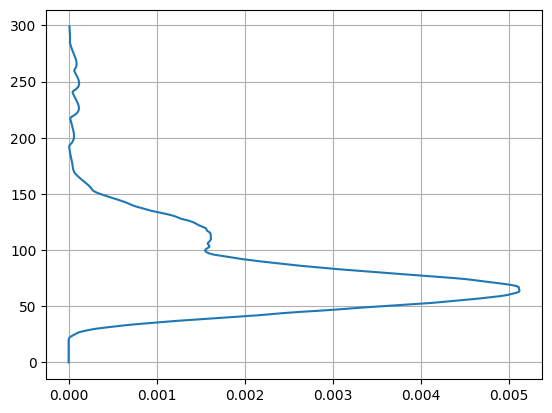

In [13]:
vector_tiempo = np.arange(1 / a.frec_muestreo, 1 / a.frec_muestreo + a.tiempo_registro,1 / a.frec_muestreo)
y = a.electrodos[idx].cap
x = list(range(len(y)))
plt.grid()
plt.plot(y,x)




In [20]:
# Con superposicion vs sin superposición
#! ESTA NO, USAR LA DE ABAJOOOOO! --------------------------------------

# 2. Sin superposicion

from scipy.interpolate import interp1d
arch = np.zeros((10,10))
desviacion = np.zeros((10,10))
zonas = [3000,4000,5000,6000,7000,8000,9000,10000,11000,12000]
for id,z in enumerate(zonas):
    info = np.zeros((10,10))

    for i in range(10):
        a = Entorno(nombre='Experimento_01',tiempo_registro=0.003)
        a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_sin_superposicion',distancia_nodos=2000,longitud=70000,porcentaje_cobertura=100,variacion_nodos = 0,diametro_fibra=4.5,var_diametro=1.5)
        # a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-100,-750),(-100,-800),(100,-800),(100,-750)],pos_z = 10000,zona_influencia=z,grosor=0,funcion = funcion_trapecio)
        # a.crear_electrodo(tipo='circulo',pos_x = 0,pos_y = -800,pos_z = 20000,radio = 50,zona_influencia=z,grosor=500,funcion = funcion_trapecio)
        a.crear_electrodo(tipo='punto',pos_x = 0, pos_y = -750, pos_z = 20000, zona_influencia=z,grosor = 0,funcion = funcion_trapecio) 
        a.crear_electrodo(tipo='punto',pos_x = 0, pos_y = -750, pos_z = 30000, zona_influencia=z,grosor = 0,funcion = funcion_trapecio) 
        a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
        a.cap()
        a.cap_diferencial()
        
        # Electrodo 0 -------------------
        limite = 62
        idx = 0

        # Alturas máxima, 90%, 10% y 50%
        e = a.electrodos[idx]
        alt_max = max(e.cap)
        alt_10 = max(e.cap)*0.1
        alt_90 = max(e.cap)*0.9
        alt_50 = max(e.cap)*0.5

        # Tiempos al 50% de altura
        vector_tiempo = np.arange(1 / a.frec_muestreo, 1 / a.frec_muestreo + a.tiempo_registro,1 / a.frec_muestreo)
        x = vector_tiempo[:limite]
        y = a.electrodos[idx].cap[:limite]
        func = interp1d(y,x)
        t1_50 = func(alt_50)*1000

        x = vector_tiempo[limite:]
        y = a.electrodos[idx].cap[limite:]
        func = interp1d(y,x)
        t2_50 = func(alt_50)*1000

        #Duracion = (t2_50 - t1_50)*1000

        # Tiempos al 10% y 90%
        x = vector_tiempo[:limite]
        y = a.electrodos[idx].cap[:limite]
        func = interp1d(y,x)
        t_90 = func(alt_90)*1000
        t_10 = func(alt_10)*1000
        
        
        info[i] = [alt_max,alt_90,t_90,alt_10,t_10,alt_50,t1_50,t2_50,t_90-t_10,t2_50-t1_50]
    promedio = sum(info)/10
    desv = [np.std([sub[i] for sub in info]) for i in range(len(info))] 
    arch[id] = promedio
    desviacion[id] = desv
print(list(arch))
print(list(desviacion))
np.savetxt("info2.csv", arch, delimiter=",")

[array([0.11748243, 0.10573419, 0.5809158 , 0.01174824, 0.39387025,
       0.05874122, 0.48871422, 0.87405748, 0.18704556, 0.38534325]), array([0.16852667, 0.15167401, 0.57827564, 0.01685267, 0.39269565,
       0.08426334, 0.48642092, 0.86891447, 0.18557999, 0.38249355]), array([0.21532358, 0.19379122, 0.57904267, 0.02153236, 0.39131853,
       0.10766179, 0.48670301, 0.87893602, 0.18772414, 0.39223301]), array([0.26110008, 0.23499007, 0.5785837 , 0.02611001, 0.38723005,
       0.13055004, 0.48480959, 0.87706716, 0.19135365, 0.39225757]), array([0.30535377, 0.27481839, 0.57659481, 0.03053538, 0.38211751,
       0.15267688, 0.48166099, 0.87927851, 0.19447731, 0.39761753]), array([0.34652508, 0.31187257, 0.57333631, 0.03465251, 0.37840222,
       0.17326254, 0.47866424, 0.88426472, 0.19493409, 0.40560048]), array([0.3876754 , 0.34890786, 0.57216857, 0.03876754, 0.37300173,
       0.1938377 , 0.47587734, 0.88189126, 0.19916683, 0.40601392]), array([0.42455945, 0.38210351, 0.56840223, 0.04

In [17]:
# Con superposicion vs sin superposición

# 2. Sin superposicion

from scipy.interpolate import interp1d

arch = np.zeros((10,3))
desviacion = np.zeros((10,3))

porcentajes = [10,20,30,40,50,60,70,80,90,100]
for id,p in enumerate(porcentajes):
    info = np.zeros((10,3))
    for i in range(10):
        a = Entorno(nombre='Experimento_01',tiempo_registro=0.003)
        a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_sin_superposicion',distancia_nodos=2000,longitud=70000,porcentaje_cobertura=p,variacion_nodos = 0,diametro_fibra=4.5,var_diametro=1.5)
        # a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-100,-750),(-100,-800),(100,-800),(100,-750)],pos_z = 10000,zona_influencia=z,grosor=0,funcion = funcion_trapecio)
        # a.crear_electrodo(tipo='circulo',pos_x = 0,pos_y = -800,pos_z = 20000,radio = 50,zona_influencia=z,grosor=500,funcion = funcion_trapecio)
        a.crear_electrodo(tipo='punto',pos_x = 0, pos_y = -750, pos_z = 20000, zona_influencia=10000,grosor = 0,funcion = funcion_trapecio) 
        a.crear_electrodo(tipo='punto',pos_x = 0, pos_y = -750, pos_z = 30000, zona_influencia=10000,grosor = 0,funcion = funcion_trapecio) 
        a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
        a.cap()
        a.cap_diferencial()
        
        # Electrodo 0 -------------------
        limite = 63
        idx = 0

        # Alturas máxima, 90%, 10% y 50%
        e = a.electrodos[idx]
        alt_max = max(e.cap)
        alt_50 = max(e.cap)*0.5

        # Tiempos al 50% de altura
        vector_tiempo = np.arange(1 / a.frec_muestreo, 1 / a.frec_muestreo + a.tiempo_registro,1 / a.frec_muestreo)
        x = vector_tiempo[:limite]
        y = a.electrodos[idx].cap[:limite]
        func = interp1d(y,x)
        t1_50 = func(alt_50)*1000

        x = vector_tiempo[limite:]
        y = a.electrodos[idx].cap[limite:]
        func = interp1d(y,x)
        t2_50 = func(alt_50)*1000

        #Cantidad de fibras
        lista = a.electrodos[idx].wmax
        lista_filtrada = filter(lambda x: x != 0, lista)
        cantidad = len(list(lista_filtrada))
        
        info[i] = [alt_max,cantidad,t2_50-t1_50]
    # info es dimension 10,10
    promedio = sum(info)/10 # dimension 1,10
    desv = [np.std([sub[i] for sub in info]) for i in range(3)] 
    
    arch[id] = promedio
    desviacion[id] = desv
print(list(arch))
print(list(desviacion))
#np.savetxt("info1.csv", arch, delimiter=",")

[array([5.28424666e-03, 7.59000000e+01, 4.47685429e-01]), array([2.19386316e-02, 2.90300000e+02, 4.07685555e-01]), array([4.99313086e-02, 6.35100000e+02, 4.00524056e-01]), array([8.49244161e-02, 1.05240000e+03, 4.03081027e-01]), array([1.28669767e-01, 1.54200000e+03, 4.02423070e-01]), array([1.77976726e-01, 2.10980000e+03, 4.10966860e-01]), array([2.35523130e-01, 2.69640000e+03, 4.12952689e-01]), array([2.94961522e-01, 3.22460000e+03, 4.13092447e-01]), array([3.57577168e-01, 3.69870000e+03, 4.10595118e-01]), array([4.22413641e-01, 3.99900000e+03, 4.14425557e-01])]
[array([9.56798372e-04, 6.53375849e+00, 8.40482168e-02]), array([1.93869141e-03, 1.55695215e+01, 3.37995465e-02]), array([2.92430964e-03, 1.84577897e+01, 1.60349043e-02]), array([3.59333470e-03, 2.44916312e+01, 1.57887825e-02]), array([4.22184064e-03, 3.43685903e+01, 7.61447457e-03]), array([5.50278985e-03, 2.66825786e+01, 6.80134146e-03]), array([6.04102373e-03, 2.91073874e+01, 8.25386542e-03]), array([8.86636153e-03, 2.0582

### <stan style = "color : magenta "> 2. Variación de nodos  </stan>

In [14]:
# 3. Variacion de distancia entre nodos

variacion_de_nodos = [0,100,200,300,400,500,600,700,800,900]

from scipy.interpolate import interp1d
arch = np.zeros((10,2))
desviacion = np.zeros((10,2))

for id,v in enumerate(variacion_de_nodos):
    info = np.zeros((10,2))
    for i in range(10):
        fibras = np.array([[0,744.5,4.5,34.2],[0,0,4.5,34.2]])
        a = Entorno(nombre='Experimento_01',tiempo_registro=0.003)
        a.crear_nervio(diametro = 1500,num_fibras=2,metodo_poblacion = 'manual',array_fibras = fibras,distancia_nodos=2000,longitud=70000,porcentaje_cobertura=100,variacion_nodos = v)
                # a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-100,-750),(-100,-800),(100,-800),(100,-750)],pos_z = 10000,zona_influencia=z,grosor=0,funcion = funcion_trapecio)
                # a.crear_electrodo(tipo='circulo',pos_x = 0,pos_y = -800,pos_z = 20000,radio = 50,zona_influencia=z,grosor=500,funcion = funcion_trapecio)
        a.crear_electrodo(tipo='punto',pos_x = 0, pos_y = -750, pos_z = 10000, zona_influencia=10000,grosor = 0,funcion = funcion_trapecio) 
        a.crear_electrodo(tipo='punto',pos_x = 0, pos_y = -750, pos_z = 20000, zona_influencia=10000,grosor = 0,funcion = funcion_trapecio) 
        a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
        a.cap()
     
        limite = 48
        idx = 0
        # Alturas máxima, 90%, 10% y 50%
        e = a.electrodos[idx]
        alt_max = max(e.cap)
        alt_50 = max(e.cap)*0.5

        # Tiempos al 50% de altura
        vector_tiempo = np.arange(1 / a.frec_muestreo, 1 / a.frec_muestreo + a.tiempo_registro,1 / a.frec_muestreo)
        x = vector_tiempo[:limite]
        y = a.electrodos[idx].cap[:limite]
        func = interp1d(y,x)
        t1_50 = func(alt_50)*1000

        x = vector_tiempo[limite:]
        y = a.electrodos[idx].cap[limite:]
        func = interp1d(y,x)
        t2_50 = func(alt_50)*1000
        
        info[i] = [alt_max,t2_50-t1_50]
    promedio = sum(info)/10
    desv = [np.std([sub[i] for sub in info]) for i in range(2)] 
    arch[id] = promedio
    desviacion[id] = desv
print(list(arch))
print(list(desviacion))
np.savetxt("info3.csv", arch, delimiter=",")

[array([0.46461282, 0.22794935]), array([0.47002082, 0.22501705]), array([0.47226525, 0.22283263]), array([0.46524537, 0.22838362]), array([0.47571008, 0.22443558]), array([0.47255989, 0.22723997]), array([0.46246649, 0.22756801]), array([0.46762648, 0.22946764]), array([0.46705766, 0.22887154]), array([0.47894693, 0.22714121])]
[array([5.55111512e-17, 0.00000000e+00]), array([0.0080466, 0.0037301]), array([0.00934491, 0.00485772]), array([0.00926092, 0.00624275]), array([0.00945312, 0.00363421]), array([0.0181741 , 0.00761074]), array([0.01809486, 0.0079965 ]), array([0.02945111, 0.00761914]), array([0.0321257 , 0.01020244]), array([0.03448094, 0.0124162 ])]


0.46852746053050665
0.5243255957351258
0.5018983789695143
0.4502198444566214
0.5144729358347917
0.4134914083953041
0.45259464787639714
0.4485475618280469
0.4106760029444859
0.4439375607114071


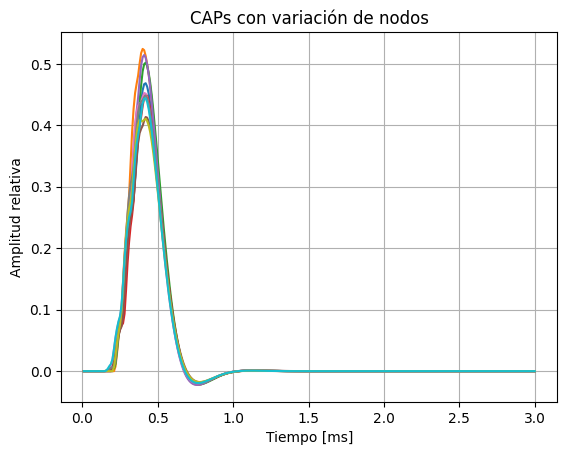

In [31]:
fig = plt.figure()
for i in range(10):
    fibras = np.array([[0,744.5,4.5,34.2],[0,0,4.5,34.2]])
    a = Entorno(nombre='Experimento_01',tiempo_registro=0.003)
    a.crear_nervio(diametro = 1500,num_fibras=6,metodo_poblacion = 'manual',array_fibras = fibras,distancia_nodos=2000,longitud=70000,porcentaje_cobertura=100,variacion_nodos = 1000)
            # a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-100,-750),(-100,-800),(100,-800),(100,-750)],pos_z = 10000,zona_influencia=z,grosor=0,funcion = funcion_trapecio)
            # a.crear_electrodo(tipo='circulo',pos_x = 0,pos_y = -800,pos_z = 20000,radio = 50,zona_influencia=z,grosor=500,funcion = funcion_trapecio)
    a.crear_electrodo(tipo='punto',pos_x = 0, pos_y = -750, pos_z = 10000, zona_influencia=10000,grosor = 0,funcion = funcion_trapecio) 
    a.crear_electrodo(tipo='punto',pos_x = 0, pos_y = -750, pos_z = 20000, zona_influencia=10000,grosor = 0,funcion = funcion_trapecio) 
    a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
    a.cap()
    vector_tiempo = np.arange(1 / a.frec_muestreo, 1 / a.frec_muestreo + a.tiempo_registro,1 / a.frec_muestreo)
    plt.plot(vector_tiempo*1000, a.electrodos[0].cap)
    print(max(a.electrodos[0].cap))
plt.title('CAPs con variación de nodos')
plt.xlabel('Tiempo [ms]')
plt.ylabel('Amplitud relativa')
#plt.legend(fontsize = 'small')
plt.grid()

fig.savefig('53_2.png',dpi=300, format="png")  

### <stan style = "color : magenta ">3. Variación de grosor  </stan>

In [45]:
# 4. Variacion de grosor

from scipy.interpolate import interp1d
arch = np.zeros((20,2))
desviacion = np.zeros((20,2))

#grosores = [0,250,500,1000,1500,1750,2000,2500,2750,3000]
grosores = np.linspace(0,3000,20)

for id,g in enumerate(grosores):
    info = np.zeros((10,2))

    for i in range(10):
        a = Entorno(nombre='Experimento_01',tiempo_registro=0.003)
        a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',distancia_nodos=2000,longitud=70000,porcentaje_cobertura=100,variacion_nodos = 0,diametro_fibra=4.5,var_diametro=1.5)
        # a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-100,-750),(-100,-800),(100,-800),(100,-750)],pos_z = 10000,zona_influencia=z,grosor=0,funcion = funcion_trapecio)
        # a.crear_electrodo(tipo='circulo',pos_x = 0,pos_y = -800,pos_z = 20000,radio = 50,zona_influencia=z,grosor=500,funcion = funcion_trapecio)
        a.crear_electrodo(tipo='punto',pos_x = 0, pos_y = -750, pos_z = 10000, zona_influencia=10000,grosor = g,funcion = funcion_trapecio) 
        a.crear_electrodo(tipo='punto',pos_x = 0, pos_y = -750, pos_z = 20000, zona_influencia=10000,grosor = g,funcion = funcion_trapecio) 
        a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
        a.cap()
        a.cap_diferencial()
        
        # Electrodo 0 -------------------
        limite = 48
        idx = 0

        # Alturas máxima, 90%, 10% y 50%
        e = a.electrodos[idx]
        alt_max = max(e.cap)
        alt_50 = max(e.cap)*0.5

        # Tiempos al 50% de altura
        vector_tiempo = np.arange(1 / a.frec_muestreo, 1 / a.frec_muestreo + a.tiempo_registro,1 / a.frec_muestreo)
        x = vector_tiempo[:limite]
        y = a.electrodos[idx].cap[:limite]
        func = interp1d(y,x)
        t1_50 = func(alt_50)*1000

        x = vector_tiempo[limite:]
        y = a.electrodos[idx].cap[limite:]
        func = interp1d(y,x)
        t2_50 = func(alt_50)*1000

        
        info[i] = [alt_max,t2_50-t1_50]
    promedio = sum(info)/10
    desv = [np.std([sub[i] for sub in info]) for i in range(2)] 
    arch[id] = list(promedio)
    desviacion[id] = list(desv)
print(list(arch))
print(list(desviacion))
#np.savetxt("info4.csv", arch, delimiter=",")

[array([0.61395506, 0.30945923]), array([0.6223396 , 0.30996999]), array([0.63799375, 0.31052532]), array([0.66007873, 0.31127775]), array([0.67784305, 0.31147183]), array([0.69121849, 0.3128425 ]), array([0.70880866, 0.31429472]), array([0.72737236, 0.31467172]), array([0.74218236, 0.31433104]), array([0.75902938, 0.31678414]), array([0.78368389, 0.31757062]), array([0.79601164, 0.31753504]), array([0.81383334, 0.31792712]), array([0.84071178, 0.31873282]), array([0.8409915 , 0.32170506]), array([0.84494937, 0.3238776 ]), array([0.84967616, 0.32359479]), array([0.86822855, 0.32551661]), array([0.87949503, 0.32615912]), array([0.88709897, 0.32995692])]
[array([0.01210266, 0.00139204]), array([0.00750977, 0.00240092]), array([0.00928697, 0.00218367]), array([0.01355313, 0.00250697]), array([0.01517675, 0.00267282]), array([0.00656876, 0.00267913]), array([0.00877914, 0.00096266]), array([0.00462459, 0.00169585]), array([0.00730833, 0.00231615]), array([0.00989795, 0.00228349]), array([0

### <stan style = "color : magenta ">4. Tipos de electrodos  </stan>

In [19]:
# 5. Tipos de electrodos - Poligono

from scipy.interpolate import interp1d
arch = np.zeros((10,3))
desviacion = np.zeros((10,3))

#zonas = [3000,4000,5000,6000,7000,8000,9000,10000,11000,12000]
porcentajes = [10,20,30,40,50,60,70,80,90,100]
for id,p in enumerate(porcentajes):
    info = np.zeros((10,3))
    for i in range(10):
        a = Entorno(nombre='Experimento_01',tiempo_registro=0.003)
        a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',distancia_nodos=2000,longitud=70000,porcentaje_cobertura=p,variacion_nodos = 0,diametro_fibra=4.5,var_diametro=1.5)
        # a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-100,-750),(-100,-800),(100,-800),(100,-750)],pos_z = 10000,zona_influencia=z,grosor=0,funcion = funcion_trapecio)
        # a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-100,-750),(-100,-800),(100,-800),(100,-750)],pos_z = 20000,zona_influencia=z,grosor=0,funcion = funcion_trapecio)
        a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-200,-750),(-200,-850),(200,-850),(200,-750)],pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-200,-750),(-200,-850),(200,-850),(200,-750)],pos_z = 30000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        # a.crear_electrodo(tipo='circulo',pos_x = 0,pos_y = -800,pos_z = 20000,radio = 50,zona_influencia=z,grosor=500,funcion = funcion_trapecio)
        a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
        a.cap()
        a.cap_diferencial()
        
        # Electrodo 0 -------------------
        limite = 62
        idx = 0

        # Alturas máxima
        e = a.electrodos[idx]
        alt_max = max(e.cap)
        alt_50 = max(e.cap)*0.5

        # Tiempos al 50% de altura
        vector_tiempo = np.arange(1 / a.frec_muestreo, 1 / a.frec_muestreo + a.tiempo_registro,1 / a.frec_muestreo)
        x = vector_tiempo[:limite]
        y = a.electrodos[idx].cap[:limite]
        func = interp1d(y,x)
        t1_50 = func(alt_50)*1000

        x = vector_tiempo[limite:]
        y = a.electrodos[idx].cap[limite:]
        func = interp1d(y,x)
        t2_50 = func(alt_50)*1000
        
        #Cantidad de fibras
        lista = a.electrodos[idx].wmax
        lista_filtrada = filter(lambda x: x != 0, lista)
        cantidad = len(list(lista_filtrada))
        
        info[i] = [alt_max,cantidad,t2_50-t1_50]
        
    promedio = sum(info)/10 # dimension 1,10
    desv = [np.std([sub[i] for sub in info]) for i in range(3)] 
    arch[id] = promedio
    desviacion[id] = desv
print(list(arch))
print(list(desviacion))
#np.savetxt("info5.csv", arch, delimiter=",")

[array([1.82173766e-02, 1.72800000e+02, 4.13047540e-01]), array([4.86163210e-02, 4.65500000e+02, 4.17056055e-01]), array([8.74785422e-02, 8.46800000e+02, 4.12212341e-01]), array([1.35954017e-01, 1.31420000e+03, 4.09882775e-01]), array([1.85458574e-01, 1.80620000e+03, 4.14665872e-01]), array([2.49399204e-01, 2.37010000e+03, 4.06831309e-01]), array([3.07692075e-01, 2.90260000e+03, 4.13588864e-01]), array([3.68322639e-01, 3.36700000e+03, 4.10990425e-01]), array([4.35876207e-01, 3.76580000e+03, 4.14233344e-01]), array([5.04304482e-01, 3.99900000e+03, 4.12871684e-01])]
[array([1.62057759e-03, 6.12862138e+00, 2.77012052e-02]), array([4.75529826e-03, 1.60452485e+01, 1.26010722e-02]), array([5.88173667e-03, 3.06718112e+01, 8.30653596e-03]), array([7.50398250e-03, 3.77327444e+01, 9.91048984e-03]), array([5.92794692e-03, 2.42973250e+01, 1.79213798e-02]), array([8.84962207e-03, 2.87904498e+01, 7.48438972e-03]), array([9.46160895e-03, 2.93264386e+01, 7.17957987e-03]), array([8.08176933e-03, 2.4633

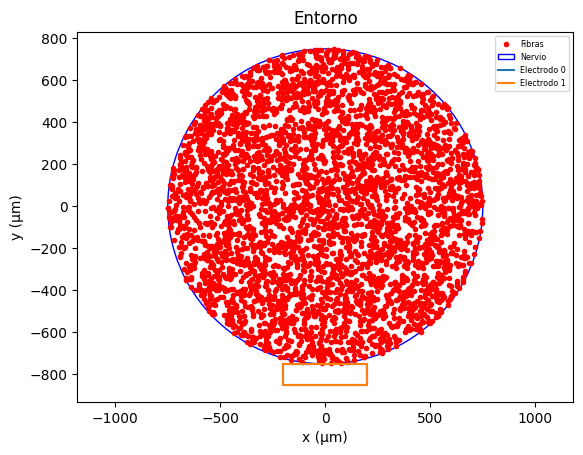

In [39]:
a = Entorno(nombre='Experimento_01',tiempo_registro=0.003)
a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',distancia_nodos=2000,longitud=70000,porcentaje_cobertura=100,variacion_nodos = 0,diametro_fibra=4.5,var_diametro=1.5)
a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-200,-750),(-200,-850),(200,-850),(200,-750)],pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-200,-750),(-200,-850),(200,-850),(200,-750)],pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        # a.crear_electrodo(tipo='circulo',pos_x = 0,pos_y = -800,pos_z = 20000,radio = 50,zona_influencia=z,grosor=500,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.cap()
a.cap_diferencial()
a.dibujar_entorno()

In [18]:
# 6. Tipos de electrodos - Circulo

from scipy.interpolate import interp1d
arch = np.zeros((10,3))
desviacion = np.zeros((10,3))

#zonas = [3000,4000,5000,6000,7000,8000,9000,10000,11000,12000]
porcentajes = [10,20,30,40,50,60,70,80,90,100]
for id,p in enumerate(porcentajes):
    info = np.zeros((10,3))
    for i in range(10):
        a = Entorno(nombre='Experimento_01',tiempo_registro=0.003)
        a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',distancia_nodos=2000,longitud=70000,porcentaje_cobertura=p,variacion_nodos = 0,diametro_fibra=4.5,var_diametro=1.5)
        # a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-100,-750),(-100,-800),(100,-800),(100,-750)],pos_z = 10000,zona_influencia=z,grosor=0,funcion = funcion_trapecio)
        # a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-100,-750),(-100,-800),(100,-800),(100,-750)],pos_z = 20000,zona_influencia=z,grosor=0,funcion = funcion_trapecio)
        a.crear_electrodo(tipo='circulo',pos_x = 0,pos_y = -950,pos_z = 20000,radio = 200,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        a.crear_electrodo(tipo='circulo',pos_x = 0,pos_y = -950,pos_z = 30000,radio = 200,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
        a.cap()
        a.cap_diferencial()
        
        # Electrodo 0 -------------------
        limite = 62
        idx = 0

        # Alturas máxima
        e = a.electrodos[idx]
        alt_max = max(e.cap)
        alt_50 = max(e.cap)*0.5

        # Tiempos al 50% de altura
        vector_tiempo = np.arange(1 / a.frec_muestreo, 1 / a.frec_muestreo + a.tiempo_registro,1 / a.frec_muestreo)
        x = vector_tiempo[:limite]
        y = a.electrodos[idx].cap[:limite]
        func = interp1d(y,x)
        t1_50 = func(alt_50)*1000

        x = vector_tiempo[limite:]
        y = a.electrodos[idx].cap[limite:]
        func = interp1d(y,x)
        t2_50 = func(alt_50)*1000
        
        #Cantidad de fibras
        lista = a.electrodos[idx].wmax
        lista_filtrada = filter(lambda x: x != 0, lista)
        cantidad = len(list(lista_filtrada))
        
        info[i] = [alt_max,cantidad,t2_50-t1_50]
        
    promedio = sum(info)/10 # dimension 1,10
    desv = [np.std([sub[i] for sub in info]) for i in range(3)] 
    arch[id] = promedio
    desviacion[id] = desv
print(list(arch))
print(list(desviacion))
np.savetxt("info6.csv", arch, delimiter=",")

[array([1.15220290e-02, 1.19000000e+02, 3.98751315e-01]), array([3.28858190e-02, 3.65000000e+02, 4.09689395e-01]), array([6.48743678e-02, 7.09500000e+02, 4.12869059e-01]), array([1.04814067e-01, 1.15620000e+03, 4.07260149e-01]), array([1.52173333e-01, 1.66450000e+03, 4.08347784e-01]), array([2.01254894e-01, 2.18150000e+03, 4.13587940e-01]), array([2.66909159e-01, 2.75000000e+03, 4.06112231e-01]), array([3.27174446e-01, 3.26670000e+03, 4.11870325e-01]), array([3.88572545e-01, 3.72110000e+03, 4.15586314e-01]), array([4.58260740e-01, 3.99900000e+03, 4.09331454e-01])]
[array([1.48212681e-03, 7.07106781e+00, 4.10647559e-02]), array([3.47580929e-03, 1.04785495e+01, 2.11654434e-02]), array([3.84447437e-03, 2.49529557e+01, 1.24520284e-02]), array([5.20620522e-03, 2.44245778e+01, 1.35922465e-02]), array([6.88064439e-03, 3.85155813e+01, 6.98522948e-03]), array([6.58137506e-03, 3.54549009e+01, 7.46779899e-03]), array([8.04797976e-03, 2.41163845e+01, 8.01596731e-03]), array([7.00871160e-03, 2.7040

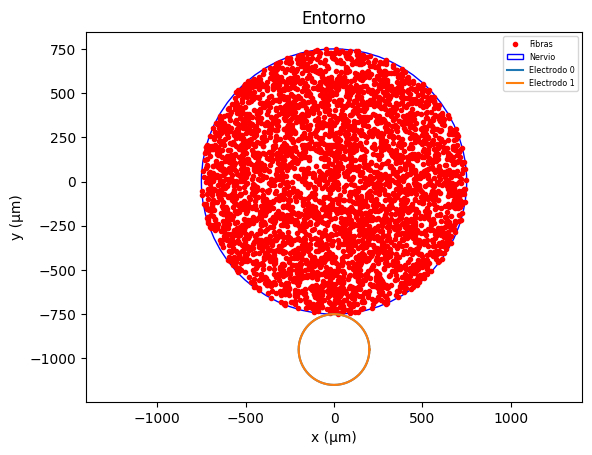

In [29]:
a = Entorno(nombre='Experimento_01',tiempo_registro=0.003)
a.crear_nervio(diametro = 1500,num_fibras=4000,metodo_poblacion = 'uniforme_con_superposicion',distancia_nodos=2000,longitud=70000,porcentaje_cobertura=100,variacion_nodos = 0,diametro_fibra=4.5,var_diametro=1.5)
# a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-100,-750),(-100,-800),(100,-800),(100,-750)],pos_z = 10000,zona_influencia=z,grosor=0,funcion = funcion_trapecio)
        # a.crear_electrodo(tipo='poligono',lista_coordenadas = [(-100,-750),(-100,-800),(100,-800),(100,-750)],pos_z = 20000,zona_influencia=z,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='circulo',pos_x = 0,pos_y = -950,pos_z = 10000,radio = 200,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='circulo',pos_x = 0,pos_y = -950,pos_z = 20000,radio = 200,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.cap()
a.cap_diferencial()
a.dibujar_entorno()

In [61]:

basico = [[0.11972202, 0.10774982, 0.5779903 , 0.0119722 , 0.39032149,
       0.05986101, 0.48676063, 0.86526902, 0.18766881, 0.37850839], [0.16899984, 0.15209986, 0.57419409, 0.01689998, 0.39044823,
       0.08449992, 0.48492767, 0.86540835, 0.18374586, 0.38048068], [0.2212049 , 0.19908441, 0.57277328, 0.02212049, 0.38842842,
       0.11060245, 0.48244224, 0.86814769, 0.18434486, 0.38570545], [0.26708965, 0.24038069, 0.57345769, 0.02670897, 0.38568498,
       0.13354483, 0.48243489, 0.86762386, 0.18777271, 0.38518897], [0.31028008, 0.27925207, 0.57024202, 0.03102801, 0.38119956,
       0.15514004, 0.47838018, 0.86850735, 0.18904246, 0.39012717], [0.35170901, 0.31653811, 0.57103732, 0.0351709 , 0.37608046,
       0.17585451, 0.47643711, 0.8749862 , 0.19495686, 0.3985491 ], [0.39039819, 0.35135837, 0.5698973 , 0.03903982, 0.37120539,
       0.19519909, 0.47382163, 0.87797708, 0.19869191, 0.40415545], [0.43191543, 0.38872389, 0.56671514, 0.04319154, 0.36395887,
       0.21595772, 0.46921247, 0.8792139 , 0.20275627, 0.41000143], [0.46901446, 0.42211302, 0.56384495, 0.04690145, 0.35817727,
       0.23450723, 0.46517947, 0.8804304 , 0.20566768, 0.41525093], [0.50127154, 0.45114438, 0.56444094, 0.05012715, 0.3519534 ,
       0.25063577, 0.46282254, 0.88543115, 0.21248754, 0.42260861]]

error_basico = [[0.00276416, 0.00248775, 0.00363018, 0.00027642, 0.00352368,
       0.00138208, 0.00371768, 0.01091873, 0.00472874, 0.0117113 ], [0.0026833 , 0.00241497, 0.00291808, 0.00026833, 0.00251609,
       0.00134165, 0.00279549, 0.00671325, 0.0033858 , 0.00727975], [0.00353616, 0.00318255, 0.00386105, 0.00035362, 0.00320558,
       0.00176808, 0.00383831, 0.00773611, 0.0028101 , 0.00797437], [0.00738737, 0.00664863, 0.00521878, 0.00073874, 0.00423763,
       0.00369368, 0.00375787, 0.00836394, 0.00511384, 0.00906005], [0.00526471, 0.00473824, 0.00296949, 0.00052647, 0.0020671 ,
       0.00263236, 0.00216063, 0.00706766, 0.00319952, 0.00745256], [0.00910952, 0.00819857, 0.00367268, 0.00091095, 0.00383599,
       0.00455476, 0.00383362, 0.00743315, 0.00351343, 0.00970712], [0.00676122, 0.0060851 , 0.0031931 , 0.00067612, 0.00306144,
       0.00338061, 0.00328509, 0.00808116, 0.00236808, 0.00825519], [0.00745295, 0.00670765, 0.00388732, 0.00074529, 0.00246136,
       0.00372647, 0.00327457, 0.00919096, 0.0025367 , 0.00924895], [0.00625344, 0.00562809, 0.00409026, 0.00062534, 0.00291477,
       0.00312672, 0.00386168, 0.00438739, 0.00188461, 0.00436975], [0.00937776, 0.00843999, 0.00250377, 0.00093778, 0.00347747,
       0.00468888, 0.00289618, 0.00417958, 0.00224921, 0.00495588]]



sin_super = [[0.11748243, 0.10573419, 0.5809158 , 0.01174824, 0.39387025,
       0.05874122, 0.48871422, 0.87405748, 0.18704556, 0.38534325], [0.16852667, 0.15167401, 0.57827564, 0.01685267, 0.39269565,
       0.08426334, 0.48642092, 0.86891447, 0.18557999, 0.38249355], [0.21532358, 0.19379122, 0.57904267, 0.02153236, 0.39131853,
       0.10766179, 0.48670301, 0.87893602, 0.18772414, 0.39223301], [0.26110008, 0.23499007, 0.5785837 , 0.02611001, 0.38723005,
       0.13055004, 0.48480959, 0.87706716, 0.19135365, 0.39225757], [0.30535377, 0.27481839, 0.57659481, 0.03053538, 0.38211751,
       0.15267688, 0.48166099, 0.87927851, 0.19447731, 0.39761753], [0.34652508, 0.31187257, 0.57333631, 0.03465251, 0.37840222,
       0.17326254, 0.47866424, 0.88426472, 0.19493409, 0.40560048], [0.3876754 , 0.34890786, 0.57216857, 0.03876754, 0.37300173,
       0.1938377 , 0.47587734, 0.88189126, 0.19916683, 0.40601392], [0.42455945, 0.38210351, 0.56840223, 0.04245595, 0.36582956,
       0.21227973, 0.47091581, 0.88390167, 0.20257267, 0.41298586], [0.4632227 , 0.41690043, 0.56801801, 0.04632227, 0.36083998,
       0.23161135, 0.46894029, 0.8862202 , 0.20717803, 0.41727991], [0.49535355, 0.44581819, 0.56493548, 0.04953535, 0.35343053,
       0.24767677, 0.46388833, 0.88867059, 0.21150496, 0.42478227]]

error_sin_super = [[0.00359386, 0.00323448, 0.00623289, 0.00035939, 0.00420724,
       0.00179693, 0.00377162, 0.00949087, 0.00847601, 0.00785014],[0.00458282, 0.00412454, 0.00521377, 0.00045828, 0.00306766,
       0.00229141, 0.0036855 , 0.00887598, 0.00529542, 0.01081381], [0.00602021, 0.00541819, 0.0048193 , 0.00060202, 0.00346336,
       0.00301011, 0.00417121, 0.00919166, 0.00395517, 0.00923358], [0.00417827, 0.00376045, 0.00304246, 0.00041783, 0.00180224,
       0.00208914, 0.00315609, 0.00568651, 0.00285084, 0.00702934], [0.00763307, 0.00686977, 0.0043588 , 0.00076331, 0.00252462,
       0.00381654, 0.00282309, 0.00816408, 0.00345155, 0.00815011], [0.00570186, 0.00513168, 0.00344948, 0.00057019, 0.00257717,
       0.00285093, 0.00231719, 0.00922959, 0.00325632, 0.00862726], [0.00730919, 0.00657827, 0.00285568, 0.00073092, 0.00223035,
       0.0036546 , 0.0023452 , 0.00961646, 0.00293869, 0.01016122], [0.00687936, 0.00619143, 0.00298237, 0.00068794, 0.00324688,
       0.00343968, 0.0027698 , 0.00634771, 0.00408919, 0.00604493], [0.01045922, 0.0094133 , 0.00267577, 0.00104592, 0.00196424,
       0.00522961, 0.00250551, 0.00848847, 0.00165447, 0.00790398], [0.00686599, 0.00617939, 0.00322518, 0.0006866 , 0.00305702,
       0.00343299, 0.00305581, 0.00893028, 0.00172126, 0.00893904]]



var_nodos = [[0.60126612, 0.54113951, 0.38043605, 0.06012661, 0.16632338,
       0.30063306, 0.25312564, 0.56351303, 0.21411267, 0.3103874 ], [0.61153422, 0.5503808 , 0.41398632, 0.06115342, 0.16661867,
       0.30576711, 0.2534517 , 0.56259253, 0.24736765, 0.30914082], [0.60924984, 0.54832486, 0.40105273, 0.06092498, 0.16701645,
       0.30462492, 0.25365664, 0.56253923, 0.23403628, 0.30888259], [0.60943291, 0.54848962, 0.40031832, 0.06094329, 0.16651704,
       0.30471645, 0.25339376, 0.56243528, 0.23380128, 0.30904152], [0.60474716, 0.54427244, 0.3924542 , 0.06047472, 0.16700612,
       0.30237358, 0.25375563, 0.56334627, 0.22544808, 0.30959063], [0.61107792, 0.54997013, 0.40801967, 0.06110779, 0.16677866,
       0.30553896, 0.25354982, 0.56294928, 0.24124101, 0.30939946], [0.61194843, 0.55075359, 0.40847882, 0.06119484, 0.16682413,
       0.30597422, 0.25373447, 0.56259648, 0.2416547 , 0.30886201],[0.61118491, 0.55006642, 0.38141333, 0.06111849, 0.16658206,
       0.30559246, 0.25349647, 0.56306104, 0.21483126, 0.30956457],[0.60332196, 0.54298976, 0.39218067, 0.0603322 , 0.1668937 ,
       0.30166098, 0.25397559, 0.56396915, 0.22528697, 0.30999356], [0.6104441 , 0.54939969, 0.38471408, 0.06104441, 0.16665997,
       0.30522205, 0.25354053, 0.56310506, 0.21805411, 0.30956453]]

var_nodos2 = [[0.60551296, 0.54496166, 0.3820207 , 0.0605513 , 0.16686196,
       0.30275648, 0.25342493, 0.56327767, 0.21515874, 0.30985274], [0.610065  , 0.5490585 , 0.38049367, 0.0610065 , 0.16677313,
       0.3050325 , 0.25353839, 0.56286323, 0.21372054, 0.30932485], [0.60864691, 0.54778221, 0.36934727, 0.06086469, 0.16627289,
       0.30432345, 0.25331747, 0.56444262, 0.20307438, 0.31112515], [0.61276379, 0.55148741, 0.38664772, 0.06127638, 0.16637205,
       0.30638189, 0.2529543 , 0.56218232, 0.22027567, 0.30922802], [0.61043843, 0.54939459, 0.37027409, 0.06104384, 0.16622695,
       0.30521922, 0.25308415, 0.56309574, 0.20404714, 0.31001159], [0.61141267, 0.5502714 , 0.39715985, 0.06114127, 0.16667112,
       0.30570634, 0.25345952, 0.56135826, 0.23048873, 0.30789873], [0.60952243, 0.54857019, 0.3802503 , 0.06095224, 0.16684877,
       0.30476121, 0.25359211, 0.56231633, 0.21340153, 0.30872422], [0.60960154, 0.54864139, 0.385431  , 0.06096015, 0.16649526,
       0.30480077, 0.25317608, 0.56318654, 0.21893574, 0.31001045], [0.60860662, 0.54774596, 0.39358389, 0.06086066, 0.16684722,
       0.30430331, 0.25353175, 0.56344253, 0.22673667, 0.30991078], [0.61229471, 0.55106524, 0.38457295, 0.06122947, 0.16711706,
       0.30614735, 0.25369139, 0.56286059, 0.21745589, 0.30916921]]

error_var_nodos2 = [[0.01358451, 0.01222606, 0.03300106, 0.00135845, 0.00118496,
       0.00679225, 0.0009649 , 0.00156945, 0.03231375, 0.00160507], [0.01226535, 0.01103881, 0.0255483 , 0.00122653, 0.00150713,
       0.00613267, 0.00158253, 0.0029409 , 0.02561546, 0.00229859], [0.01024735, 0.00922261, 0.02728294, 0.00102473, 0.00095219,
       0.00512367, 0.00115118, 0.00326564, 0.02721796, 0.00270612], [0.00697724, 0.00627952, 0.02972708, 0.00069772, 0.0014124 ,
       0.00348862, 0.0014312 , 0.00211185, 0.02997369, 0.00137654], [0.00730998, 0.00657898, 0.02946111, 0.000731  , 0.00103966,
       0.00365499, 0.00066395, 0.00273459, 0.02937649, 0.00298133], [0.00529921, 0.00476929, 0.02956187, 0.00052992, 0.00134442,
       0.00264961, 0.00140099, 0.00188884, 0.02943976, 0.00135521], [0.00995649, 0.00896084, 0.02645844, 0.00099565, 0.00106793,
       0.00497825, 0.00076177, 0.00183115, 0.02636169, 0.00178572], [0.00749157, 0.00674241, 0.02705284, 0.00074916, 0.00106172,
       0.00374578, 0.00112017, 0.00245623, 0.02714246, 0.00183   ], [0.00875278, 0.0078775 , 0.03337757, 0.00087528, 0.00072238,
       0.00437639, 0.00067673, 0.00212281, 0.03366617, 0.00233257], [0.00505201, 0.00454681, 0.02035027, 0.0005052 , 0.00116593,
       0.00252601, 0.0010604 , 0.00201372, 0.02054951, 0.00131841]]



con_grosor = [[0.60879847, 0.54791862, 0.3776506 , 0.06087985, 0.166338  ,
       0.30439923, 0.25310896, 0.56320303, 0.2113126 , 0.31009407], [0.61022125, 0.54919912, 0.38960046, 0.06102212, 0.16612587,
       0.30511062, 0.25319333, 0.56374853, 0.22347459, 0.3105552 ], [0.61556482, 0.55400834, 0.3859337 , 0.06155648, 0.1668106 ,
       0.30778241, 0.25397468, 0.56511855, 0.2191231 , 0.31114387], [0.61680762, 0.55512686, 0.36856172, 0.06168076, 0.16607523,
       0.30840381, 0.25306616, 0.56235674, 0.20248649, 0.30929059], [0.62925843, 0.56633259, 0.38585447, 0.06292584, 0.16582634,
       0.31462922, 0.25349261, 0.56496857, 0.22002814, 0.31147595], [0.62777214, 0.56499493, 0.38192565, 0.06277721, 0.16609827,
       0.31388607, 0.25373807, 0.56532083, 0.21582738, 0.31158277], [0.63289993, 0.56960994, 0.39732365, 0.06328999, 0.16518909,
       0.31644997, 0.2529123 , 0.56410308, 0.23213456, 0.31119078], [0.6486413 , 0.58377717, 0.38372589, 0.06486413, 0.16462652,
       0.32432065, 0.2526555 , 0.56243719, 0.21909937, 0.30978169], [0.65227838, 0.58705054, 0.39550452, 0.06522784, 0.16481259,
       0.32613919, 0.25269033, 0.56329488, 0.23069193, 0.31060455], [0.66087626, 0.59478864, 0.40180585, 0.06608763, 0.16340292,
       0.33043813, 0.25151884, 0.56276176, 0.23840293, 0.31124292]]

error_con_grosor = [[0.00875186, 0.00787668, 0.02881464, 0.00087519, 0.0008409 ,
       0.00437593, 0.00097869, 0.00151255, 0.02855903, 0.00100675], [0.0057813 , 0.00520317, 0.03030727, 0.00057813, 0.00105614,
       0.00289065, 0.00109331, 0.00268793, 0.03084005, 0.00227776], [0.01345257, 0.01210731, 0.03001387, 0.00134526, 0.00170518,
       0.00672629, 0.00131784, 0.0022399 , 0.02993317, 0.00196549], [0.00655075, 0.00589568, 0.02633083, 0.00065508, 0.00092589,
       0.00327538, 0.00114239, 0.00295593, 0.02654115, 0.00284106], [0.00869929, 0.00782936, 0.03219154, 0.00086993, 0.0009432 ,
       0.00434964, 0.00100017, 0.00344648, 0.0317492 , 0.00293182], [0.00776453, 0.00698807, 0.03002797, 0.00077645, 0.00118111,
       0.00388226, 0.00091701, 0.00216974, 0.02913171, 0.00201208], [0.01042394, 0.00938154, 0.03928048, 0.00104239, 0.00157745,
       0.00521197, 0.00142435, 0.00251793, 0.03937186, 0.00179111], [0.0151561 , 0.01364049, 0.02851308, 0.00151561, 0.00099642,
       0.00757805, 0.00109549, 0.00268534, 0.02907945, 0.0018793 ], [0.0102562 , 0.00923058, 0.03999434, 0.00102562, 0.00122255,
       0.0051281 , 0.00108757, 0.00274725, 0.04028203, 0.00211551], [0.01266427, 0.01139785, 0.03608313, 0.00126643, 0.00072656,
       0.00633214, 0.00073289, 0.00184945, 0.03606538, 0.00164539]]



elec_pol = [[0.14304171, 0.12873754, 0.57505761, 0.01430417, 0.39281186,
       0.07152086, 0.48684354, 0.86462939, 0.18224575, 0.37778585], [0.20182657, 0.18164391, 0.57339688, 0.02018266, 0.39009312,
       0.10091328, 0.48405019, 0.87098397, 0.18330375, 0.38693378], [0.25701253, 0.23131128, 0.57378768, 0.02570125, 0.38601754,
       0.12850627, 0.48292253, 0.87378408, 0.18777014, 0.39086155], [0.31139828, 0.28025845, 0.57045995, 0.03113983, 0.38398967,
       0.15569914, 0.47965905, 0.87012881, 0.18647028, 0.39046976], [0.36792551, 0.33113296, 0.57215728, 0.03679255, 0.37968464,
       0.18396276, 0.47877468, 0.86895904, 0.19247264, 0.39018436], [0.41106804, 0.36996123, 0.57041143, 0.0411068 , 0.37374012,
       0.20553402, 0.47510766, 0.87475522, 0.19667131, 0.39964756], [0.46031787, 0.41428608, 0.56976085, 0.04603179, 0.36822013,
       0.23015893, 0.47230956, 0.8796579 , 0.20154072, 0.40734834], [0.50093407, 0.45084066, 0.56453018, 0.05009341, 0.36083506,
       0.25046704, 0.46648176, 0.87916084, 0.20369512, 0.41267909], [0.5483734 , 0.49353606, 0.56299633, 0.05483734, 0.35319213,
       0.2741867 , 0.46247922, 0.88212479, 0.2098042 , 0.41964556], [0.58683826, 0.52815444, 0.56136161, 0.05868383, 0.3461195 ,
       0.29341913, 0.4588371 , 0.88541093, 0.21524211, 0.42657383]]

error_elec_pol = [[0.00458521, 0.00412669, 0.00478177, 0.00045852, 0.00435204,
       0.0022926 , 0.00356868, 0.01689081, 0.00529377, 0.01828816], [0.00325086, 0.00292577, 0.00623995, 0.00032509, 0.00370389,
       0.00162543, 0.00469189, 0.0121344 , 0.00509108, 0.00950221], [0.00699015, 0.00629114, 0.00439099, 0.00069902, 0.00266348,
       0.00349508, 0.00396292, 0.0103588 , 0.00419203, 0.0125784 ], [0.00630486, 0.00567438, 0.00536555, 0.00063049, 0.00314437,
       0.00315243, 0.00446959, 0.00900362, 0.00337582, 0.00805477], [0.00842523, 0.00758271, 0.0027168 , 0.00084252, 0.00361157,
       0.00421262, 0.00250469, 0.01076133, 0.00450336, 0.01176188], [0.00801802, 0.00721622, 0.00366635, 0.0008018 , 0.00186986,
       0.00400901, 0.00274237, 0.00595589, 0.00296283, 0.00589773], [0.00893968, 0.00804571, 0.00332144, 0.00089397, 0.00143336,
       0.00446984, 0.0022079 , 0.00556256, 0.00314165, 0.00536625], [0.00988786, 0.00889908, 0.00328186, 0.00098879, 0.00347071,
       0.00494393, 0.00343216, 0.00626707, 0.00160462, 0.00593973], [0.0123147 , 0.01108323, 0.00231602, 0.00123147, 0.00192658,
       0.00615735, 0.00174626, 0.00353514, 0.00186943, 0.00349525], [0.00828564, 0.00745708, 0.00430138, 0.00082856, 0.00263223,
       0.00414282, 0.00281225, 0.00576894, 0.00269642, 0.00383788]]



elec_circ = [[0.12752369, 0.11477132, 0.57811564, 0.01275237, 0.39205379,
       0.06376185, 0.48756784, 0.87514358, 0.18606185, 0.38757574], [0.18229452, 0.16406507, 0.57461028, 0.01822945, 0.38859769,
       0.09114726, 0.48348216, 0.8685371 , 0.18601258, 0.38505494], [0.23101441, 0.20791297, 0.57451992, 0.02310144, 0.38632519,
       0.1155072 , 0.48202455, 0.87109931, 0.18819473, 0.38907476], [0.28322404, 0.25490164, 0.57185694, 0.0283224 , 0.38433136,
       0.14161202, 0.48105962, 0.86821434, 0.18752558, 0.38715472], [0.33186071, 0.29867464, 0.57062746, 0.03318607, 0.37867384,
       0.16593036, 0.47738323, 0.87174597, 0.19195362, 0.39436274], [0.37266695, 0.33540026, 0.56906374, 0.0372667 , 0.37331516,
       0.18633348, 0.47442815, 0.87309206, 0.19574858, 0.39866391], [0.42122475, 0.37910228, 0.56890926, 0.04212248, 0.37010701,
       0.21061238, 0.47276289, 0.87572454, 0.19880225, 0.40296165], [0.457587  , 0.4118283 , 0.56553185, 0.0457587 , 0.363488  ,
       0.2287935 , 0.46797243, 0.88018008, 0.20204384, 0.41220765], [0.49398321, 0.44458489, 0.56515567, 0.04939832, 0.3559704 ,
       0.2469916 , 0.46477363, 0.88691596, 0.20918527, 0.42214233], [0.53256778, 0.47931101, 0.56274362, 0.05325678, 0.34965858,
       0.26628389, 0.46094126, 0.88550367, 0.21308504, 0.42456241]]

error_elec_circ = [[0.00201575, 0.00181417, 0.00660614, 0.00020157, 0.00300774,
       0.00100787, 0.00371248, 0.00886017, 0.00522245, 0.00758944], [0.00504165, 0.00453749, 0.0027942 , 0.00050417, 0.00474152,
       0.00252083, 0.00317333, 0.00997763, 0.00467   , 0.01110587], [0.00632175, 0.00568958, 0.00247346, 0.00063218, 0.00218924,
       0.00316088, 0.00129771, 0.00821728, 0.00250854, 0.00853841], [0.00588906, 0.00530015, 0.00211705, 0.00058891, 0.00266593,
       0.00294453, 0.00289606, 0.00666389, 0.0025787 , 0.00912985], [0.00563088, 0.00506779, 0.00523032, 0.00056309, 0.00328716,
       0.00281544, 0.0035426 , 0.00772916, 0.00483009, 0.00560988], [0.00849666, 0.00764699, 0.00337994, 0.00084967, 0.00209893,
       0.00424833, 0.00220872, 0.0075559 , 0.00352167, 0.00808692], [0.01112224, 0.01001001, 0.00274806, 0.00111222, 0.00356148,
       0.00556112, 0.0026459 , 0.00777116, 0.00344716, 0.00796822], [0.01342162, 0.01207946, 0.00319665, 0.00134216, 0.0020072 ,
       0.00671081, 0.00205369, 0.00842508, 0.0029526 , 0.00758945], [0.01208708, 0.01087837, 0.00293896, 0.00120871, 0.00272414,
       0.00604354, 0.00251072, 0.00667801, 0.00272856, 0.00582289], [0.00806114, 0.00725502, 0.00313541, 0.00080611, 0.00121179,
       0.00403057, 0.00196792, 0.00626872, 0.00254013, 0.00592281]]



zonas = [3000,4000,5000,6000,7000,8000,9000,10000,11000,12000]

variacion_de_nodos = [0,100,200,300,400,500,600,700,800,900]

grosores = [0,50,100,150,200,250,300,350,400,500]

### <stan style = "color : magenta "> Datos nuevos! :D </stan>

In [46]:
basico = [[5.84936821e-03, 7.85000000e+01, 4.11544418e-01], [2.12694520e-02, 2.91700000e+02, 4.18217566e-01], [4.87105299e-02, 6.28800000e+02, 4.16126381e-01], [8.40032879e-02, 1.04910000e+03, 4.09762679e-01], 
          [1.27328672e-01, 1.54860000e+03, 4.10806673e-01], [1.79801834e-01, 2.10620000e+03, 4.07573215e-01], [2.35653441e-01, 2.68430000e+03, 4.09947563e-01], [2.95170660e-01, 3.22540000e+03, 4.11339357e-01],
         [3.64358004e-01, 3.70950000e+03, 4.11188379e-01], [4.28391747e-01, 3.99900000e+03, 4.07946270e-01]]

error_basico = [[1.06140680e-03, 6.11964051e+00, 5.59437022e-02], [2.35358489e-03, 1.67573864e+01, 2.31929720e-02],
                [2.84633534e-03, 1.58669468e+01, 2.06098275e-02], [2.79537570e-03, 3.06380482e+01, 1.79334962e-02],
                [4.56025415e-03, 1.90063147e+01, 1.04741309e-02], [3.89499287e-03, 2.67536913e+01, 7.55830089e-03], [5.47208813e-03, 2.16704868e+01, 1.01825956e-02],
                [9.45305123e-03, 2.13457256e+01, 5.93772703e-03], [5.61485437e-03, 2.04022058e+01, 6.41108457e-03], [0.01074306, 0 , 0.00621225]]

sin_super = [[5.28424666e-03, 7.59000000e+01, 4.47685429e-01], [2.19386316e-02, 2.90300000e+02, 4.07685555e-01], [4.99313086e-02, 6.35100000e+02, 4.00524056e-01],
             [8.49244161e-02, 1.05240000e+03, 4.03081027e-01], [1.28669767e-01, 1.54200000e+03, 4.02423070e-01], [1.77976726e-01, 2.10980000e+03, 4.10966860e-01],
            [2.35523130e-01, 2.69640000e+03, 4.12952689e-01], [2.94961522e-01, 3.22460000e+03, 4.13092447e-01], [3.57577168e-01, 3.69870000e+03, 4.10595118e-01],
             [4.22413641e-01, 3.99900000e+03, 4.14425557e-01]]

error_sin_super = [[9.56798372e-04, 6.53375849e+00, 8.40482168e-02], [1.93869141e-03, 1.55695215e+01, 3.37995465e-02], [2.92430964e-03, 1.84577897e+01, 1.60349043e-02],
                   [3.59333470e-03, 2.44916312e+01, 1.57887825e-02], [4.22184064e-03, 3.43685903e+01, 7.61447457e-03], [5.50278985e-03, 2.66825786e+01, 6.80134146e-03],
                   [6.04102373e-03, 2.91073874e+01, 8.25386542e-03], [8.86636153e-03, 2.05825169e+01, 7.56532691e-03], [4.92573969e-03, 1.05171289e+01, 8.39646075e-03],
                   [0.00445195, 0.        , 0.00747942]]

elec_pol = [[1.82173766e-02, 1.72800000e+02, 4.13047540e-01], [4.86163210e-02, 4.65500000e+02, 4.17056055e-01], [8.74785422e-02, 8.46800000e+02, 4.12212341e-01],
            [1.35954017e-01, 1.31420000e+03, 4.09882775e-01], [1.85458574e-01, 1.80620000e+03, 4.14665872e-01], [2.49399204e-01, 2.37010000e+03, 4.06831309e-01],
            [3.07692075e-01, 2.90260000e+03, 4.13588864e-01], [3.68322639e-01, 3.36700000e+03, 4.10990425e-01], [4.35876207e-01, 3.76580000e+03, 4.14233344e-01],
            [5.04304482e-01, 3.99900000e+03, 4.12871684e-01]]

error_elec_pol = [[1.62057759e-03, 6.12862138e+00, 2.77012052e-02], [4.75529826e-03, 1.60452485e+01, 1.26010722e-02], [5.88173667e-03, 3.06718112e+01, 8.30653596e-03],
                  [7.50398250e-03, 3.77327444e+01, 9.91048984e-03], [5.92794692e-03, 2.42973250e+01, 1.79213798e-02], [8.84962207e-03, 2.87904498e+01, 7.48438972e-03],
                  [9.46160895e-03, 2.93264386e+01, 7.17957987e-03], [8.08176933e-03, 2.46333108e+01, 7.23226403e-03], [9.94890123e-03, 1.20979337e+01, 1.03273793e-02],
                  [0.01409448, 0.        , 0.00738711]]

elec_circ = [[1.15220290e-02, 1.19000000e+02, 3.98751315e-01], [3.28858190e-02, 3.65000000e+02, 4.09689395e-01], [6.48743678e-02, 7.09500000e+02, 4.12869059e-01],
             [1.04814067e-01, 1.15620000e+03, 4.07260149e-01], [1.52173333e-01, 1.66450000e+03, 4.08347784e-01], [2.01254894e-01, 2.18150000e+03, 4.13587940e-01],
             [2.66909159e-01, 2.75000000e+03, 4.06112231e-01], [3.27174446e-01, 3.26670000e+03, 4.11870325e-01], [3.88572545e-01, 3.72110000e+03, 4.15586314e-01],
             [4.58260740e-01, 3.99900000e+03, 4.09331454e-01]]

error_elec_circ = [[1.48212681e-03, 7.07106781e+00, 4.10647559e-02], [3.47580929e-03, 1.04785495e+01, 2.11654434e-02], [3.84447437e-03, 2.49529557e+01, 1.24520284e-02], 
                  [5.20620522e-03, 2.44245778e+01, 1.35922465e-02], [6.88064439e-03, 3.85155813e+01, 6.98522948e-03], [6.58137506e-03, 3.54549009e+01, 7.46779899e-03],
                  [8.04797976e-03, 2.41163845e+01, 8.01596731e-03], [7.00871160e-03, 2.70408950e+01, 9.27783821e-03], [1.00180428e-02, 1.32623527e+01, 7.48255689e-03],
                  [0.01077447, 0.        , 0.01115467]]

con_grosor = [[0.61234006, 0.55110606, 0.37198624, 0.06123401, 0.16663597,
       0.30617003, 0.25340964, 0.56296926, 0.20535027, 0.30955962], [0.63622934, 0.57260641, 0.398055  , 0.06362293, 0.16535543,
       0.31811467, 0.25328972, 0.56597285, 0.23269957, 0.31268313], [0.6722237 , 0.60500133, 0.38351724, 0.06722237, 0.16352103,
       0.33611185, 0.25196182, 0.56392228, 0.21999622, 0.31196046], [0.71655005, 0.64489504, 0.37883123, 0.071655  , 0.16104519,
       0.35827502, 0.25075996, 0.5649041 , 0.21778604, 0.31414414], [0.75216364, 0.67694727, 0.37176698, 0.07521636, 0.15978147,
       0.37608182, 0.2504456 , 0.56699465, 0.21198551, 0.31654905], [0.78923708, 0.71031338, 0.39616944, 0.07892371, 0.15715935,
       0.39461854, 0.24911705, 0.56649625, 0.23901009, 0.31737919], [0.82931056, 0.74637951, 0.41698955, 0.08293106, 0.15509272,
       0.41465528, 0.24782835, 0.56571512, 0.26189682, 0.31788677], [0.84573965, 0.76116568, 0.39073614, 0.08457396, 0.15236584,
       0.42286982, 0.24617102, 0.56808647, 0.2383703 , 0.32191546], [0.86537422, 0.7788368 , 0.40144587, 0.08653742, 0.14946761,
       0.43268711, 0.24479519, 0.57085662, 0.25197826, 0.32606143], [0.8850667 , 0.79656003, 0.41343159, 0.08850667, 0.14636388,
       0.44253335, 0.24230742, 0.57111574, 0.26706772, 0.32880832]]

error_con_grosor = [[0.00655379, 0.00589841, 0.02342753, 0.00065538, 0.001187  ,
       0.0032769 , 0.00107405, 0.00222579, 0.02336136, 0.00152036], [0.00788794, 0.00709915, 0.03580338, 0.00078879, 0.00074539,
       0.00394397, 0.00121687, 0.00146967, 0.0360038 , 0.00140116], [0.00991906, 0.00892716, 0.0408973 , 0.00099191, 0.00065602,
       0.00495953, 0.00060766, 0.00254355, 0.04115642, 0.00210312], [0.00729811, 0.0065683 , 0.04268802, 0.00072981, 0.00081162,
       0.00364905, 0.00070369, 0.00282757, 0.0423773 , 0.00239596], [0.00876822, 0.0078914 , 0.04055831, 0.00087682, 0.00086443,
       0.00438411, 0.00107429, 0.00205709, 0.04080715, 0.001702  ], [0.00853686, 0.00768317, 0.05157878, 0.00085369, 0.00068906,
       0.00426843, 0.00102999, 0.00182035, 0.05200612, 0.00180853], [0.01096648, 0.00986983, 0.04641364, 0.00109665, 0.00095498,
       0.00548324, 0.00085653, 0.00196007, 0.04682731, 0.00184495], [0.01379381, 0.01241442, 0.04211459, 0.00137938, 0.00077676,
       0.0068969 , 0.00115066, 0.00249974, 0.04260955, 0.00187232], [0.01227859, 0.01105073, 0.03669985, 0.00122786, 0.00085607,
       0.0061393 , 0.00088447, 0.00228759, 0.03692885, 0.00213312], [0.0157894 , 0.01421046, 0.02857884, 0.00157894, 0.00107029,
       0.0078947 , 0.00118277, 0.00212595, 0.02898163, 0.00113092]]

con_grosor2 = [[0.60477278, 0.3096296 ], [0.63547749, 0.31102234], [0.65891625, 0.31232898], [0.68614837, 0.3139759 ],
               [0.72004089, 0.31429216], [0.75184705, 0.31496365], [0.7858765, 0.3180628], [0.80265439, 0.31824839],
               [0.82492022, 0.32124739], [0.84944891, 0.32151948], [0.8666631 , 0.32282755], [0.88527433, 0.3264178 ],
               [0.90243412, 0.32986905], [0.91906968, 0.33243159], [0.93374976, 0.33373654], [0.95176225, 0.33632616],
               [0.97035868, 0.34032002], [0.98555099, 0.34202312], [1.0084642 , 0.34638452], [1.02634269, 0.34877486]]
error_con_grosor2 = [[0.00742139, 0.00237993], [0.0096039 , 0.00191571], [0.00896254, 0.00265785], [0.01333522, 0.001768  ],
                     [0.00815518, 0.00161218], [0.01255689, 0.00261556], [0.01133567, 0.00185823], [0.01167422, 0.00144534],
                     [0.00960072, 0.00224352], [0.01269763, 0.00228453], [0.01194463, 0.0014844 ], [0.01239762, 0.00251015],
                     [0.01246062, 0.00144961], [0.01140224, 0.00142596], [0.01220007, 0.00167654], [0.01522094, 0.00160679],
                     [0.00828929, 0.00163488], [0.0098599 , 0.00269838], [0.01129414, 0.00174106], [0.01181413, 0.00261692]]

con_grosor3 = [[0.60924144, 0.31030324], [0.64142359, 0.30960821], [0.67490536, 0.3112918 ], [0.71500246, 0.31346177],
 [0.74990254, 0.31683342], [0.79099237, 0.31596596], [0.82278894, 0.31935055], [0.84399356, 0.32141093],
 [0.87112289, 0.32413113], [0.8837339 , 0.32809444]]

error_con_grosor3 = [[0.00587687, 0.00286845], [0.00913367, 0.00219778], [0.00761741, 0.001716  ], [0.01040528, 0.00202226],
 [0.00995977, 0.00177427], [0.01075226, 0.00173104], [0.01204717, 0.00114944], [0.01234176, 0.00177308],
 [0.01401644, 0.00219033], [0.01188199, 0.00234095]]

con_grosor4 = [[0.60503814, 0.31055932], [0.63488541, 0.31150562], [0.65994281, 0.3118592 ], [0.69152506, 0.31120152],
 [0.71970535, 0.31502143], [0.7525945, 0.3154105], [0.77521206, 0.31661738], [0.80824385, 0.31824199],
 [0.83874791, 0.31937874], [0.84519965, 0.32152329], [0.86426912, 0.32293348], [0.877913  , 0.32809703],
 [0.89361552, 0.33111311], [0.91880129, 0.33197601], [0.93541307, 0.33503285], [0.95241913, 0.33771648],
 [0.96852762, 0.34061193], [0.98959513, 0.34302862], [1.0094899 , 0.34582446], [1.02919242, 0.34828669]]
error_con_grosor4 = [[0.01029382, 0.00235048], [0.00796217, 0.00186576], [0.00936352, 0.00303047], [0.01037218, 0.00102471],
 [0.01270912, 0.00155816], [0.00969358, 0.00191345], [0.01085651, 0.00162231], [0.00518222, 0.00204435],
 [0.01326026, 0.00214974], [0.01091745, 0.00202629], [0.00965693, 0.00272981], [0.00764951, 0.00178696],
 [0.01129727, 0.00167772], [0.01340814, 0.00146082], [0.01135624, 0.00283976], [0.0092842, 0.0016727],
 [0.01025894, 0.00159409], [0.01381735, 0.00168738], [0.00815056, 0.00133346], [0.01239838, 0.00247306]]

con_grosor5 = [[0.44209339, 0.3045833 ], [0.45799566, 0.30547866], [0.46434645, 0.30891186],
               [0.47575274, 0.31125645], [0.48197911, 0.31187494], [0.49703716, 0.31561024],
               [0.50431333, 0.31797209], [0.51994133, 0.31997031], [0.53298705, 0.32132066],
               [0.54829506, 0.32338833], [0.55868761, 0.32669835], [0.56930903, 0.32961613],
               [0.58672079, 0.3310698 ], [0.59814107, 0.33464569], [0.61654908, 0.33555756],
               [0.62934812, 0.33792568], [0.64375578, 0.34115487], [0.66037995, 0.34341953],
               [0.67730444, 0.3468593 ], [0.68713683, 0.34921551]]
error_con_grosor5 = [[0.00732331, 0.00261701], [0.00734342, 0.00212327], [0.00656282, 0.00194888],
                     [0.00771021, 0.00224201], [0.00629708, 0.00276113], [0.00691672, 0.00207643],
                     [0.01129145, 0.00215051], [0.00512076, 0.00143824], [0.00603442, 0.00168368],
                     [0.00724081, 0.00164405], [0.00779605, 0.00214279], [0.00443588, 0.00120868],
                     [0.00603232, 0.00219535], [0.00807745, 0.00178947], [0.00817609, 0.00211126],
                     [0.00864405, 0.00160679], [0.00587854, 0.00143043], [0.00726573, 0.00178417],
                     [0.00995819, 0.00252931], [0.00925482, 0.00242653]]

con_grosor6 = [[1.23781237, 0.30812303], [1.29002899, 0.30972845], [1.34122545, 0.31063447], [1.3871978 , 0.31269984],
               [1.43515649, 0.31420727], [1.48834199, 0.31554567], [1.53997691, 0.3166408 ], [1.58197886, 0.31851491],
               [1.62840314, 0.31999653], [1.68876933, 0.32148794], [1.72070381, 0.32475579], [1.75966961, 0.32715322],
               [1.80035928, 0.32829412], [1.84839332, 0.33140773], [1.88551938, 0.33504215], [1.93183876, 0.33756037],
               [1.96065357, 0.33870454], [1.99512639, 0.34056602], [2.03849477, 0.34535482], [2.06710351, 0.34793798]]
error_con_grosor6 = [[0.01254159, 0.00159332], [0.01718335, 0.00062871], [0.02956832, 0.0024188 ], [0.02712088, 0.00189882],
                     [0.01791207, 0.00190752], [0.02104239, 0.00214566], [0.01889398, 0.00240474], [0.02066665, 0.00165269],
                     [0.01249986, 0.00166398], [0.01970715, 0.00236495], [0.02555148, 0.0018429 ], [0.01764373, 0.00134866],
                     [0.01478957, 0.00168176], [0.02482603, 0.00168994], [0.02201851, 0.00281115], [0.0262754 , 0.00249162],
                     [0.0239822 , 0.00162307], [0.02354633, 0.00219148], [0.0334113 , 0.00155857], [0.02093439, 0.00292408]]

con_grosor7 = [[0.61395506, 0.30945923], [0.6223396 , 0.30996999], [0.63799375, 0.31052532], [0.66007873, 0.31127775], [0.67784305, 0.31147183], [0.69121849, 0.3128425 ], [0.70880866, 0.31429472], [0.72737236, 0.31467172], [0.74218236, 0.31433104], [0.75902938, 0.31678414], [0.78368389, 0.31757062], [0.79601164, 0.31753504], [0.81383334, 0.31792712], [0.84071178, 0.31873282], [0.8409915 , 0.32170506], [0.84494937, 0.3238776 ], [0.84967616, 0.32359479], [0.86822855, 0.32551661], [0.87949503, 0.32615912], [0.88709897, 0.32995692]]

error_con_grosor7 = [[0.01210266, 0.00139204], [0.00750977, 0.00240092], [0.00928697, 0.00218367], [0.01355313, 0.00250697], [0.01517675, 0.00267282], [0.00656876, 0.00267913], [0.00877914, 0.00096266], [0.00462459, 0.00169585], [0.00730833, 0.00231615], [0.00989795, 0.00228349], [0.0134619 , 0.00170579], [0.00730204, 0.00212649], [0.01104794, 0.00225131], [0.0136    , 0.00232495], [0.01206642, 0.00242077], [0.00882601, 0.00195223], [0.01431137, 0.00192394], [0.00745736, 0.00207992], [0.01472694, 0.00089036], [0.01275354, 0.00259058]]

var_nodos = [[0.46461282, 0.22794935], [0.4740271 , 0.22377052], [0.47734782, 0.22086395],
             [0.47185521, 0.22388248], [0.47240798, 0.22270192], [0.47375821, 0.22530731],
             [0.48706021, 0.22231479], [0.47018932, 0.22562224], [0.48053411, 0.22678322],
             [0.49172077, 0.22364703]]

error_var_nodos = [[5.55111512e-17, 0.00000000e+00], [0.00644641, 0.00348712], [0.00752906, 0.00289477],
                   [0.01182628, 0.00478874], [0.01556957, 0.00535446], [0.01400761, 0.00764685],
                   [0.02495894, 0.00789571], [0.02965127, 0.01026433], [0.02711757, 0.01037207],
                   [0.02983445, 0.01018451]]

var_nodos1 = [[0.46461282, 0.22794935], [0.4707825 , 0.22498653], [0.47696372, 0.22109879],
 [0.46798563, 0.22644868], [0.46965413, 0.22572289], [0.47587055, 0.22448828],
 [0.48128363, 0.2252895 ], [0.4593279 , 0.23000459], [0.4811876 , 0.22777461],
 [0.46029121, 0.23099578]]

error_var_nodos1 = [[5.55111512e-17, 0.00000000e+00], [0.00879707, 0.00349721], [0.00860608, 0.00297803],
 [0.01281842, 0.00758614], [0.00910894, 0.00246932], [0.01776146, 0.00864558],
 [0.02123026, 0.00752158], [0.02106268, 0.00670439], [0.03367256, 0.01217865],
 [0.01847186, 0.00617011]]

var_nodos2 = [[0.46461282, 0.22794935], [0.47002082, 0.22501705], [0.47226525, 0.22283263], [0.46524537, 0.22838362],
 [0.47571008, 0.22443558], [0.47255989, 0.22723997], [0.46246649, 0.22756801], [0.46762648, 0.22946764],
 [0.46705766, 0.22887154], [0.47894693, 0.22714121]]

error_var_nodos2 = [[5.55111512e-17, 0.00000000e+00], [0.0080466, 0.0037301], [0.00934491, 0.00485772], [0.00926092, 0.00624275],
 [0.00945312, 0.00363421], [0.0181741 , 0.00761074], [0.01809486, 0.0079965 ], [0.02945111, 0.00761914],
 [0.0321257 , 0.01020244], [0.03448094, 0.0124162 ]]
 

porcentajes = [10,20,30,40,50,60,70,80,90,100]
grosores = np.linspace(0,3000,10)



### <stan style = "color : magenta "> Imágenes </stan>

In [16]:
# PARA LAS QUE COMPARAN 2 O MAS 
# 0 -> alturas maximas
# 1 -> cantidad de fibras
# 2 -> duracion

# PARA LAS QUE TIENEN UNA SOLA
# 0 para alturas máximas
# 8 para RT
# 9 para duración

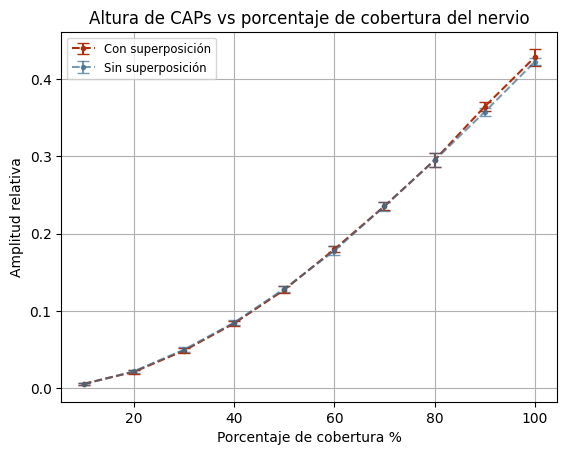

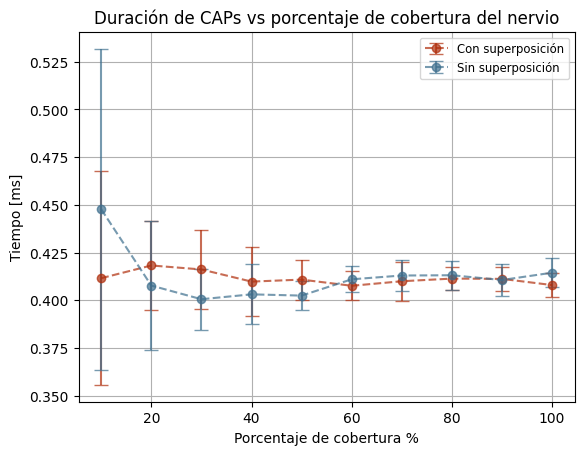

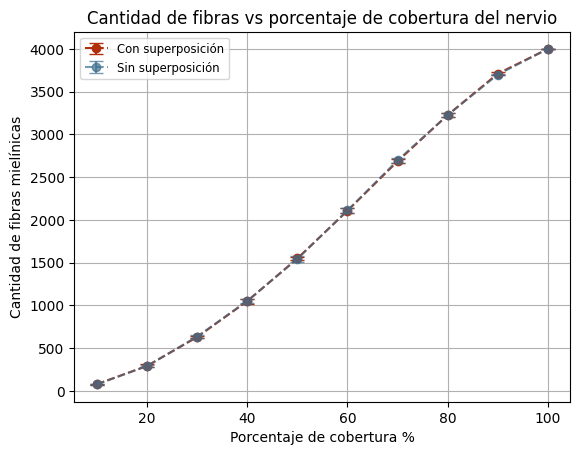

In [55]:
# Imagen 1 - Básico vs sin superposición

alt1 = [sub[0] for sub in basico]
error_alt1 = [sub[0] for sub in error_basico]

alt2 = [sub[0] for sub in sin_super]
error_alt2 = [sub[0] for sub in error_sin_super]

dur1 = [sub[2] for sub in basico]
error_dur1 = [sub[2] for sub in error_basico]

dur2 = [sub[2] for sub in sin_super]
error_dur2 = [sub[2] for sub in error_sin_super]

fib1 = [sub[1] for sub in basico]
error_fib1 = [sub[1] for sub in error_basico]

fib2 = [sub[1] for sub in sin_super]
error_fib2 = [sub[1] for sub in error_sin_super]

colores = ['#B02E0C','#E09F3E','#3E6F8E','#69B0B5']

#Altura
fig = plt.figure()
ax = plt.gca()
# plt.plot(zonas,alt1,'-o',label = 'Con superposición',color = colores[0])
# plt.plot(zonas,alt2,'-o',label = 'Sin superposición',color = colores[1])
plt.errorbar(porcentajes,alt1,fmt='--.',capsize=4,yerr = error_alt1,label = 'Con superposición',color = colores[0])
plt.errorbar(porcentajes,alt2,fmt='--.',capsize=4,yerr = error_alt2,label = 'Sin superposición',color = colores[2],alpha = 0.7)

plt.title('Altura de CAPs vs porcentaje de cobertura del nervio')
plt.xlabel('Porcentaje de cobertura %')
plt.ylabel('Amplitud relativa')
plt.legend(fontsize = 'small')
plt.grid()

fig.savefig('53_1a.png',dpi=300, format="png")  

#Duracion
fig2 = plt.figure()
plt.tight_layout()
# plt.plot(zonas,dur1,'-o',label = 'Con superposición',color = colores[0])
# plt.plot(zonas,dur2,'-o',label = 'Sin superposición',color = colores[1])
plt.errorbar(porcentajes,dur1,fmt='--o',capsize=5,yerr = error_dur1,label = 'Con superposición',color = colores[0],alpha = 0.7)
plt.errorbar(porcentajes,dur2,fmt='--o',capsize=5,yerr = error_dur2,label = 'Sin superposición',color = colores[2],alpha = 0.7)

plt.title('Duración de CAPs vs porcentaje de cobertura del nervio')
plt.xlabel('Porcentaje de cobertura %')
plt.ylabel('Tiempo [ms]')
plt.legend(fontsize = 'small')
plt.grid()

fig2.savefig('53_1d.png',dpi=300, format="png")  

#Cantidad de fibras
fig3 = plt.figure()
plt.tight_layout()
# plt.plot(zonas,dur1,'-o',label = 'Con superposición',color = colores[0])
# plt.plot(zonas,dur2,'-o',label = 'Sin superposición',color = colores[1])
plt.errorbar(porcentajes,fib1,fmt='--o',capsize=5,yerr = error_fib1,label = 'Con superposición',color = colores[0])
plt.errorbar(porcentajes,fib2,fmt='--o',capsize=5,yerr = error_fib2,label = 'Sin superposición',color = colores[2],alpha = 0.7)

plt.title('Cantidad de fibras vs porcentaje de cobertura del nervio')
plt.xlabel('Porcentaje de cobertura %')
plt.ylabel('Cantidad de fibras mielínicas')
plt.legend(fontsize = 'small')
plt.grid()

fig3.savefig('53_1f.png',dpi=300, format="png")  


In [56]:
# Para ver ERRORES ---------------------------

[(1-a2/a1)*100 for a1,a2 in zip(alt1,alt2)]

[9.661240833392492,
 -3.146200475686922,
 -2.5061905557303366,
 -1.0965382701407345,
 -1.053254525422198,
 1.0150663980435182,
 0.05529772849783843,
 0.07085324808366877,
 1.8610366522921251,
 1.3954764632755579]

In [61]:
[(1-a2/a1)*100 for a1,a2 in zip(fib1,fib2)]

[3.3121019108280136,
 0.47994514912580444,
 -1.0019083969465825,
 -0.31455533314270756,
 0.42619139868267375,
 -0.1709239388472339,
 -0.450769288082542,
 0.024803125193784137,
 0.2911443590780438,
 0.0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


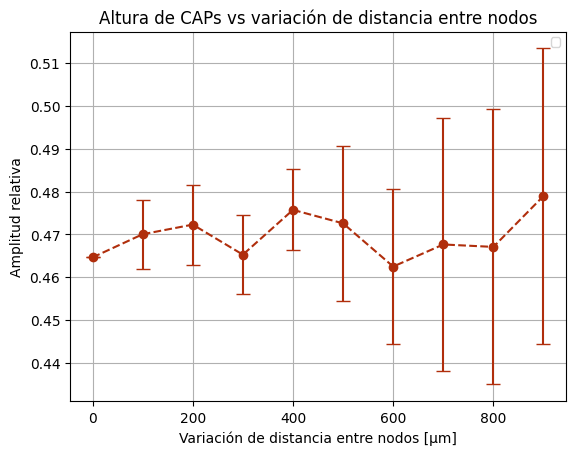

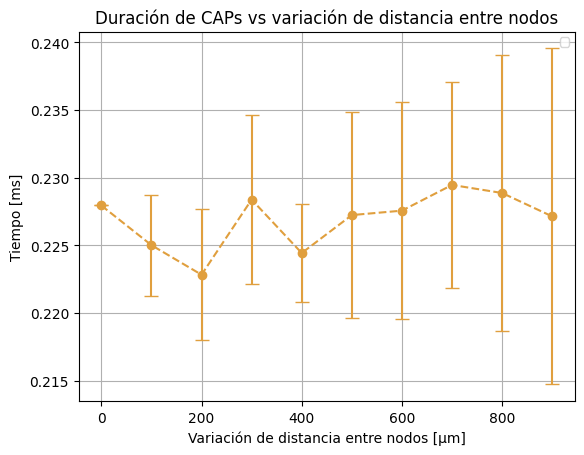

In [20]:
# Imagen 2 - Variación de nodos


# alt1 = [sub[0] for sub in var_nodos]
# error_alt1 = [sub[0] for sub in error_var_nodos]

# dur1 = [sub[1] for sub in var_nodos]
# error_dur1 = [sub[1] for sub in error_var_nodos]

# alt1 = [sub[0] for sub in var_nodos1]
# error_alt1 = [sub[0] for sub in error_var_nodos1]

# dur1 = [sub[1] for sub in var_nodos1]
# error_dur1 = [sub[1] for sub in error_var_nodos1]

alt1 = [sub[0] for sub in var_nodos2]
error_alt1 = [sub[0] for sub in error_var_nodos2]

dur1 = [sub[1] for sub in var_nodos2]
error_dur1 = [sub[1] for sub in error_var_nodos2]

colores = ['#B02E0C','#E09F3E','#3E6F8E','#69B0B5']

#Altura
fig= plt.figure()

plt.errorbar(variacion_de_nodos,alt1,fmt ='--o',yerr = error_alt1,capsize=5,color = colores[0])
# ax = plt.gca()
# ax.set_ylim([0.56, 0.66])

plt.title('Altura de CAPs vs variación de distancia entre nodos')
plt.xlabel('Variación de distancia entre nodos [µm]')
plt.ylabel('Amplitud relativa')
plt.legend(fontsize = 'small')
plt.grid()

fig.savefig('53_2a.png',dpi=300, format="png")  

#Duracion
fig2 = plt.figure()

plt.errorbar(variacion_de_nodos,dur1,yerr = error_dur1,fmt = '--o',capsize=5,color = colores[1])
# ax = plt.gca()
# ax.set_ylim([0.28, 0.34])

plt.title('Duración de CAPs vs variación de distancia entre nodos')
plt.xlabel('Variación de distancia entre nodos [µm]')
plt.ylabel('Tiempo [ms]')
plt.legend(fontsize = 'small')
plt.grid()

fig2.savefig('53_2d.png',dpi=300, format="png")  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


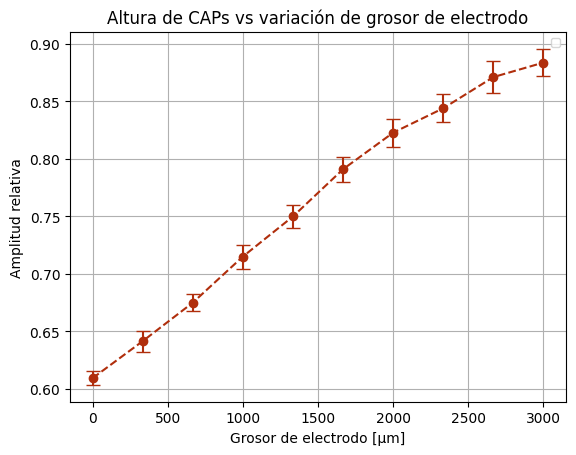

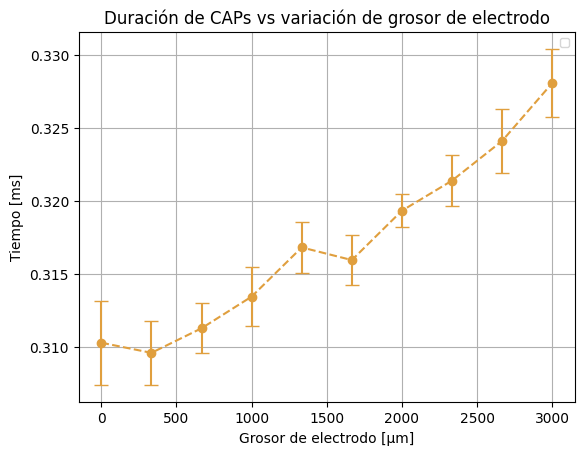

In [51]:
# Imagen 3 - Variación de GROSOR

# alt1 = [sub[0] for sub in con_grosor]
# error_alt1 = [sub[0] for sub in error_con_grosor]

# dur1 = [sub[9] for sub in con_grosor]
# error_dur1 = [sub[9] for sub in error_con_grosor]

# alt1 = [sub[0] for sub in con_grosor2]
# error_alt1 = [sub[0] for sub in error_con_grosor2]

# dur1 = [sub[1] for sub in con_grosor2]
# error_dur1 = [sub[1] for sub in error_con_grosor2]

alt1 = [sub[0] for sub in con_grosor3]
error_alt1 = [sub[0] for sub in error_con_grosor3]

dur1 = [sub[1] for sub in con_grosor3]
error_dur1 = [sub[1] for sub in error_con_grosor3]
grosores = np.linspace(0,3000,10)

# alt1 = [sub[0] for sub in con_grosor4]
# error_alt1 = [sub[0] for sub in error_con_grosor4]

# dur1 = [sub[1] for sub in con_grosor4]
# error_dur1 = [sub[1] for sub in error_con_grosor4]

# alt1 = [sub[0] for sub in con_grosor5]
# error_alt1 = [sub[0] for sub in error_con_grosor5]

# dur1 = [sub[1] for sub in con_grosor5]
# error_dur1 = [sub[1] for sub in error_con_grosor5]

# alt1 = [sub[0] for sub in con_grosor6]
# error_alt1 = [sub[0] for sub in error_con_grosor6]

# dur1 = [sub[1] for sub in con_grosor6]
# error_dur1 = [sub[1] for sub in error_con_grosor6]

# alt1 = [sub[0] for sub in con_grosor7]
# error_alt1 = [sub[0] for sub in error_con_grosor7]

# dur1 = [sub[1] for sub in con_grosor7]
# error_dur1 = [sub[1] for sub in error_con_grosor7]

colores = ['#B02E0C','#E09F3E','#3E6F8E','#69B0B5']

#Altura
fig = plt.figure()

plt.errorbar(grosores,alt1,fmt='--o',yerr = error_alt1,capsize=5,color = colores[0])
# ax = plt.gca()
# ax.set_ylim([0.55, 1])

plt.title('Altura de CAPs vs variación de grosor de electrodo')
plt.xlabel('Grosor de electrodo [µm]')
plt.ylabel('Amplitud relativa')
plt.legend(fontsize = 'small')
plt.grid()

fig.savefig('53_3a3mil.png',dpi=300, format="png")  

#Duracion
fig2 = plt.figure()

plt.errorbar(grosores,dur1,yerr = error_dur1,fmt='--o',capsize=5,color = colores[1])
# ax = plt.gca()
# ax.set_ylim([0.29, 0.33])

plt.title('Duración de CAPs vs variación de grosor de electrodo')
plt.xlabel('Grosor de electrodo [µm]')
plt.ylabel('Tiempo [ms]')
plt.legend(fontsize = 'small')
plt.grid()

fig2.savefig('53_3d3mil.png',dpi=300, format="png")  

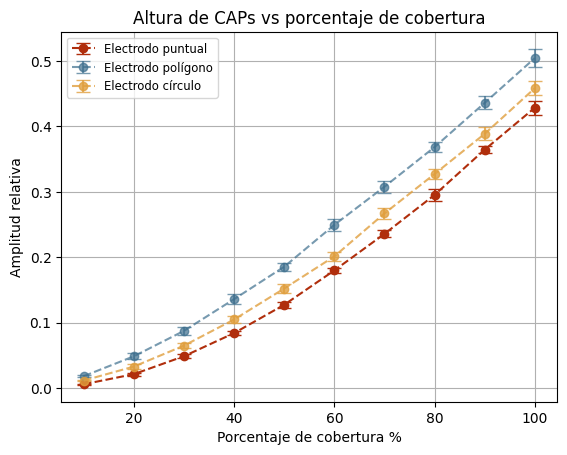

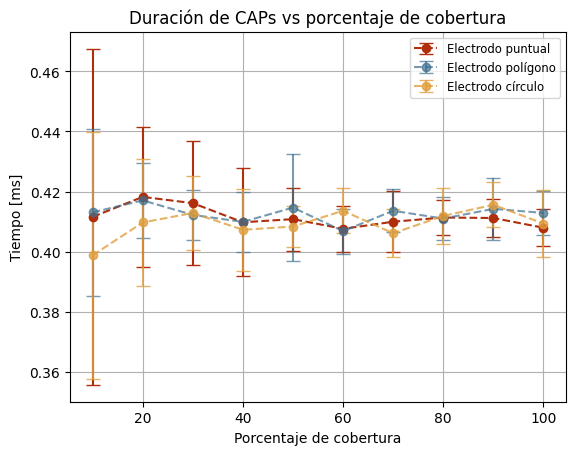

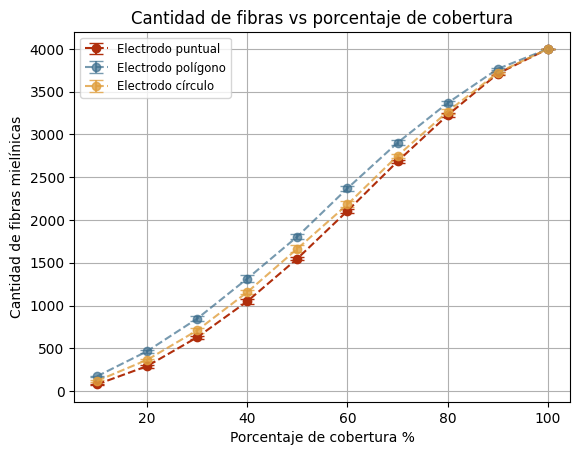

In [34]:
# Todos los tipos de electrodos juntos

alt1 = [sub[0] for sub in basico]
error_alt1 = [sub[0] for sub in error_basico]

alt2 = [sub[0] for sub in elec_pol]
error_alt2 = [sub[0] for sub in error_elec_pol]

alt3 = [sub[0] for sub in elec_circ]
error_alt3 = [sub[0] for sub in error_elec_circ]

dur1 = [sub[2] for sub in basico]
error_dur1 = [sub[2] for sub in error_basico]

dur2 = [sub[2] for sub in elec_pol]
error_dur2 = [sub[2] for sub in error_elec_pol]

dur3 = [sub[2] for sub in elec_circ]
error_dur3 = [sub[2] for sub in error_elec_circ]

fib1 = [sub[1] for sub in basico]
error_fib1 = [sub[1] for sub in error_basico]

fib2 = [sub[1] for sub in elec_pol]
error_fib2 = [sub[1] for sub in error_elec_pol]

fib3 = [sub[1] for sub in elec_circ]
error_fib3 = [sub[1] for sub in error_elec_circ]

colores = ['#B02E0C','#E09F3E','#3E6F8E','#69B0B5']

#Altura
fig = plt.figure()

# plt.plot(zonas,alt1,'-o',label = 'Electrodo puntual',color = colores[0])
# plt.plot(zonas,alt2,'-o',label = 'Electrodo polígono',color = colores[1])
plt.errorbar(porcentajes,alt1,fmt='--o',yerr = error_alt1,capsize=5 ,label = 'Electrodo puntual',color = colores[0])
plt.errorbar(porcentajes,alt2,fmt='--o',yerr = error_alt2,capsize=5,label = 'Electrodo polígono',color = colores[2],alpha = 0.7)
plt.errorbar(porcentajes,alt3,fmt='--o',yerr = error_alt3,capsize=5,label = 'Electrodo círculo',color = colores[1],alpha = 0.8)

plt.title('Altura de CAPs vs porcentaje de cobertura')
plt.xlabel('Porcentaje de cobertura %')
plt.ylabel('Amplitud relativa')
plt.legend(fontsize = 'small')
plt.grid()

fig.savefig('53_7a.png',dpi=300, format="png")  

#Duracion
fig2 = plt.figure()

# plt.plot(zonas,dur1,'-o',label = 'CElectrodo puntual',color = colores[0])
# plt.plot(zonas,dur2,'-o',label = 'Electrodo polígono',color = colores[1])
plt.errorbar(porcentajes,dur1,fmt='--o',yerr = error_dur1,capsize=5 ,label = 'Electrodo puntual',color = colores[0])
plt.errorbar(porcentajes,dur2,fmt='--o',yerr = error_dur2,capsize=5 ,label = 'Electrodo polígono',color = colores[2],alpha = 0.7)
plt.errorbar(porcentajes,dur3,fmt='--o',yerr = error_dur3,capsize=5 ,label = 'Electrodo círculo',color = colores[1],alpha = 0.8)

plt.title('Duración de CAPs vs porcentaje de cobertura')
plt.xlabel('Porcentaje de cobertura')
plt.ylabel('Tiempo [ms]')
plt.legend(fontsize = 'small')
plt.grid()

fig2.savefig('53_7d.png',dpi=300, format="png")  

#Cantidad de fibras
fig3 = plt.figure()

# plt.plot(zonas,dur1,'-o',label = 'CElectrodo puntual',color = colores[0])
# plt.plot(zonas,dur2,'-o',label = 'Electrodo polígono',color = colores[1])
plt.errorbar(porcentajes,fib1,fmt='--o',yerr = error_fib1,capsize=5 ,label = 'Electrodo puntual',color = colores[0])
plt.errorbar(porcentajes,fib2,fmt='--o',yerr = error_fib2,capsize=5 ,label = 'Electrodo polígono',color = colores[2],alpha = 0.7)
plt.errorbar(porcentajes,fib3,fmt='--o',yerr = error_fib3,capsize=5 ,label = 'Electrodo círculo',color = colores[1],alpha = 0.8)

plt.title('Cantidad de fibras vs porcentaje de cobertura')
plt.xlabel('Porcentaje de cobertura %')
plt.ylabel('Cantidad de fibras mielínicas')
plt.legend(fontsize = 'small')
plt.grid()

fig3.savefig('53_7f.png',dpi=300, format="png") 

## <stan style = "color : orange "> Primera parte: nervio ciático del sapo </stan>

### <stan style = "color : magenta "> Comparación de alturas y duración de gráficas </stan>

In [ ]:
# Arrays de fibras con toda la info, sacadas de Matlab

ubicaciones = ['C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_01.csv','C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_02.csv',
               'C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_03.csv','C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_04.csv',
               'C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_05.csv','C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_06.csv',
               'C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_07.csv','C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_08.csv',
               'C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_09.csv','C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_10.csv']

In [ ]:
for i,ubi in enumerate(ubicaciones):
    a = Entorno(nombre='Experimento_01',tiempo_registro=0.003)
    a.crear_nervio(diametro = 1524,num_fibras=4000,metodo_poblacion = 'desde_archivo',ubicacion_archivo = ubi,distancia_nodos=2000,longitud=70000,porcentaje_cobertura=100,variacion_nodos = 0)
    a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
    a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
    a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
    a.cap()
    a.cap_diferencial()
    print(f"La altura máxima de la ubicacion {i+1} es {max(a.electrodos[0].cap)}")

In [ ]:
# Generación de imágenes - GENERAL

a = Entorno(nombre='Experimento_01',tiempo_registro=0.003)
a.crear_nervio(diametro = 1524,num_fibras=4000,metodo_poblacion = 'desde_archivo',ubicacion_archivo = 'C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_01.csv',distancia_nodos=2000,longitud=70000,porcentaje_cobertura=100,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 10000,zona_influencia=8000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 20000,zona_influencia=8000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.cap()
a.cap_diferencial()
#a.dibujar_entorno()
a.graficas(guardar=True,nombre_figura = 'p_general.png',titulo='CAPs y CAP diferencial')

In [ ]:
a.electrodos[0].wlong[0]

In [ ]:
# Para ver el número de muestra donde hay que cortar la señal para arriba
idx = 1

vector_tiempo = np.arange(1 / a.frec_muestreo, 1 / a.frec_muestreo + a.tiempo_registro,1 / a.frec_muestreo)
plt.plot(a.electrodos[idx].cap,vector_tiempo*a.frec_muestreo)
plt.grid()

In [ ]:
# Info de alturas y tiempos

from scipy.interpolate import interp1d

print("INFO ELECTRODO 0")
# Límite y electrodo

limite = 48
idx = 0

# Alturas máxima, 90%, 10% y 50%

e = a.electrodos[idx]
valor_10 = max(e.cap)*0.1
valor_90 = max(e.cap)*0.9
valor_50 = max(e.cap)*0.5

print(f"La altura máxima del CAP E{idx} es {max(e.cap)} \n")
print(f"El 10 del Electrodo {idx} es {max(e.cap)*0.1} ")
print(f"El 90 del Electrodo {idx} es {max(e.cap)*0.9}  \n")
print(f"El 50 del Electrodo {idx} es {max(e.cap)*0.5} \n")

# Tiempos al 50% de altura

vector_tiempo = np.arange(1 / a.frec_muestreo, 1 / a.frec_muestreo + a.tiempo_registro,1 / a.frec_muestreo)
x = vector_tiempo[:limite]
y = a.electrodos[idx].cap[:limite]
func = interp1d(y,x)
t1 = func(valor_50)
print(f"t1 = {t1*1000} ms")


x = vector_tiempo[limite:]
y = a.electrodos[idx].cap[limite:]
func = interp1d(y,x)
t2 = func(valor_50)
print(f"t2 = {t2*1000} ms")

print(f"Duracion = {(t2 - t1)*1000} ms \n")

# Tiempos al 10% y 90%

x = vector_tiempo[:limite]
y = a.electrodos[idx].cap[:limite]
func = interp1d(y,x)
t_90 = func(valor_90)
print(f"Tiempo para 90% = {t_90*1000}ms")

x = vector_tiempo[:limite]
y = a.electrodos[idx].cap[:limite]
func = interp1d(y,x)
t_10 = func(valor_10)
print(f"Tiempo para 10% = {t_10*1000}ms \n \n")




print("INFO ELECTRODO 1")
# Alturas máxima, 90%, 10% y 50%

idx = 1
limite = 75

e = a.electrodos[idx]
valor_10 = max(e.cap)*0.1
valor_90 = max(e.cap)*0.9
valor_50 = max(e.cap)*0.5

print(f"La altura máxima del CAP E{idx} es {max(e.cap)} \n")
print(f"El 10 del Electrodo {idx} es {max(e.cap)*0.1} ")
print(f"El 90 del Electrodo {idx} es {max(e.cap)*0.9}  \n")
print(f"El 50 del Electrodo {idx} es {max(e.cap)*0.5} \n")

# Tiempos al 50% de altura

vector_tiempo = np.arange(1 / a.frec_muestreo, 1 / a.frec_muestreo + a.tiempo_registro,1 / a.frec_muestreo)
x = vector_tiempo[:limite]
y = a.electrodos[idx].cap[:limite]
func = interp1d(y,x)
t1 = func(valor_50)
print(f"t1 = {t1*1000} ms")


x = vector_tiempo[limite:]
y = a.electrodos[idx].cap[limite:]
func = interp1d(y,x)
t2 = func(valor_50)
print(f"t2 = {t2*1000} ms")

print(f"Duracion = {(t2 - t1)*1000} ms \n")

# Tiempos al 10% y 90%

x = vector_tiempo[:limite]
y = a.electrodos[idx].cap[:limite]
func = interp1d(y,x)
t_90 = func(valor_90)
print(f"Tiempo para 90% = {t_90*1000}ms")

x = vector_tiempo[:limite]
y = a.electrodos[idx].cap[:limite]
func = interp1d(y,x)
t_10 = func(valor_10)
print(f"Tiempo para 10% = {t_10*1000}ms")




In [ ]:
# Para las 10 ubicaciones, con csv 

from scipy.interpolate import interp1d

info = np.zeros((10,8))

for i,ubi in enumerate(ubicaciones):
    a = Entorno(nombre='Experimento_01',tiempo_registro=0.003)
    a.crear_nervio(diametro = 1524,num_fibras=4000,metodo_poblacion = 'desde_archivo',ubicacion_archivo = ubi,distancia_nodos=2000,longitud=70000,porcentaje_cobertura=100,variacion_nodos = 0)
    a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
    a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
    a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
    a.cap()
    a.cap_diferencial()
    
    # Electrodo 0 -------------------
    limite = 48
    idx = 0

    # Alturas máxima, 90%, 10% y 50%
    e = a.electrodos[idx]
    alt_max = max(e.cap)
    alt_10 = max(e.cap)*0.1
    alt_90 = max(e.cap)*0.9
    alt_50 = max(e.cap)*0.5

    # Tiempos al 50% de altura
    vector_tiempo = np.arange(1 / a.frec_muestreo, 1 / a.frec_muestreo + a.tiempo_registro,1 / a.frec_muestreo)
    x = vector_tiempo[:limite]
    y = a.electrodos[idx].cap[:limite]
    func = interp1d(y,x)
    t1_50 = func(alt_50)*1000

    x = vector_tiempo[limite:]
    y = a.electrodos[idx].cap[limite:]
    func = interp1d(y,x)
    t2_50 = func(alt_50)*1000

    #Duracion = (t2_50 - t1_50)*1000

    # Tiempos al 10% y 90%
    x = vector_tiempo[:limite]
    y = a.electrodos[idx].cap[:limite]
    func = interp1d(y,x)
    t_90 = func(alt_90)*1000
    t_10 = func(alt_10)*1000
    
    info[i] = [alt_max,alt_90,t_90,alt_10,t_10,alt_50,t1_50,t2_50]

promedio = sum(info)/10
print(promedio)
print(f"duracion = {promedio[7]-promedio[6]}")
#np.savetxt("info.csv", info, delimiter=",")

In [ ]:
# Datos

nodos = [4,6,8,10]
dur_py_1 = [0.33126826,0.341734,0.356612,0.37527314]
dur_py_2 = [0.558783,0.561499,0.56447,0.570216]

dur_mat_1 = [0.391,0.404,0.436,0.471]
dur_mat_2 = [0.602,0.625,0.653,0.675]

alt_py_1 = [0.15732447,0.241763,0.314045,0.37608439]
alt_py_2 = [0.089824,0.141971,0.191183,0.237822]
 
alt_mat_1 = [0.187354,0.233058,0.275903,0.320413]
alt_mat_2 = [0.111804,0.148626,0.180855,0.21902]

rt_py_1 = [0.15992819,0.16482,0.174745,0.196963]
rt_py_2 = [0.199232,0.206588,0.215598,0.22613]

rt_mat_1 = [0.181,0.194,0.221,0.244]
rt_mat_2 = [0.213,0.246,0.251,0.269]

colores = ['#B02E0C','#E09F3E','#3E6F8E','#69B0B5']


In [ ]:
# Duración CAP 1
fig = plt.figure()

plt.plot(nodos,dur_py_1,'-o',label = 'Duración CAP 1 Python')
plt.plot(nodos,dur_mat_1,'-o',label = 'Duración CAP 1 Matlab')


plt.title('Duración de CAP 1 vs cantidad de nodos')
plt.xlabel('Cantidad de nodos')
plt.ylabel('Tiempo [ms]')
plt.legend(fontsize = 'small')
#plt.axis('equal')
plt.grid()

fig.savefig('p_01.png',dpi=300, format="png")  

In [ ]:
# Duración CAP 2
fig = plt.figure()

plt.plot(nodos,dur_py_2,'-o',label = 'Duración CAP 2 Python')
plt.plot(nodos,dur_mat_2,'-o',label = 'Duración CAP 2 Matlab')


plt.title('Duración de CAP 2 vs cantidad de nodos')
plt.xlabel('Cantidad de nodos')
plt.ylabel('Tiempo [ms]')
plt.legend(fontsize = 'small')
#plt.axis('equal')
plt.grid()

fig.savefig('p_01.png',dpi=300, format="png")  

In [ ]:
# Duración de ambos CAPs en un solo gráfico

fig = plt.figure()

plt.plot(nodos,dur_py_1,'-o',label = 'Duración CAP 1 Python',color = colores[0])
plt.plot(nodos,dur_py_2,'-o',label = 'Duración CAP 2 Python',color = colores[1])
plt.plot(nodos,dur_mat_1,'-o',label = 'Duración CAP 1 Matlab',color = colores[2])
plt.plot(nodos,dur_mat_2,'-o',label = 'Duración CAP 2 Matlab',color = colores[3])


plt.title('Duración de CAPs vs cantidad de nodos')
plt.xlabel('Cantidad de nodos')
plt.ylabel('Tiempo [ms]')
plt.legend(fontsize = 'small')
#plt.axis('equal')
plt.grid()

fig.savefig('analisis_1.png',dpi=300, format="png")  

In [ ]:
# Alturas máximas

# Altura de ambos CAPs en un solo gráfico

fig = plt.figure()

plt.plot(nodos,alt_py_1,'-o',label = 'Altura máxima CAP 1 Python',color = colores[0])
plt.plot(nodos,alt_py_2,'-o',label = 'Altura máxima CAP 2 Python',color = colores[1])
plt.plot(nodos,alt_mat_1,'-o',label = 'Altura máxima CAP 1 Matlab',color = colores[2])
plt.plot(nodos,alt_mat_2,'-o',label = 'Altura máxima CAP 2 Matlab',color = colores[3])


plt.title('Altura máxima de CAPs vs cantidad de nodos')
plt.xlabel('Cantidad de nodos')
plt.ylabel('Tiempo [ms]')
plt.legend(fontsize = 'small')
#plt.axis('equal')
plt.grid()

fig.savefig('analisis_2.png',dpi=300, format="png") 

In [ ]:
# Rise time

# Rise time de ambos CAPs en un solo gráfico

fig = plt.figure()

plt.plot(nodos,rt_py_1,'-o',label = 'Rise time CAP 1 Python',color = colores[0])
plt.plot(nodos,rt_py_2,'-o',label = 'Rise time CAP 2 Python',color = colores[1])
plt.plot(nodos,rt_mat_1,'-o',label = 'Rise time CAP 1 Matlab',color = colores[2])
plt.plot(nodos,rt_mat_2,'-o',label = 'Rise time CAP 2 Matlab',color = colores[3])


plt.title('Rise time de CAPs vs cantidad de nodos')
plt.xlabel('Cantidad de nodos')
plt.ylabel('Tiempo [ms]')
plt.legend(fontsize = 'small')
#plt.axis('equal')
plt.grid()

fig.savefig('analisis_3.png',dpi=300, format="png") 

### <stan style = "color : magenta "> Imágenes del paper </stan>

In [ ]:
# Generación de imágenes - GENERAL

a = Entorno(nombre='Experimento_01',tiempo_registro=0.002)
a.crear_nervio(diametro = 1524,num_fibras=4000,metodo_poblacion = 'desde_archivo',ubicacion_archivo = 'C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_01.csv',distancia_nodos=2000,longitud=70000,porcentaje_cobertura=100,variacion_nodos = 0)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
a.cap()
a.cap_diferencial()
#a.dibujar_entorno()
a.graficas(guardar=True,nombre_figura = 'p_general.png',titulo='CAPs y CAP diferencial')

In [ ]:
#Cantidad de nodos reclutados

a.electrodos[0].wlong[0]

In [ ]:
# Arrays de fibras con toda la info, sacadas de Matlab

ubicaciones = ['C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_01.csv','C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_02.csv',
               'C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_03.csv','C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_04.csv',
               'C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_05.csv','C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_06.csv',
               'C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_07.csv','C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_08.csv',
               'C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_09.csv','C:/Users/aguir/Desktop/Prroyecto/python/nervio_ciatico_10.csv']

In [ ]:
# Imagen 1 - Todas las señales CAPs, CAP diferencial y Vm

fig = plt.figure()
i = 0
for ubicacion in ubicaciones:
    a = Entorno(nombre='Experimento_01',tiempo_registro=0.004)
    a.crear_nervio(diametro = 1524,num_fibras=4000,metodo_poblacion = 'desde_archivo',ubicacion_archivo = ubicacion,distancia_nodos=2000,longitud=50000,porcentaje_cobertura=100,variacion_nodos = 0)
    a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
    a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
    a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
    #plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0], label = f'fc = {f}Hz')
    a.cap()
    a.cap_diferencial()
    t = np.arange(1/a.frec_muestreo,1/a.frec_muestreo+a.tiempo_registro,1/a.frec_muestreo)
        
    #CAP
    plt.plot(t*1000,a.electrodos[0].cap,label = f"CAP Electrodo n°{0}" if i==0 else '',color = '#42458A',linewidth = 0.5)
    plt.plot(t*1000,a.electrodos[1].cap,label = f"CAP Electrodo n°{1}"if i==0 else '',color = '#FF0A2F',linewidth = 0.5)
    #CAP diferencial
    plt.plot(t*1000,a.cap_dif, label = f"CAP diferencial electrodos {a.capdif_pos1}-{a.capdif_pos2}"if i==0 else '',color = '#8EA604',linewidth = 0.7)
    #Vm  
    plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0], label = "Vm"if i==0 else '', color = 'gray',linewidth = 0.3)
    
    i+=1

plt.title('Estimulo, CAPs y CAP diferencial')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud relativa')
plt.legend(fontsize = 'small')
#plt.show()

fig.savefig('p_01.png',dpi=300, format="png")  


In [ ]:
# Imagen 2 - Variación distancias entre electrodos

posicion_electrodo2 = [20000,30000,40000,50000,60000,70000]
colores = ['#912F40','#0A58FF','#63934D','#C16200','#B821C0','#5259A3'] #paleta de muchos colores
colores = ['#FFC933','#F1A837','#E3863B','#CD6327','#B63F12','#9D1107','#791D16'] #paleta de tonos amarillos a rojos

fig = plt.figure()

for idx,pos in enumerate(posicion_electrodo2):
    for i,ubicacion in enumerate(ubicaciones):
        a = Entorno(nombre='Experimento_01')
        a.crear_nervio(diametro = 1524,num_fibras=4000,metodo_poblacion = 'desde_archivo',ubicacion_archivo = ubicacion,distancia_nodos=2000,longitud=100000,porcentaje_cobertura=100,variacion_nodos = 0)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = pos,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
        #plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0], label = f'fc = {f}Hz')
        a.cap()
        a.cap_diferencial()
        t = np.arange(1/a.frec_muestreo,1/a.frec_muestreo+a.tiempo_registro,1/a.frec_muestreo)
            
        #CAP
        # plt.plot(t,a.electrodos[0].cap,label = f"CAP Electrodo n°{0}" if i==0 else '',color = '#FF0A2F',linewidth = 0.7)
        # plt.plot(t,a.electrodos[1].cap,label = f"CAP Electrodo n°{1}"if i==0 else '',color = '#42458A',linewidth = 0.7)
        
        #CAP diferencial
        plt.plot(t,a.cap_dif, label = f"CAP dif con |de1-de2| = {pos/10000 - 1} cm"if i==0 else '',color = colores[idx],linewidth = 0.5)
        #Vm  
        #plt.plot(a.estimulador.vector_tiempo,a.estimulador.estimulo[0], label = "Vm"if i==0 else '', color = 'gray',linewidth = 0.3)
    

plt.title('Variación de distancia entre electrodos')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud relativa')
plt.legend(fontsize = 'small')
#plt.show()

fig.savefig('p_02.png',dpi=300, format="png")  

In [ ]:
# Imagen 3 - Manteniendo distancia interelectrodo, variar posicion del conjunto

posicion_electrodo1 = [10000,20000,30000,40000,50000,60000]
posicion_electrodo2 = [20000,30000,40000,50000,60000,70000]

colores = ['#912F40','#0A58FF','#63934D','#C16200','#B821C0','#5259A3'] #paleta de muchos colores
colores = ['#FFC933','#F1A837','#E3863B','#CD6327','#B63F12','#9D1107','#791D16'] #paleta cromatica

fig = plt.figure()

for idx,pos in enumerate(posicion_electrodo2): #bucle que varía
    for i,ubicacion in enumerate(ubicaciones): #repeticiones
        a = Entorno(nombre='Experimento_01')
        a.crear_nervio(diametro = 1524,num_fibras=4000,metodo_poblacion = 'desde_archivo',ubicacion_archivo = ubicacion,distancia_nodos=2000,longitud=100000,porcentaje_cobertura=100,variacion_nodos = 0)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = posicion_electrodo1[idx],zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = pos,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
        #plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0], label = f'fc = {f}Hz')
        a.cap()
        a.cap_diferencial()
        t = np.arange(1/a.frec_muestreo,1/a.frec_muestreo+a.tiempo_registro,1/a.frec_muestreo)
            
        #CAP
        # plt.plot(t,a.electrodos[0].cap,label = f"CAP Electrodo n°{0}" if i==0 else '',color = '#FF0A2F',linewidth = 0.7)
        # plt.plot(t,a.electrodos[1].cap,label = f"CAP Electrodo n°{1}"if i==0 else '',color = '#42458A',linewidth = 0.7)
        
        #CAP diferencial
        plt.plot(t,a.cap_dif, label = f"CAP dif de1={posicion_electrodo1[idx]/10000}cm y de2={pos/10000}cm"if i==0 else '',color = colores[idx],linewidth = 0.5)
        #Vm  
        #plt.plot(a.estimulador.vector_tiempo,a.estimulador.estimulo[0], label = "Vm"if i==0 else '', color = 'gray',linewidth = 0.3)
    

plt.title('Variación de posición de electrodos en conjunto')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud relativa')
plt.legend(fontsize = 'small')
#plt.show()

fig.savefig('p_03.png',dpi=300, format="png") 

In [ ]:
# Imagen 4 - Variación en la cantidad de nodos 

zonas = [2000,6000,10000]
colores = ['#912F40','#0A58FF','#63934D','#C16200','#B821C0','#5259A3']
colores = ['#FFC933','#CD6327','#791D16'] # paleta cromatica

fig = plt.figure()

for idx,z in enumerate(zonas):
    for i,ubicacion in enumerate(ubicaciones):
        a = Entorno(nombre='Experimento_01')
        a.crear_nervio(diametro = 1524,num_fibras=4000,metodo_poblacion = 'desde_archivo',ubicacion_archivo = ubicacion,distancia_nodos=2000,longitud=100000,porcentaje_cobertura=100,variacion_nodos = 0)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 20000,zona_influencia=z,grosor=0,funcion = funcion_trapecio)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 30000,zona_influencia=z,grosor=0,funcion = funcion_trapecio)
        a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
        #plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0], label = f'fc = {f}Hz')
        a.cap()
        a.cap_diferencial()
        t = np.arange(1/a.frec_muestreo,1/a.frec_muestreo+a.tiempo_registro,1/a.frec_muestreo)
            
        #CAP
        # plt.plot(t,a.electrodos[0].cap,label = f"CAP Electrodo n°{0}" if i==0 else '',color = '#FF0A2F',linewidth = 0.7)
        # plt.plot(t,a.electrodos[1].cap,label = f"CAP Electrodo n°{1}"if i==0 else '',color = '#42458A',linewidth = 0.7)
        
        #CAP diferencial
        plt.plot(t,a.cap_dif, label = f"CAPdif con zona de influencia = {z}μm"if i==0 else '',color = colores[idx],linewidth = 0.5)
        #Vm  
        #plt.plot(a.estimulador.vector_tiempo,a.estimulador.estimulo[0], label = "Vm"if i==0 else '', color = 'gray',linewidth = 0.3)
    

plt.title('Variaciónen de zona de influencia de electrodos')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud relativa')
plt.legend(fontsize = 'small')
#plt.show()

fig.savefig('p_04.png',dpi=300, format="png")

In [ ]:
# Imagen 5 - Intento de variar la duración de Vm -- Potencial de acción

frecuencias = [1200,2300,3200,4000]
tiempos = [1.2,0.6,0.4,0.3]
colores = ['#912F40','#0A58FF','#63934D','#C16200','#B821C0','#5259A3']
colores = ['#FFC933','#E3863B','#B63F12','#791D16'] #paleta cromatica

fig = plt.figure()

for idx,f in enumerate(frecuencias):
    for i,ubicacion in enumerate(ubicaciones):
        a = Entorno(nombre='Experimento_01')
        a.crear_nervio(diametro = 1524,num_fibras=4000,metodo_poblacion = 'desde_archivo',ubicacion_archivo = ubicacion,distancia_nodos=2000,longitud=100000,porcentaje_cobertura=100,variacion_nodos = 0)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = f,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
        #plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0], label = f'fc = {f}Hz')
        a.cap()
        a.cap_diferencial()
        t = np.arange(1/a.frec_muestreo,1/a.frec_muestreo+a.tiempo_registro,1/a.frec_muestreo)
            
        #CAP
        # plt.plot(t,a.electrodos[0].cap,label = f"CAP Electrodo n°{0}" if i==0 else '',color = '#FF0A2F',linewidth = 0.7)
        # plt.plot(t,a.electrodos[1].cap,label = f"CAP Electrodo n°{1}"if i==0 else '',color = '#42458A',linewidth = 0.7)
        
        #CAP diferencial
        plt.plot(t,a.cap_dif, label = f"CAPdif - Vm con {tiempos[idx]}ms de duración"if i==0 else '',color = colores[idx],linewidth = 0.5)
        #Vm  
        #plt.plot(a.estimulador.vector_tiempo,a.estimulador.estimulo[0], label = "Vm"if i==0 else '', color = 'gray',linewidth = 0.3)
    

plt.title('Variaciónen duración de Vm')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud relativa')
plt.legend(fontsize = 'small')
#plt.show()

fig.savefig('p_05.png',dpi=300, format="png")


In [ ]:
# Imagen 5 - Solo Vm
#frecuencias = [800,1600,2300,3000]
frecuencias = [1200,2300,3200,4000]
tiempos = [1.2,0.6,0.4,0.3]
colores = ['#912F40','#0A58FF','#63934D','#C16200','#B821C0','#5259A3']
colores = ['#FFC933','#F1A837','#E3863B','#CD6327','#B63F12','#9D1107','#791D16'] # paleta cromatica
colores = ['#FFC933','#E3863B','#B63F12','#791D16'] #paleta cromatica

fig = plt.figure()

for idx,f in enumerate(frecuencias):
    a = Entorno(nombre='Experimento_01',tiempo_registro=0.003)
    a.crear_nervio(diametro = 1524,num_fibras=4000,metodo_poblacion = 'desde_archivo',ubicacion_archivo = ubicaciones[1],distancia_nodos=2000,longitud=100000,porcentaje_cobertura=100,variacion_nodos = 0)
    a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
    a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
    a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.002,tiempo_inicio = 0,frec_corte = f,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
        #plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0], label = f'fc = {f}Hz')
        # a.cap()
        # a.cap_diferencial()
    t = np.arange(1/a.frec_muestreo,1/a.frec_muestreo+a.tiempo_registro,1/a.frec_muestreo)
            
        #CAP
        # plt.plot(t,a.electrodos[0].cap,label = f"CAP Electrodo n°{0}" if i==0 else '',color = '#FF0A2F',linewidth = 0.7)
        # plt.plot(t,a.electrodos[1].cap,label = f"CAP Electrodo n°{1}"if i==0 else '',color = '#42458A',linewidth = 0.7)
        
        #CAP diferencial
        #plt.plot(t,a.cap_dif, label = f"CAPdif fcorte de Vm={f}Hz"if i==0 else '',color = colores[idx],linewidth = 0.7)
        #Vm  
    plt.plot(a.estimulador.vector_tiempo/1000,a.estimulador.estimulo[0], label = f"Vm con {tiempos[idx]}ms de duración", color = colores[idx])

plt.title('Variaciónen duración de Vm')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud relativa')
plt.legend(fontsize = 'small')
#plt.show()

fig.savefig('p_05_1.png',dpi=300, format="png")


In [ ]:
# Imagen 6 - Variación de la conductividad transversal o porcentaje de cobertura (Wmax)

porcentajes = [25,50,75,100]
colores = ['#912F40','#0A58FF','#63934D','#C16200','#B821C0','#5259A3']
colores = ['#FFC933','#F1A837','#E3863B','#CD6327','#B63F12','#9D1107','#791D16'] #paleta cromatica
colores = ['#FFC933','#E3863B','#B63F12','#791D16'] #paleta cromatica

fig = plt.figure()

for idx,p in enumerate(porcentajes):
    for i,ubicacion in enumerate(ubicaciones):
        a = Entorno(nombre='Experimento_01')
        a.crear_nervio(diametro = 1524,num_fibras=4000,metodo_poblacion = 'desde_archivo',ubicacion_archivo = ubicacion,distancia_nodos=2000,longitud=100000,porcentaje_cobertura=p,variacion_nodos = 0)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 10000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -762,pos_z = 20000,zona_influencia=10000,grosor=0,funcion = funcion_trapecio)
        a.crear_estimulo(tipo_estimulo='potencial_de_accion',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.001,frec_corte = 2000,orden_filtro = 2) #lista_inicio = [0,0.001,0.002]
        #plt.plot(a.estimulador.vector_tiempo*1000,a.estimulador.estimulo[0], label = f'fc = {f}Hz')
        a.cap()
        a.cap_diferencial()
        t = np.arange(1/a.frec_muestreo,1/a.frec_muestreo+a.tiempo_registro,1/a.frec_muestreo)
            
        #CAP
        # plt.plot(t,a.electrodos[0].cap,label = f"CAP Electrodo n°{0}" if i==0 else '',color = '#FF0A2F',linewidth = 0.7)
        # plt.plot(t,a.electrodos[1].cap,label = f"CAP Electrodo n°{1}"if i==0 else '',color = '#42458A',linewidth = 0.7)
        
        #CAP diferencial
        plt.plot(t,a.cap_dif, label = f"CAPdif porcentaje de cobertura={p}%"if i==0 else '',color = colores[idx],linewidth = 0.5)
        #Vm  
        #plt.plot(a.estimulador.vector_tiempo,a.estimulador.estimulo[0], label = "Vm"if i==0 else '', color = 'gray',linewidth = 0.3)
    

plt.title('Variación del porcentaje de cobertura de los electrodos')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud relativa')
plt.legend(fontsize = 'small')
#plt.show()

fig.savefig('p_06.png',dpi=300, format="png")



## <stan style = "color : orange "> Segunda parte: nervio ciático rana  </stan>

In [ ]:
# Exactamente lo del paper - Figura 3a

voltajes = [0.17,0.45,0.7,0.79,0.85,0.9]
colores = ['#912F40','#0A58FF','#63934D','#C16200','#B821C0','#5259A3']
colores = ['#FFC933','#E3A327','#D59021','#C67C1A','#AA550E','#8D2E01']
colores = ['#FFC933','#F1A837','#E3863B','#CD6327','#B63F12','#9D1107','#791D16']

fig = plt.figure()
maximos = []

for i,v in enumerate(voltajes):
    a = Entorno(nombre='Experimento_01', tiempo_registro=0.002)
    a.crear_nervio(diametro = 1300,num_fibras=2700,metodo_poblacion = 'uniforme_con_superposicion',diametro_fibra=16,var_diametro=6,distancia_nodos=2000,longitud=80000,porcentaje_cobertura=100,variacion_nodos = 500,semilla = 245)
    # a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -650,pos_z = 20000,zona_influencia=10000,grosor=2000,funcion = funcion_trapecio)
    # a.crear_electrodo(tipo='punto',pos_x = 0,pos_y = -650,pos_z = 40000,zona_influencia=10000,grosor=2000,funcion = funcion_trapecio)
    a.crear_electrodo(tipo = 'poligono',lista_coordenadas = [(-1000,-650),(1000,650),(-1000,-1650),(1000,-1650)],pos_z = 20000,zona_influencia=10000,funcion=funcion_trapecio)
    a.crear_electrodo(tipo = 'poligono',lista_coordenadas = [(-1000,-650),(1000,650),(-1000,-1650),(1000,-1650)],pos_z = 40000,zona_influencia=10000,funcion=funcion_trapecio)
    a.crear_estimulo(tipo_estimulo='cuadrado',frec_muestreo=100000,tiempo_estimulo=0.003,tiempo_inicio = 0.0003,duracion = 0.0002,voltaje = v/1000*2700) #lista_inicio = [0,0.001,0.002]
    a.cap()
    a.cap_diferencial()
    t = np.arange(1/a.frec_muestreo,1/a.frec_muestreo+a.tiempo_registro,1/a.frec_muestreo)
        
    #CAP
    #plt.plot(t,a.electrodos[0].cap,label = f"CAP Electrodo n°{0}, {v}V",color = colores[i],linewidth = 0.7)
    # plt.plot(t,a.electrodos[1].cap,label = f"CAP Electrodo n°{1}"if i==0 else '',color = '#42458A',linewidth = 0.7)
    #CAP diferencial
    #plt.plot(t/1000,a.cap_dif, label = f"CAP diferencial voltaje = {round(v*2700/1000,1)}V",color = colores[i],linewidth = 1.3)
    plt.plot(t/1000,a.cap_dif, label = f"CAP diferencial voltaje = {v}V",color = colores[i],linewidth = 1.3)
    maximos.append(max(a.cap_dif))
    #Vm  
    #plt.plot(a.estimulador.vector_tiempo,a.estimulador.estimulo[0], label = "Vm"if i==0 else '', color = 'gray',linewidth = 0.5)
print(maximos)
plt.title('Variación de voltaje del estimulador')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud [mv]')
plt.legend(fontsize = 'small')
#plt.show()

fig.savefig('rana_voltajes.png',dpi=300, format="png")
    

In [ ]:
# Exactamente lo del paper - Figura 3b


fig = plt.figure()
plt.plot(voltajes,maximos,"o-",color = '#CD6327')
plt.title('Máxima amplitud de CAP dif vs Voltaje aplicado')
plt.xlabel('Voltaje [V]')
plt.ylabel('Amplitud [mV]')
#plt.legend(fontsize = 'small')
#plt.show()

fig.savefig('rana_voltajes_vs_amplitud.png',dpi=300, format="png")